<a href="https://colab.research.google.com/github/jo-cho/memos/blob/master/RL/sentdex_04.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
!pip install -q opencv-python

In [0]:
!pip install -q pillow

In [0]:
import numpy as np
from PIL import Image
import cv2
from google.colab.patches import cv2_imshow

import matplotlib.pyplot as plt
import pickle
from matplotlib import style; style.use('ggplot')
import time

In [0]:
SIZE = 10 #action space

HM_EPISODES = 10000
MOVE_PENALTY = 1
ENEMY_PENALTY = 300
FOOD_REWARD = 30

epsilon = 0.9 #처음

EPS_DECAY = 0.9988 # Every episode will be epsilon*EPS_DECAY
SHOW_EVERY = 5000  # how often to play through env visually.


LEARNING_RATE = 0.1
DISCOUNT = 0.95

PLAYER_N = 1
FOOD_N = 2
ENEMY_N = 3

# the dict! Using just for colors
d = {1: (255,175,0),
     2: (0, 255,0),
     3: (0,0,255)} #player, food, enemy

In [0]:
class Blob:

  def __init__(self):
    self.x = np.random.randint(0, SIZE)
    self.y = np.random.randint(0, SIZE)

  def __str__(self):
    return f"{self.x},{self.y}"

  def __sub__(self, other):
    return (self.x-other.x, self.y-other.y)

  def action(self,choice):
    '''
    Gives us 4 total movement options. (0,1,2,3)
    '''
    if choice ==0:
      self.move(x=1,y=1)
    elif choice ==1:
      self.move(x=-1,y=-1)
    elif choice ==2:
      self.move(x=-1,y=-1)
    elif choice ==3:
      self.move(x=1,y=-1)

  def move(self, x=False, y=False):

        # If no value for x, move randomly
        if not x:
            self.x += np.random.randint(-1, 2)
        else:
            self.x += x

        # If no value for y, move randomly
        if not y:
            self.y += np.random.randint(-1, 2)
        else:
            self.y += y


        # If we are out of bounds, fix!
        if self.x < 0:
            self.x = 0
        elif self.x > SIZE-1:
            self.x = SIZE-1
        if self.y < 0:
            self.y = 0
        elif self.y > SIZE-1:
            self.y = SIZE-1

test what we got so far

In [0]:
player = Blob()
food = Blob()
enemy = Blob()

In [7]:
print(player)
print(food)
print(player-food)

4,9
5,4
(-1, 5)


In [8]:
player.move()
print(player)
print(player-food)

3,9
(-2, 5)


In [9]:
player.action(2)
print(player)
print(player-food)

2,8
(-3, 4)


let us make q-table

In [10]:
start_q_table = None

if start_q_table is None:
    # initialize the q-table#
    q_table = {}
    for i in range(-SIZE+1, SIZE):
        for ii in range(-SIZE+1, SIZE):
            for iii in range(-SIZE+1, SIZE):
                    for iiii in range(-SIZE+1, SIZE):
                        q_table[((i, ii), (iii, iiii))] = [np.random.uniform(-5, 0) for i in range(4)]
else:
    with open(start_q_table, "rb") as f:
        q_table = pickle.load(f)

print(q_table[((-9, -2), (3, 9))])

[-4.5641745926293185, -2.8455911625063774, -2.5631489034165305, -4.2253323680916095]


Let's do the iteration

on #0, epsilon is 0.9
5000 ep mean: nan


/usr/local/lib/python3.6/dist-packages/numpy/core/fromnumeric.py:3257: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


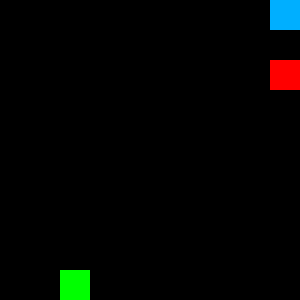

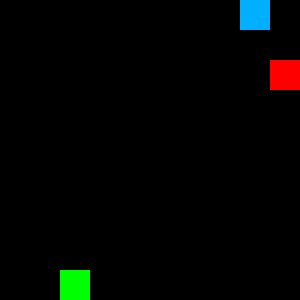

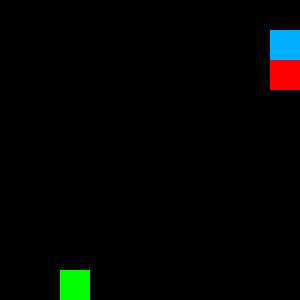

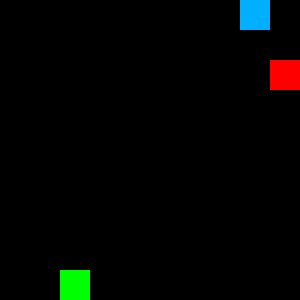

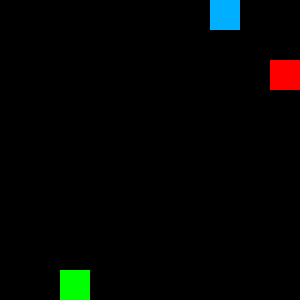

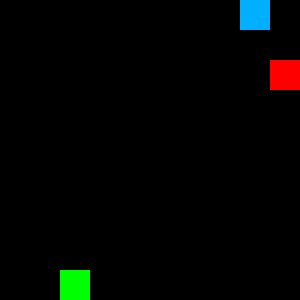

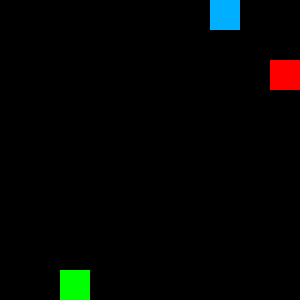

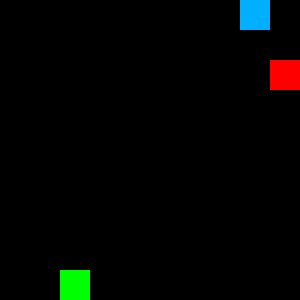

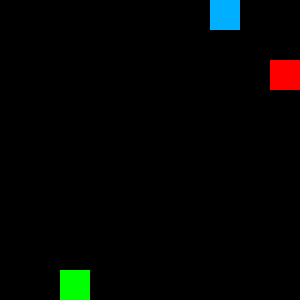

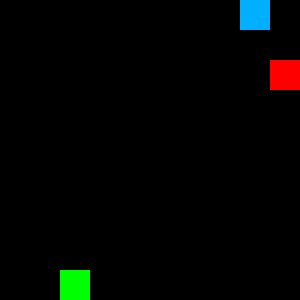

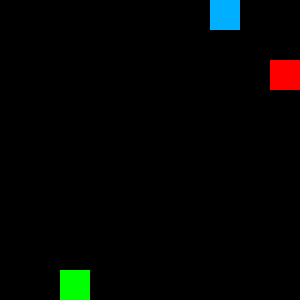

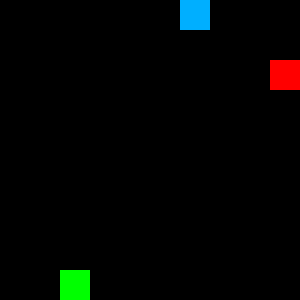

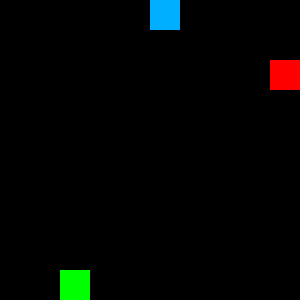

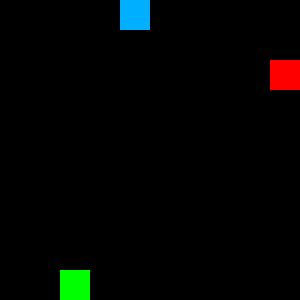

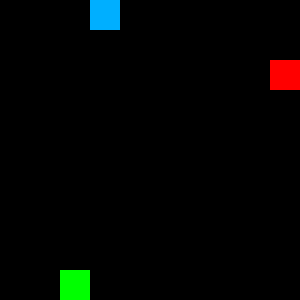

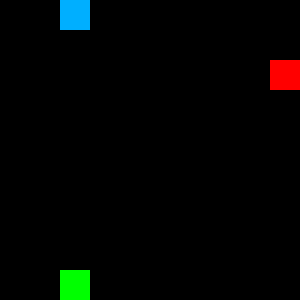

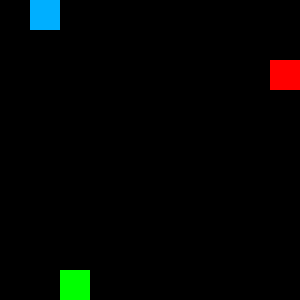

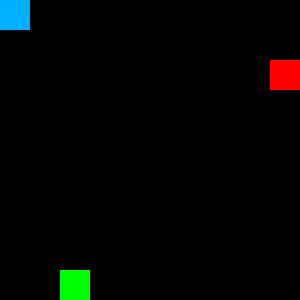

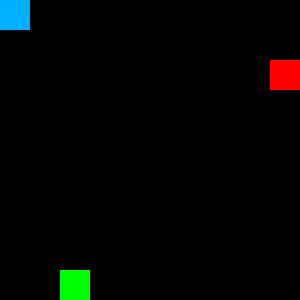

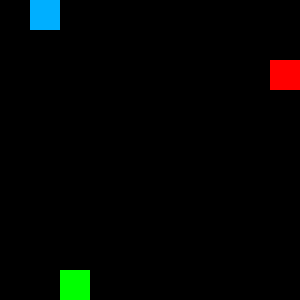

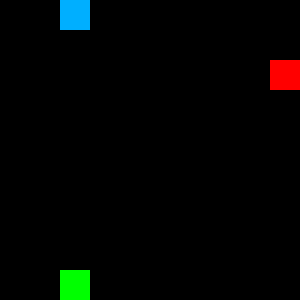

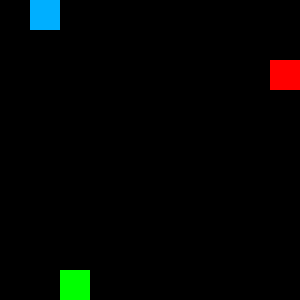

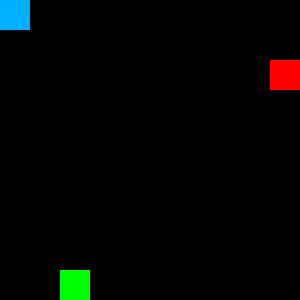

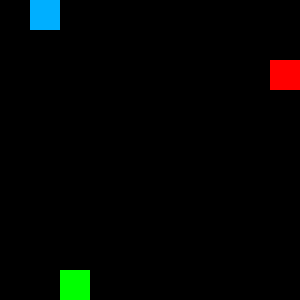

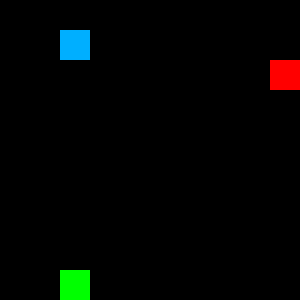

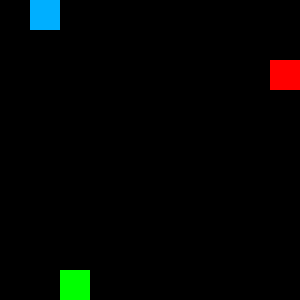

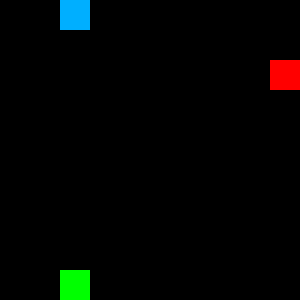

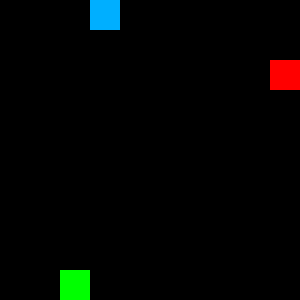

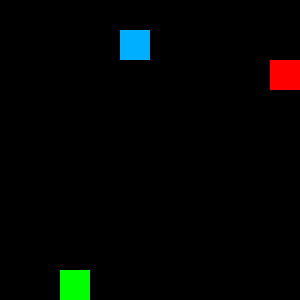

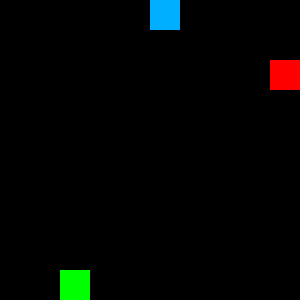

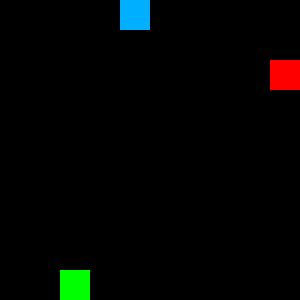

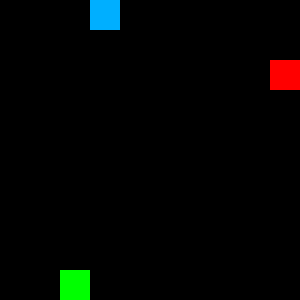

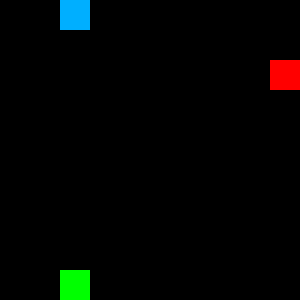

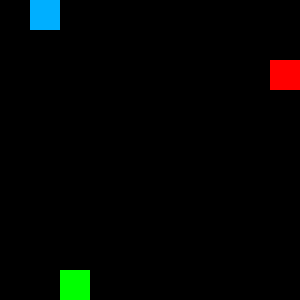

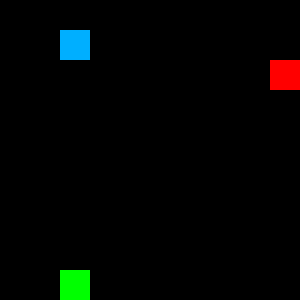

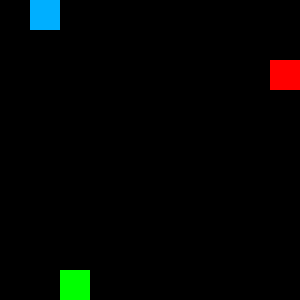

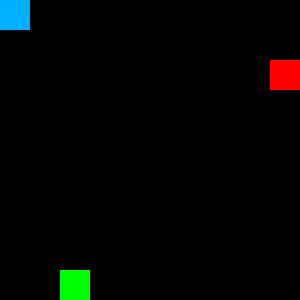

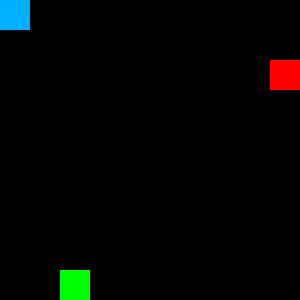

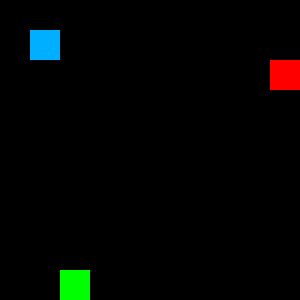

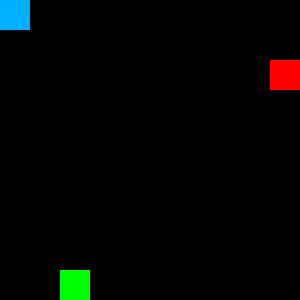

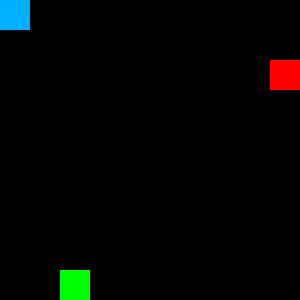

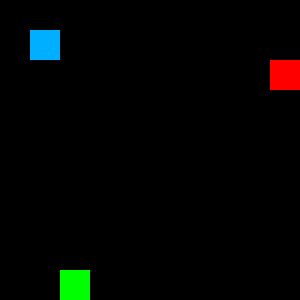

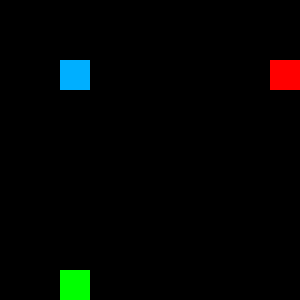

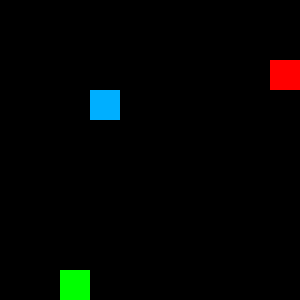

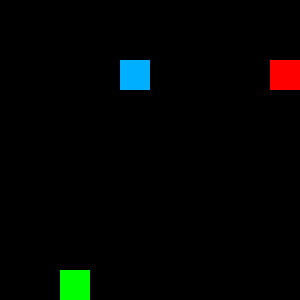

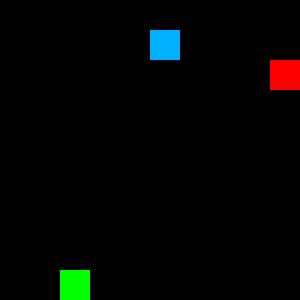

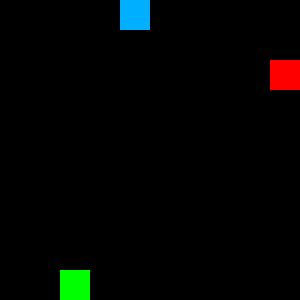

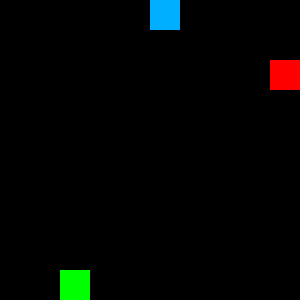

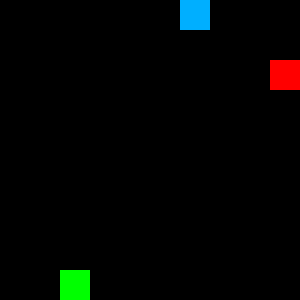

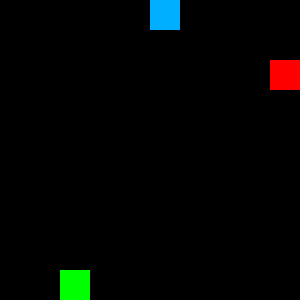

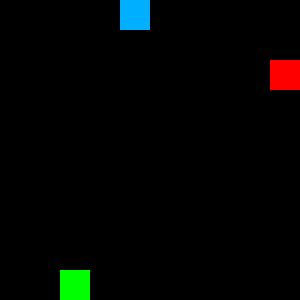

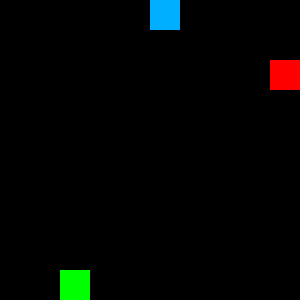

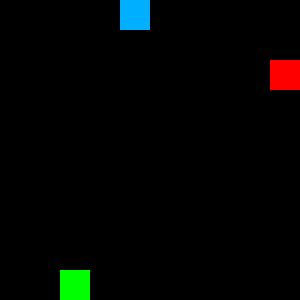

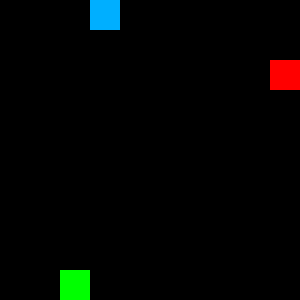

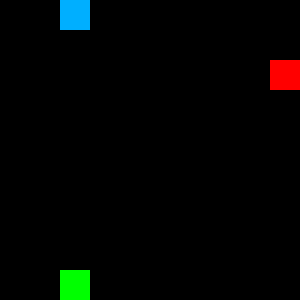

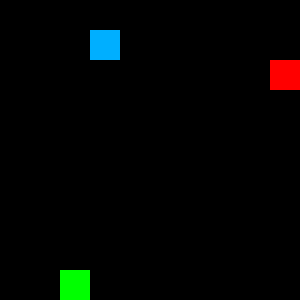

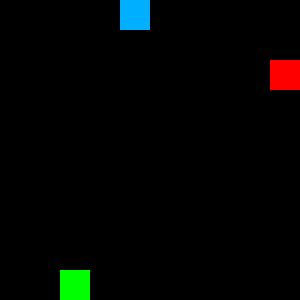

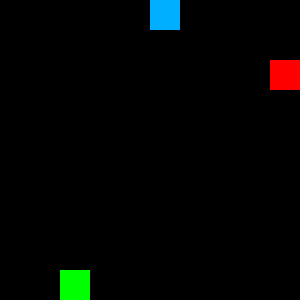

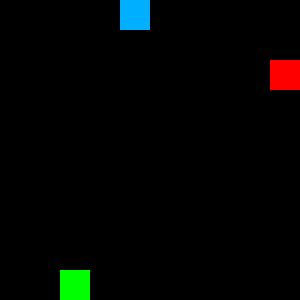

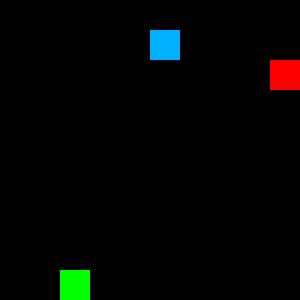

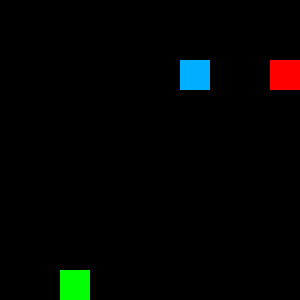

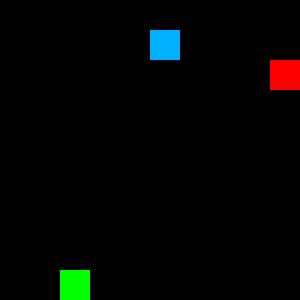

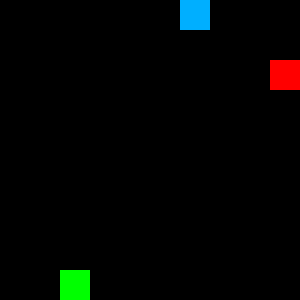

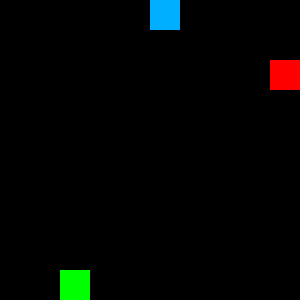

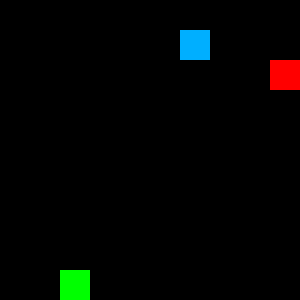

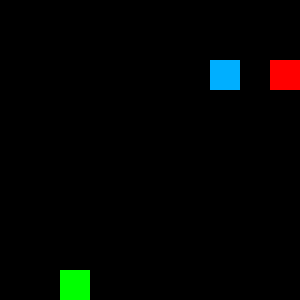

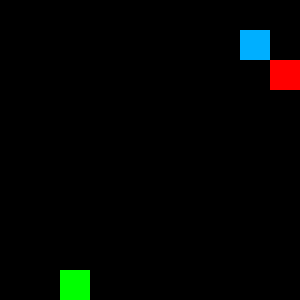

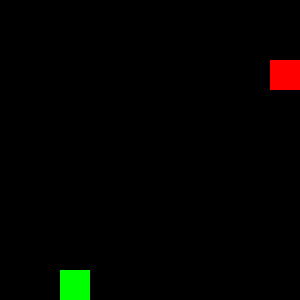

on #5000, epsilon is 0.0022228538331031025
5000 ep mean: -169.5068


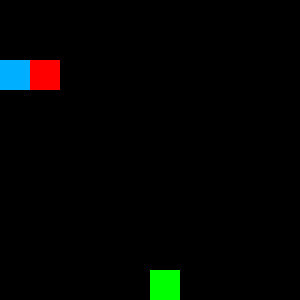

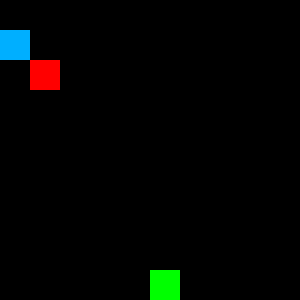

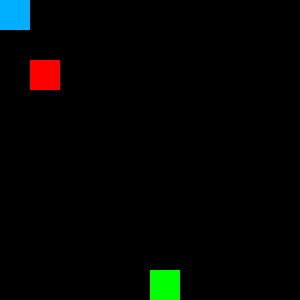

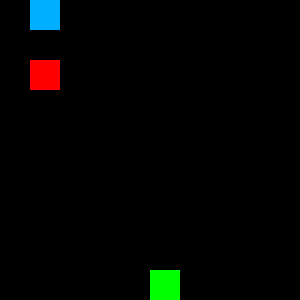

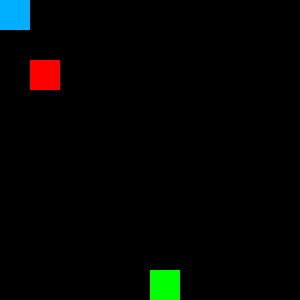

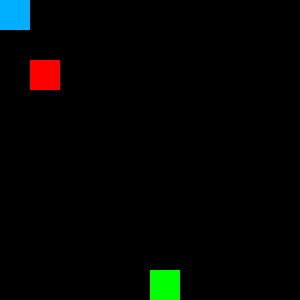

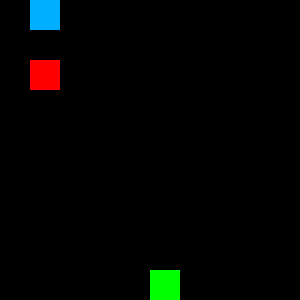

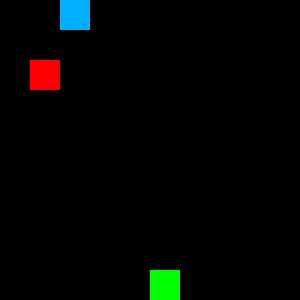

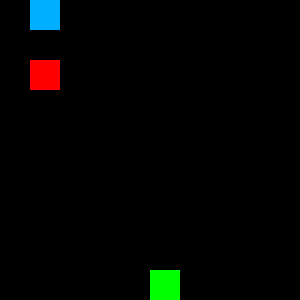

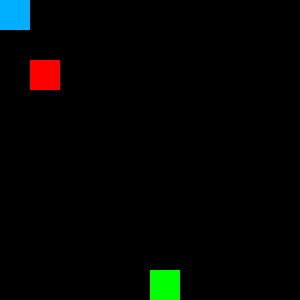

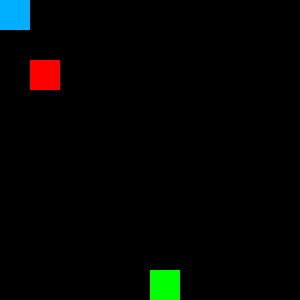

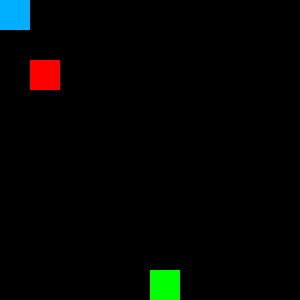

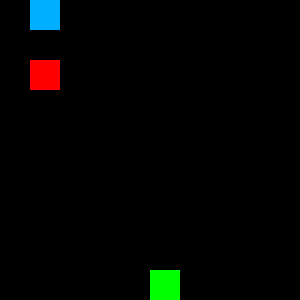

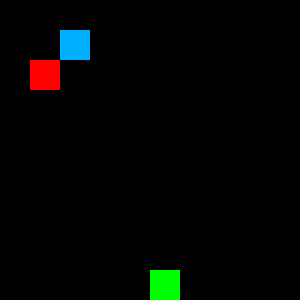

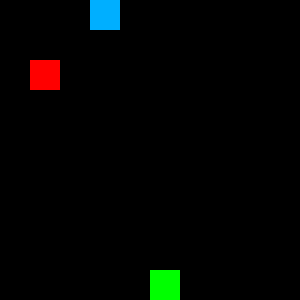

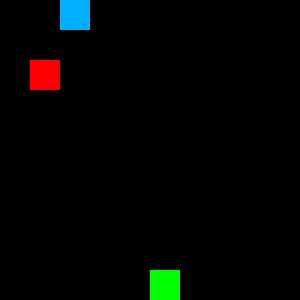

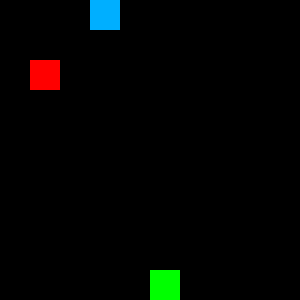

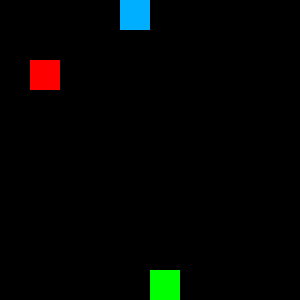

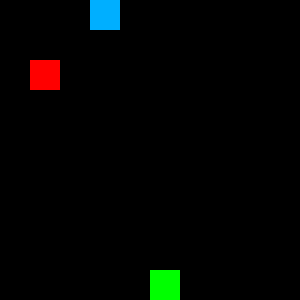

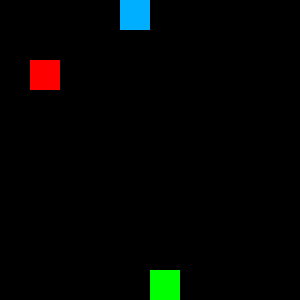

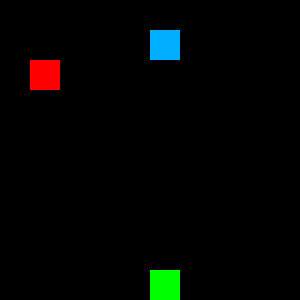

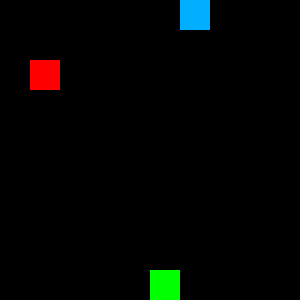

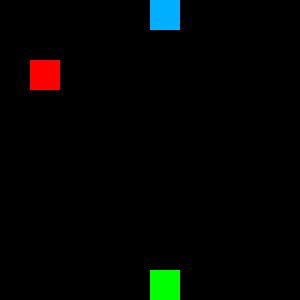

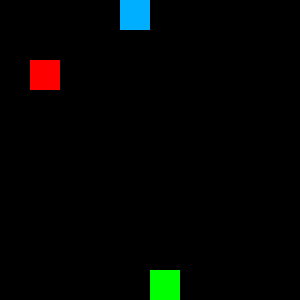

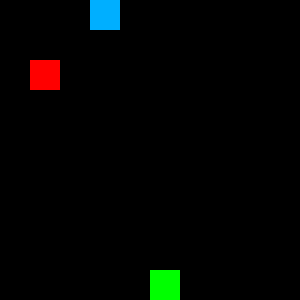

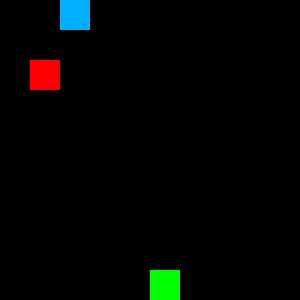

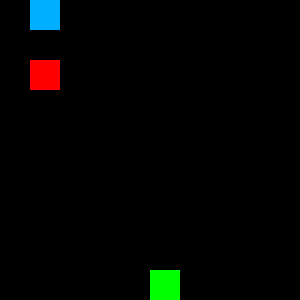

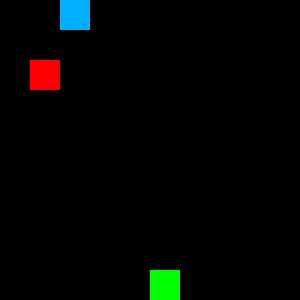

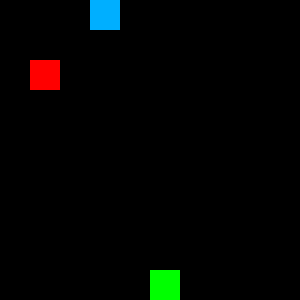

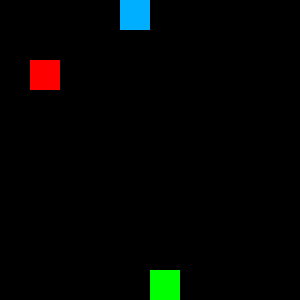

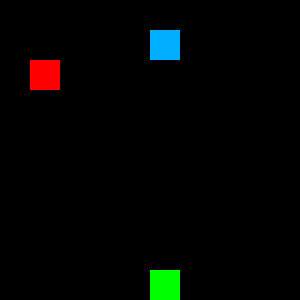

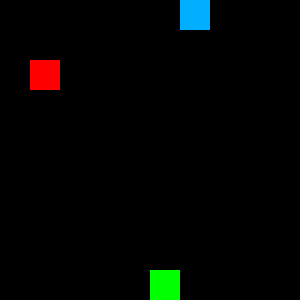

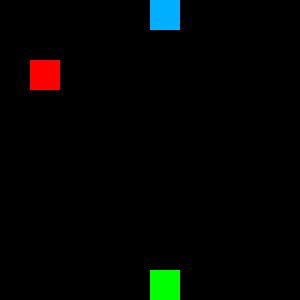

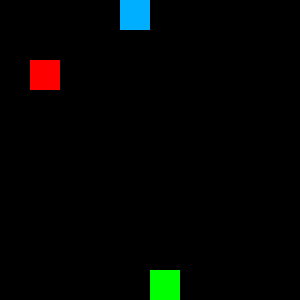

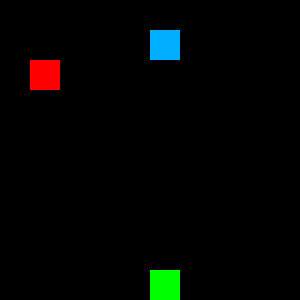

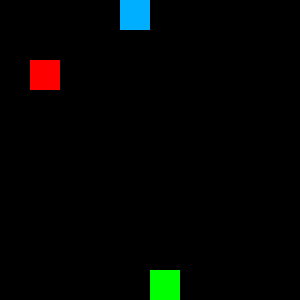

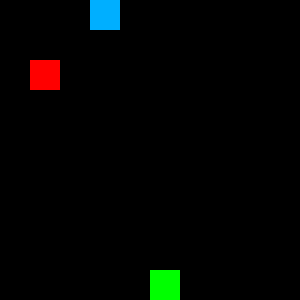

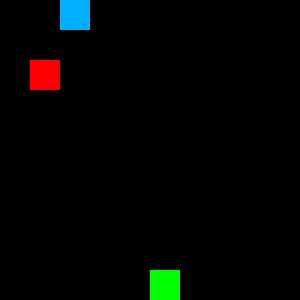

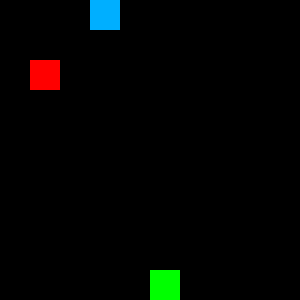

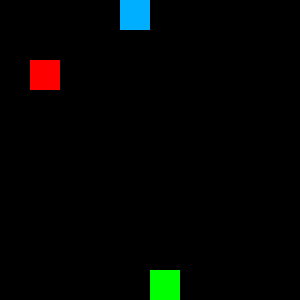

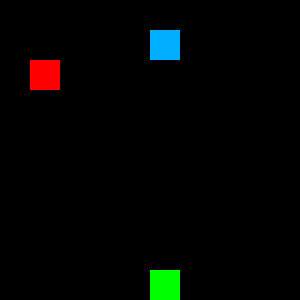

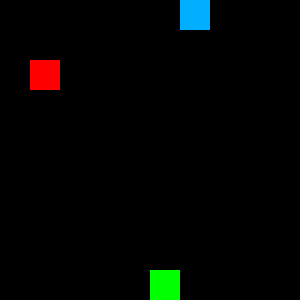

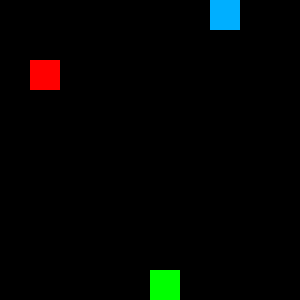

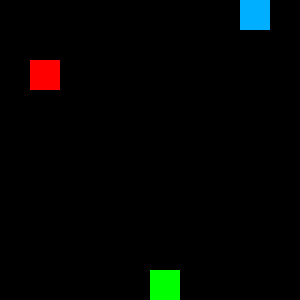

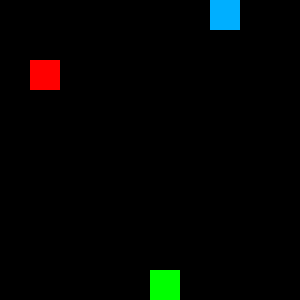

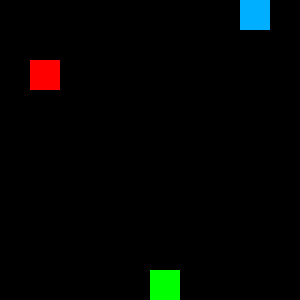

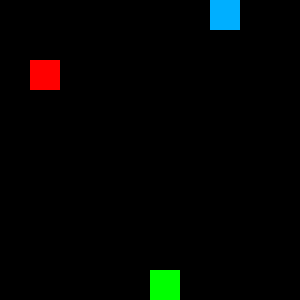

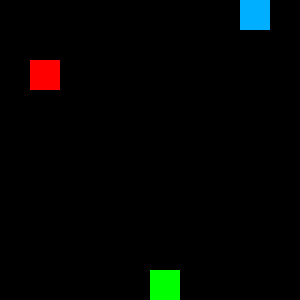

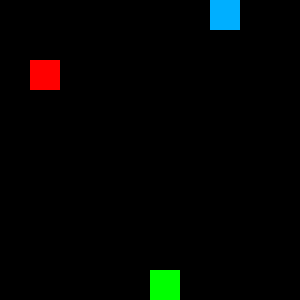

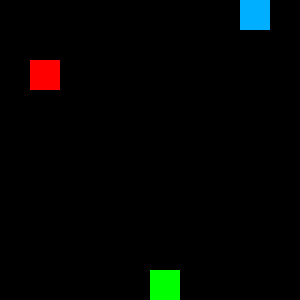

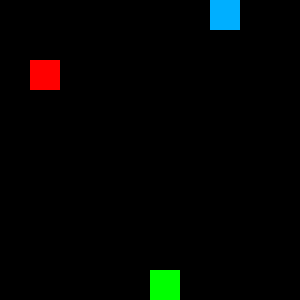

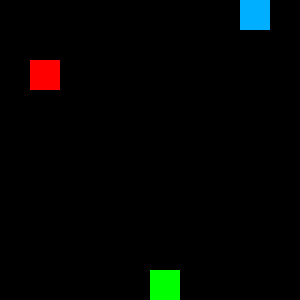

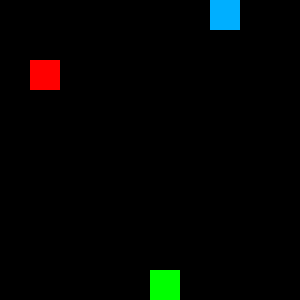

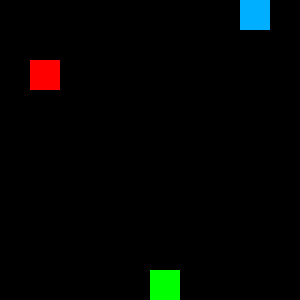

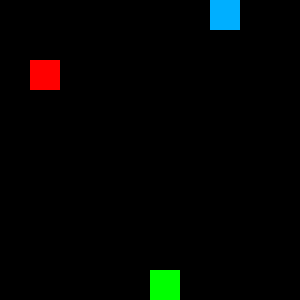

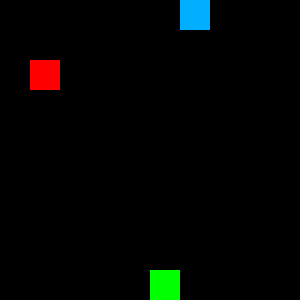

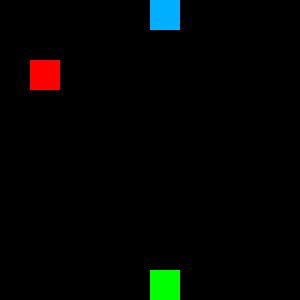

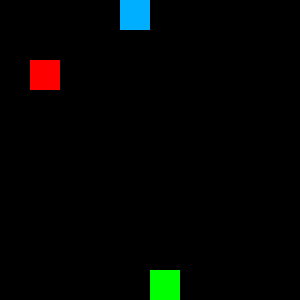

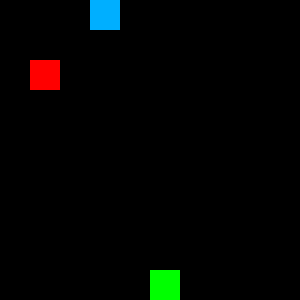

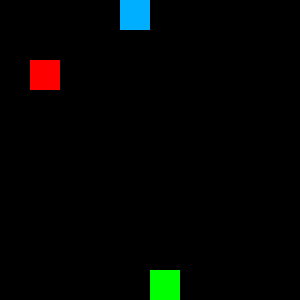

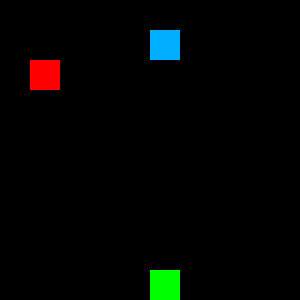

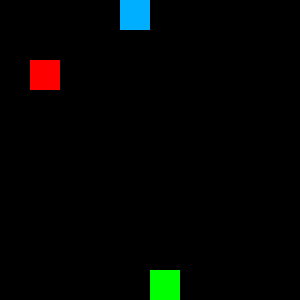

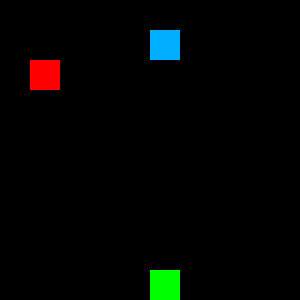

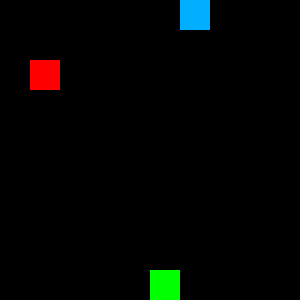

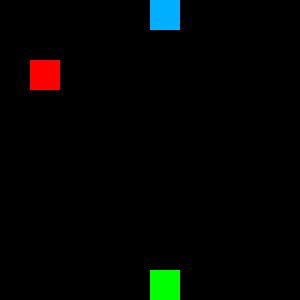

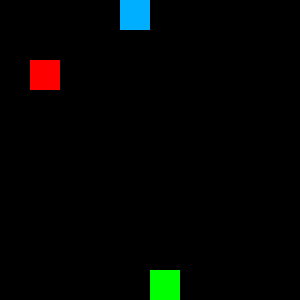

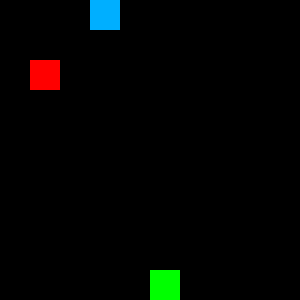

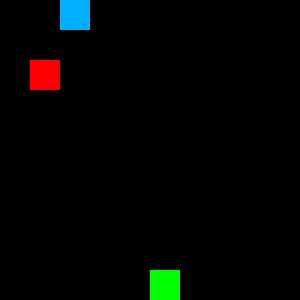

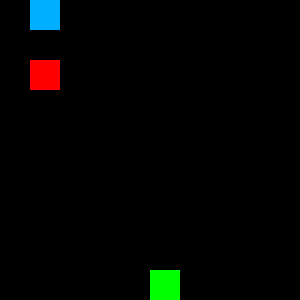

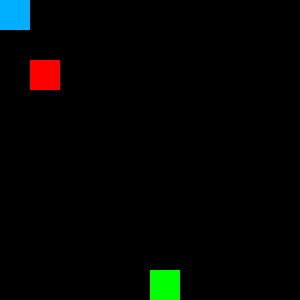

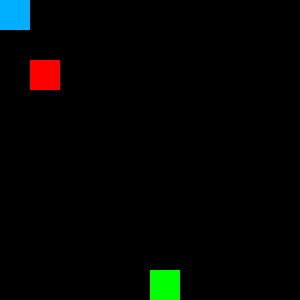

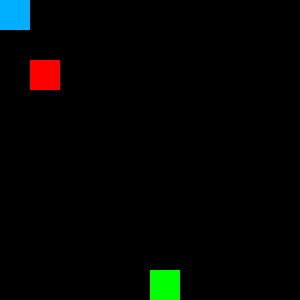

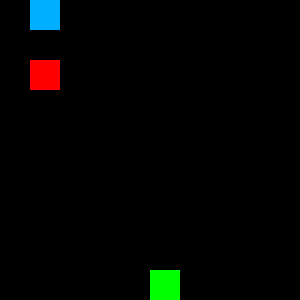

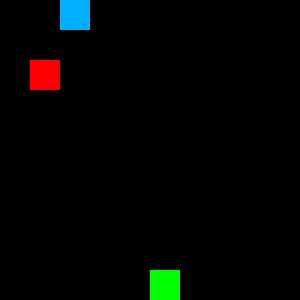

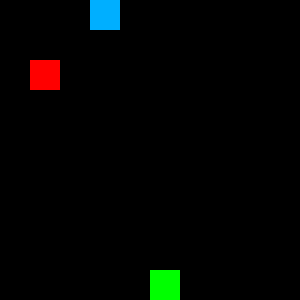

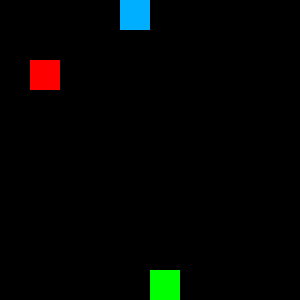

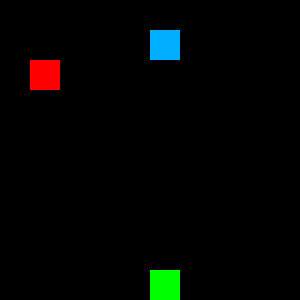

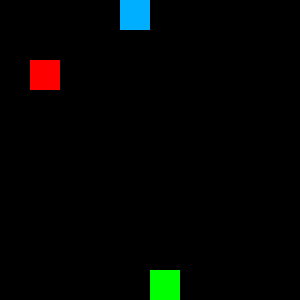

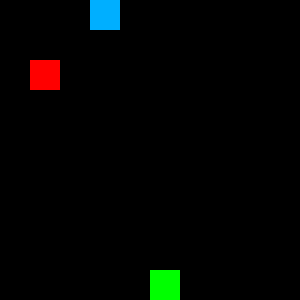

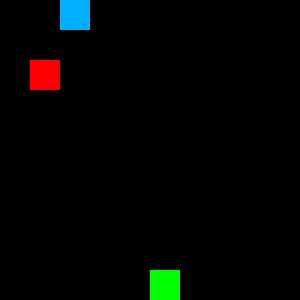

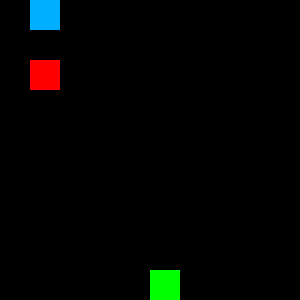

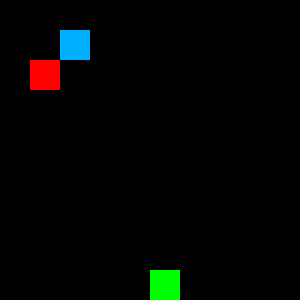

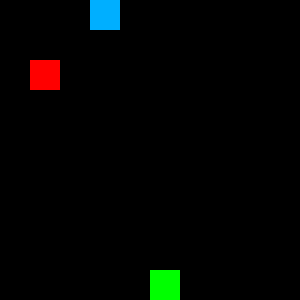

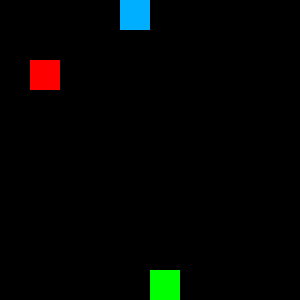

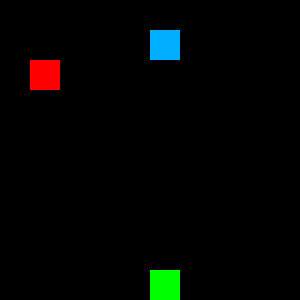

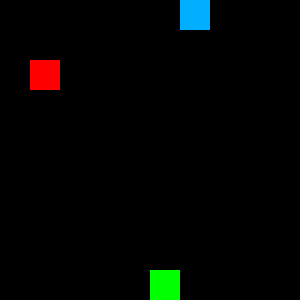

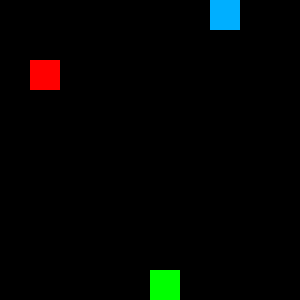

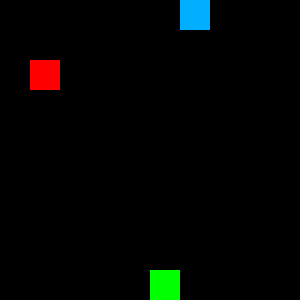

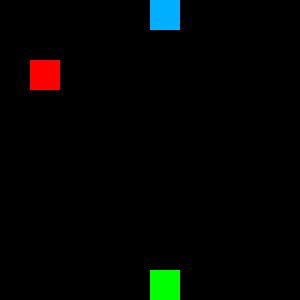

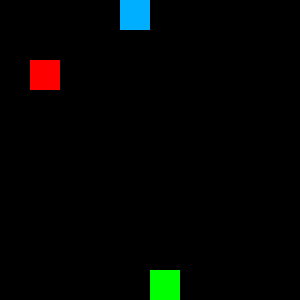

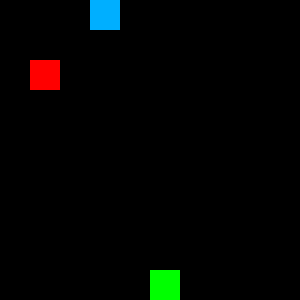

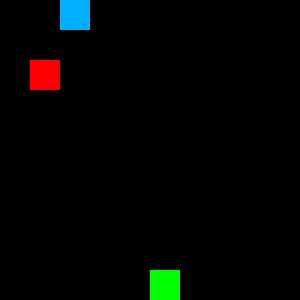

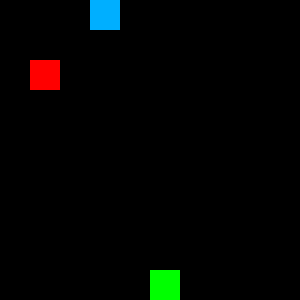

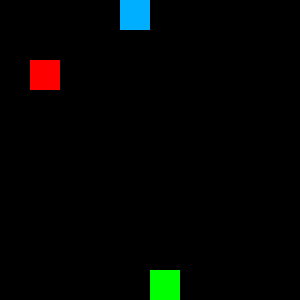

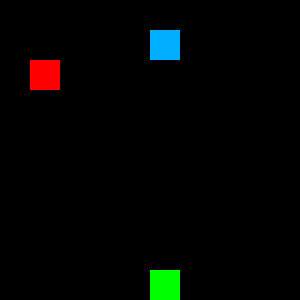

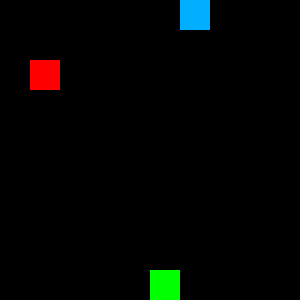

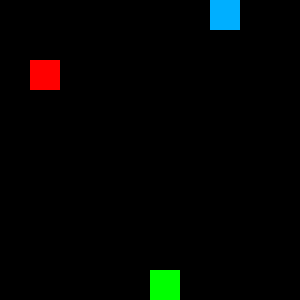

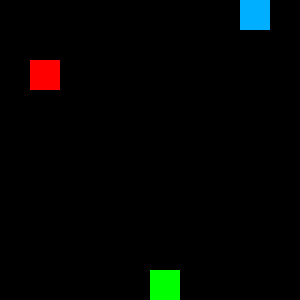

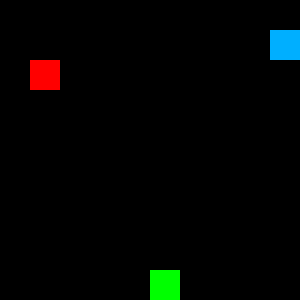

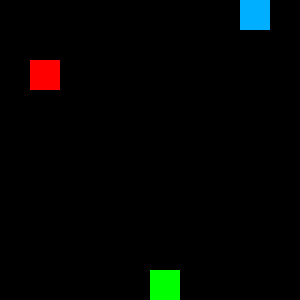

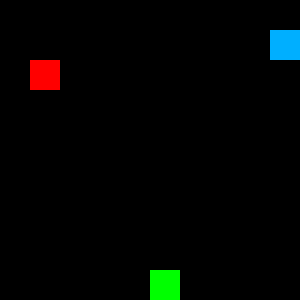

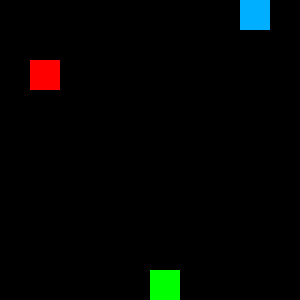

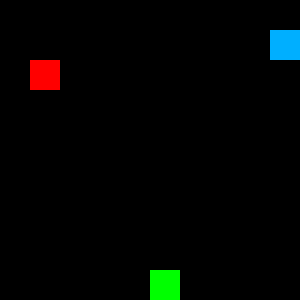

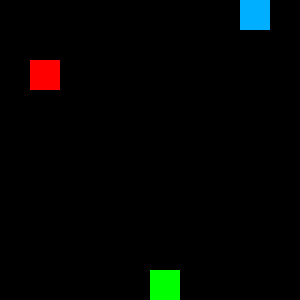

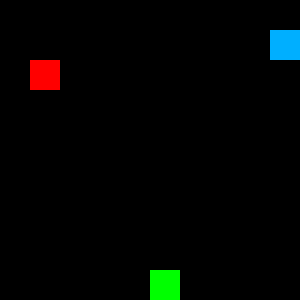

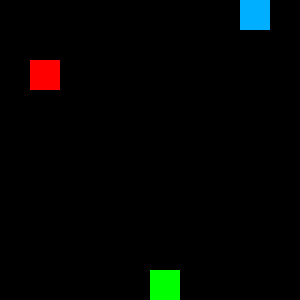

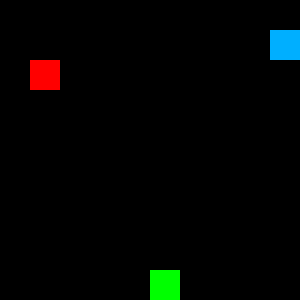

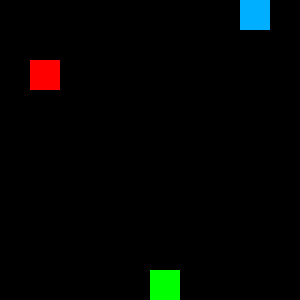

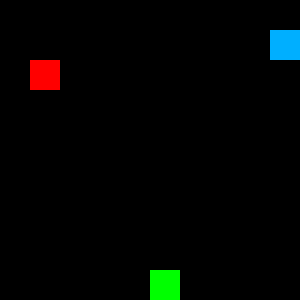

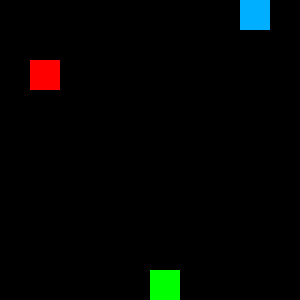

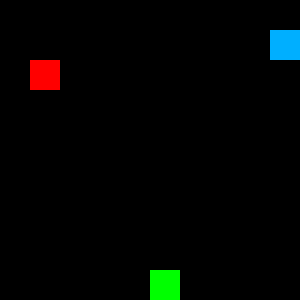

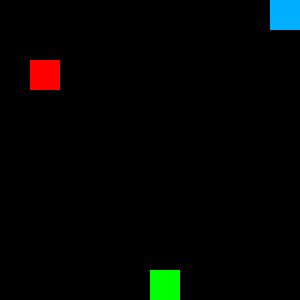

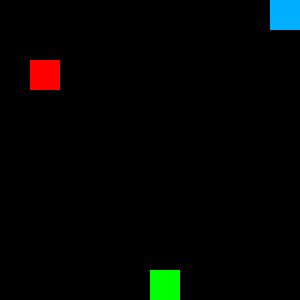

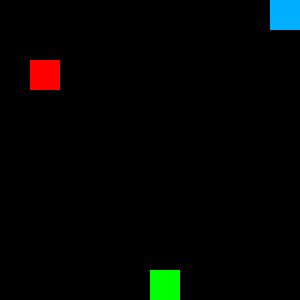

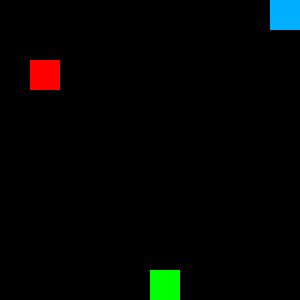

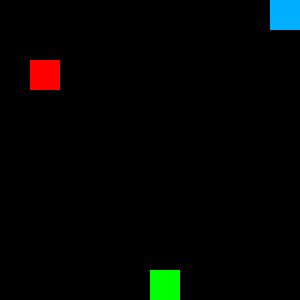

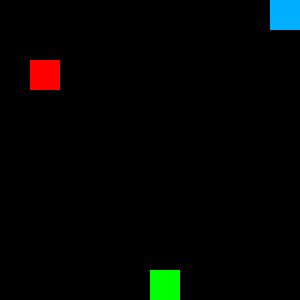

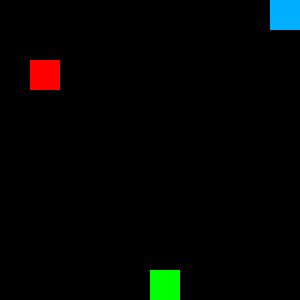

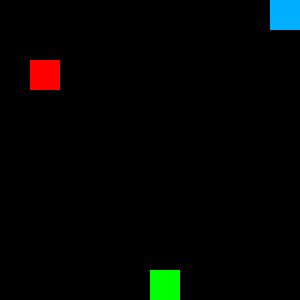

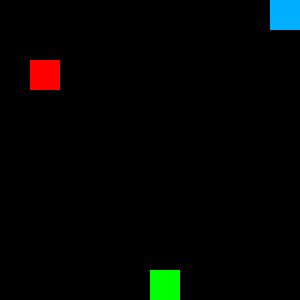

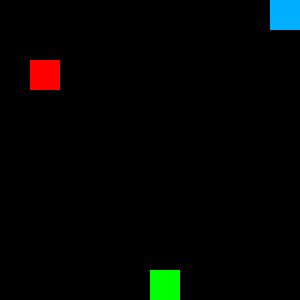

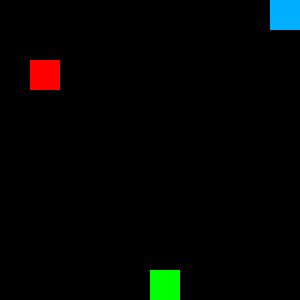

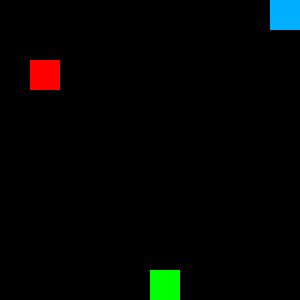

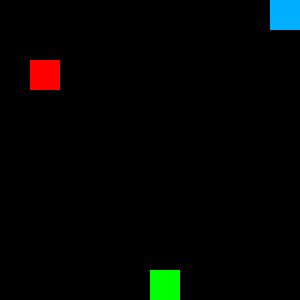

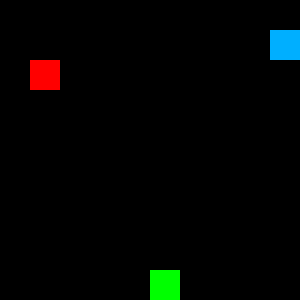

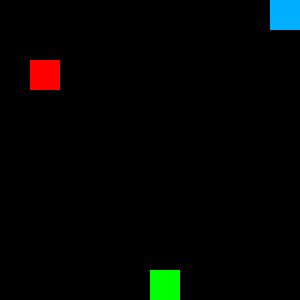

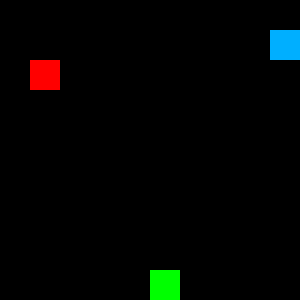

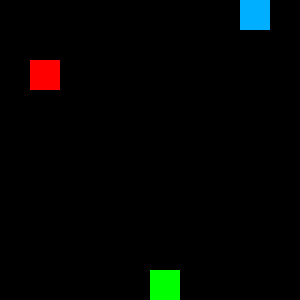

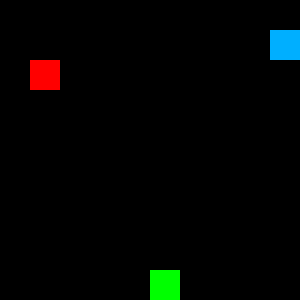

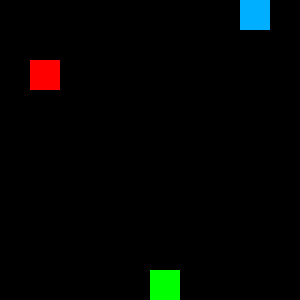

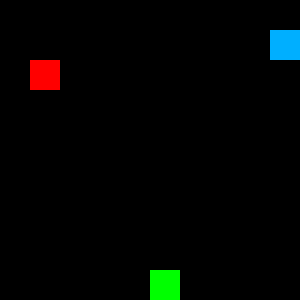

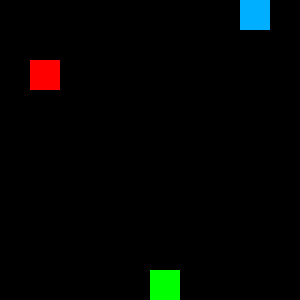

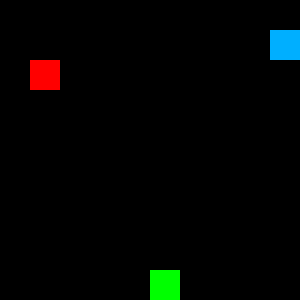

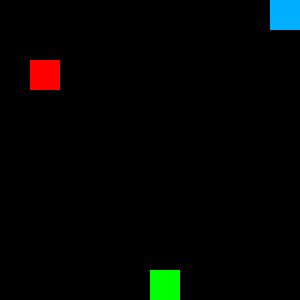

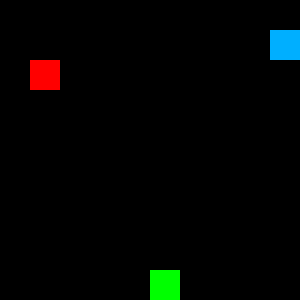

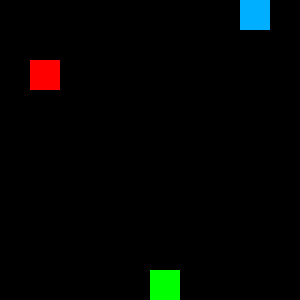

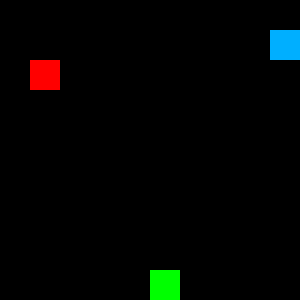

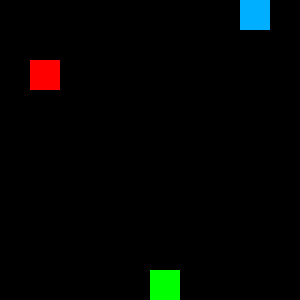

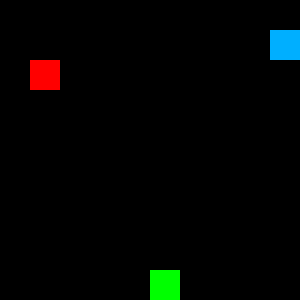

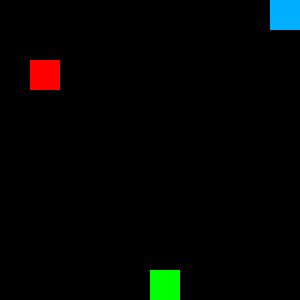

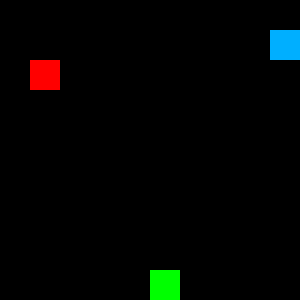

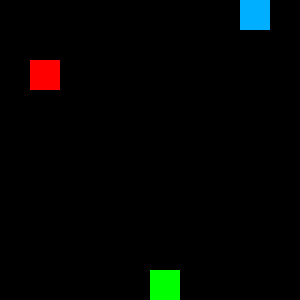

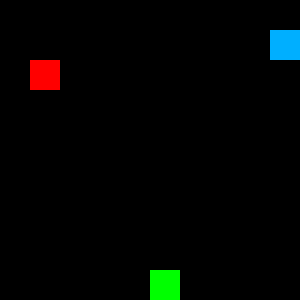

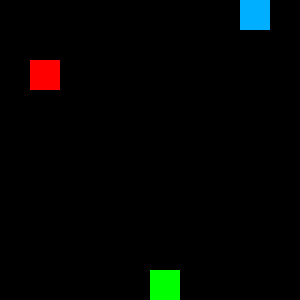

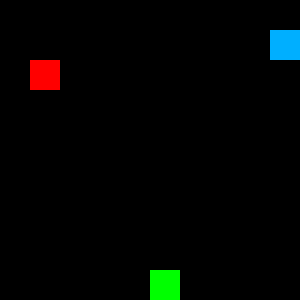

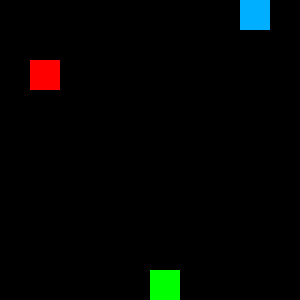

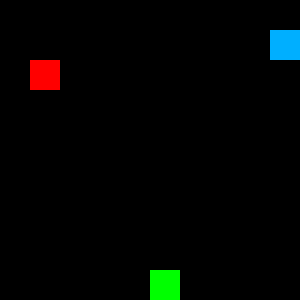

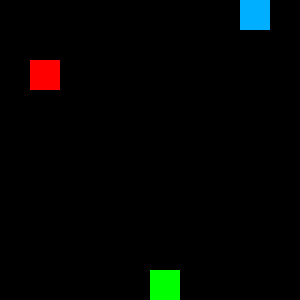

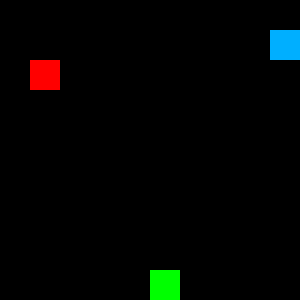

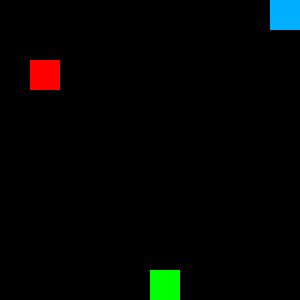

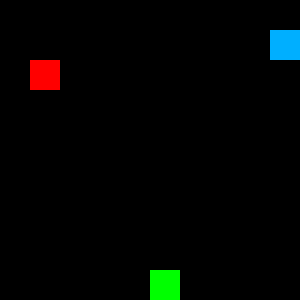

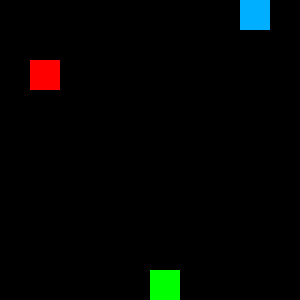

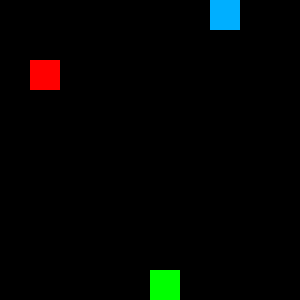

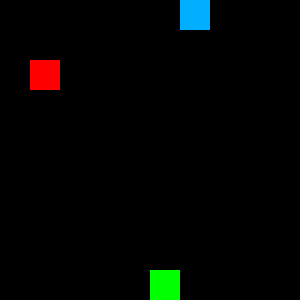

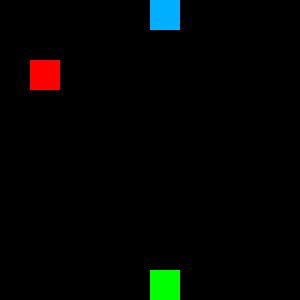

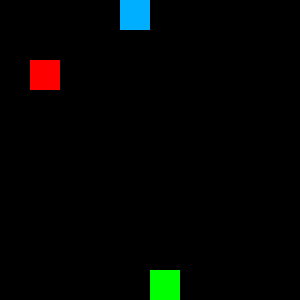

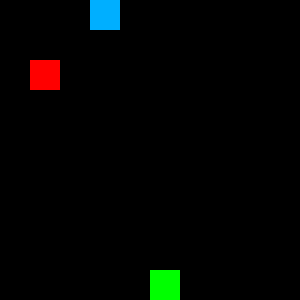

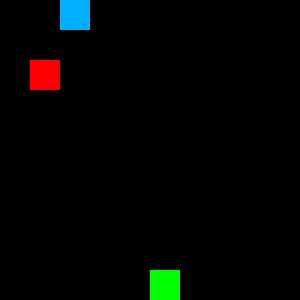

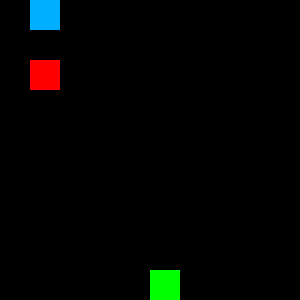

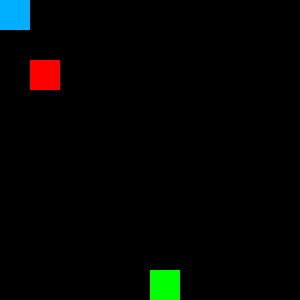

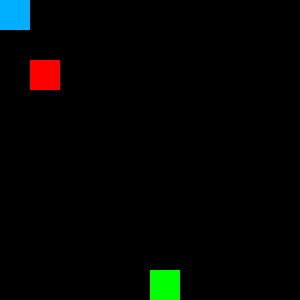

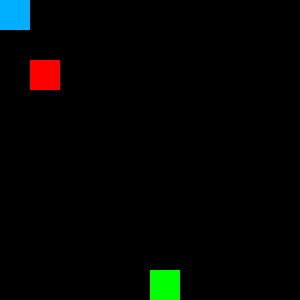

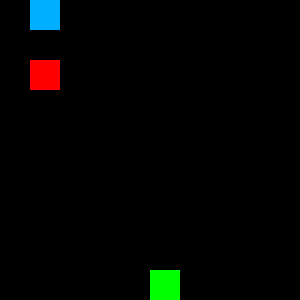

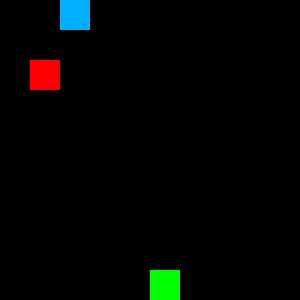

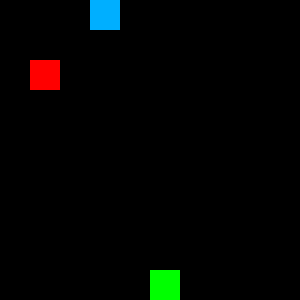

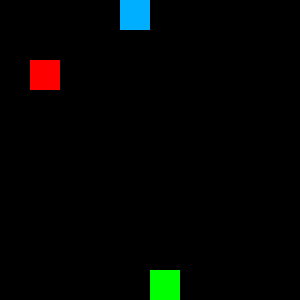

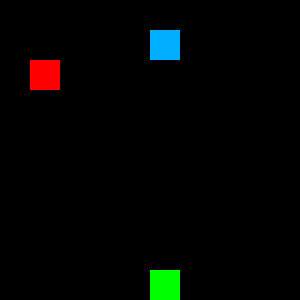

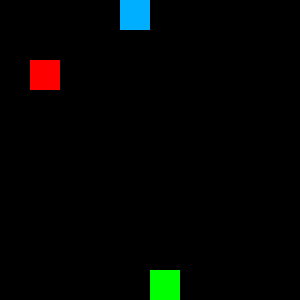

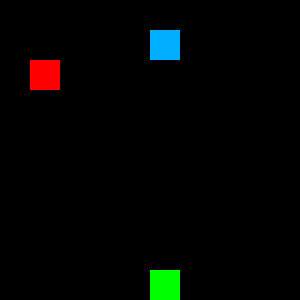

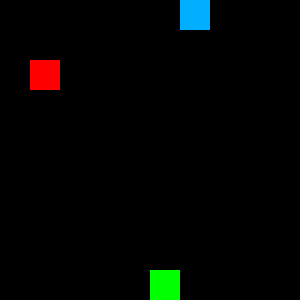

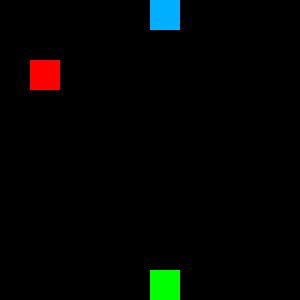

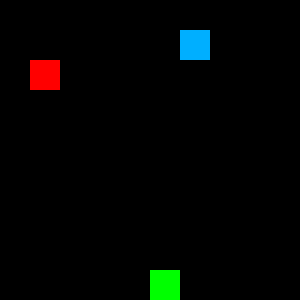

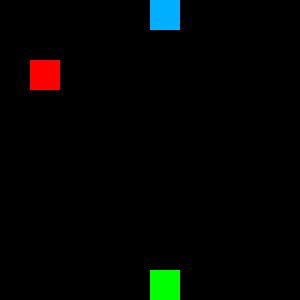

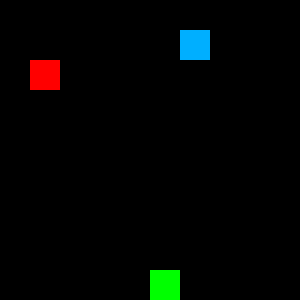

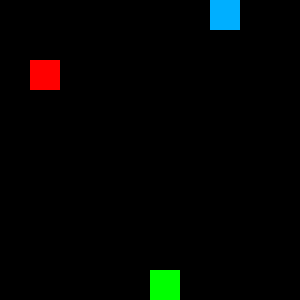

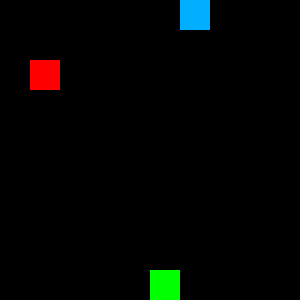

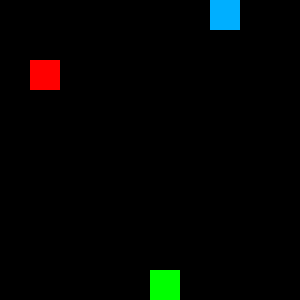

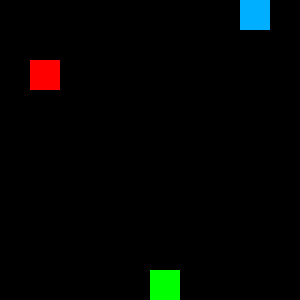

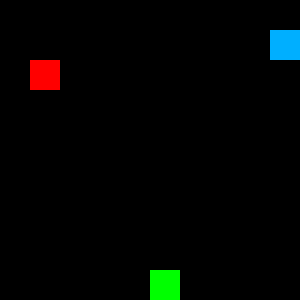

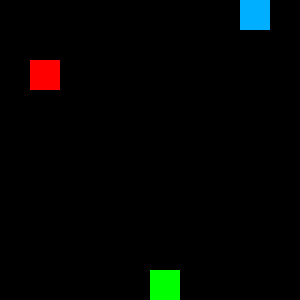

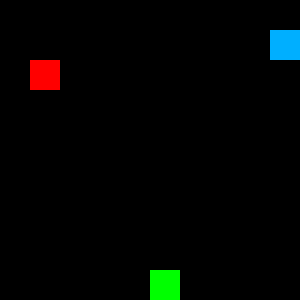

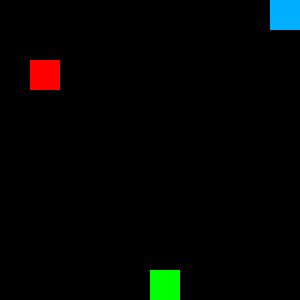

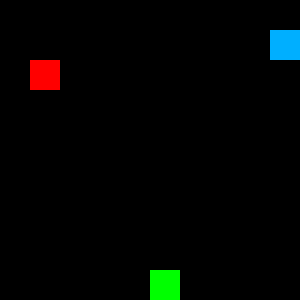

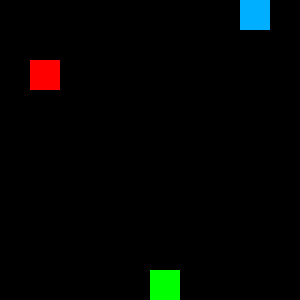

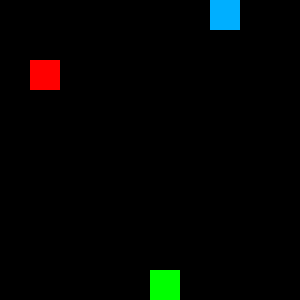

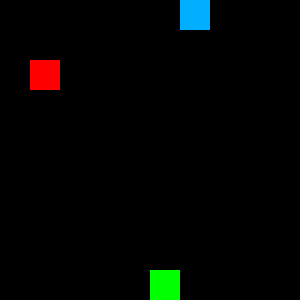

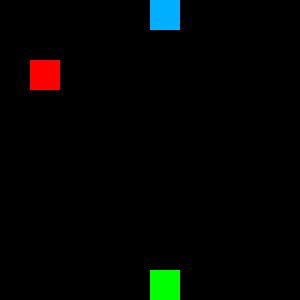

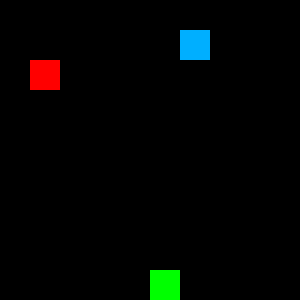

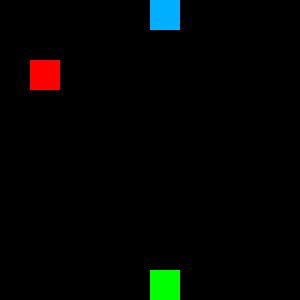

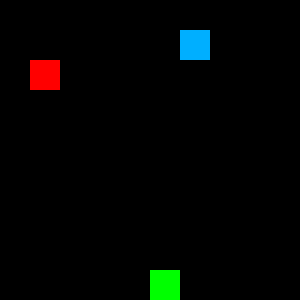

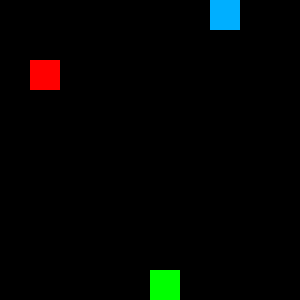

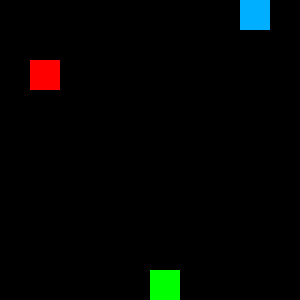

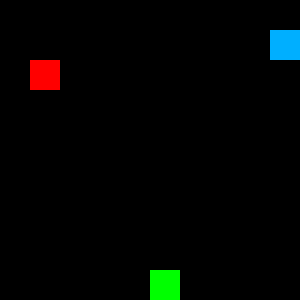

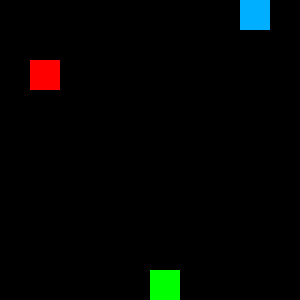

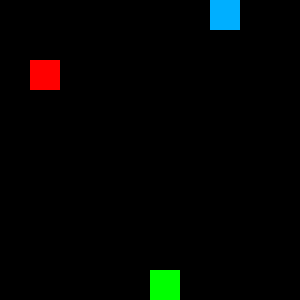

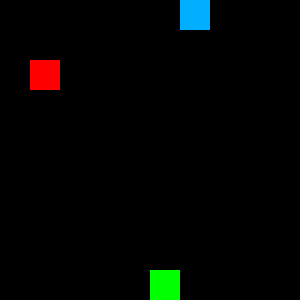

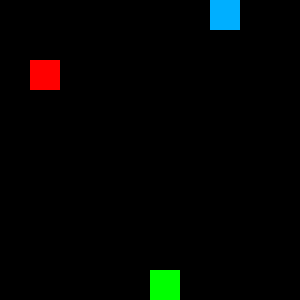

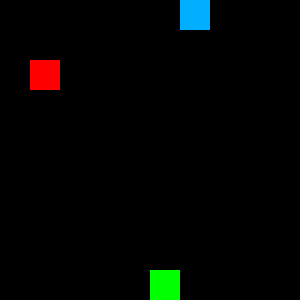

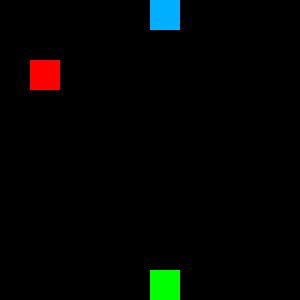

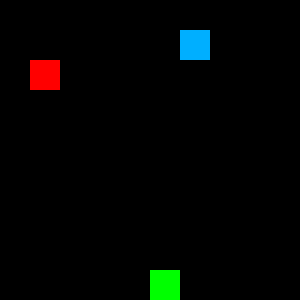

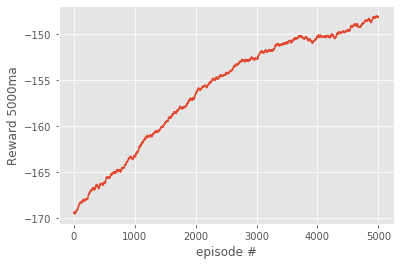

In [11]:
cv2.startWindowThread()

episode_rewards = []

for episode in range(HM_EPISODES):
    player = Blob()
    food = Blob()
    enemy = Blob()
    
    if episode % SHOW_EVERY == 0:
        print(f"on #{episode}, epsilon is {epsilon}")
        print(f"{SHOW_EVERY} ep mean: {np.mean(episode_rewards[-SHOW_EVERY:])}")
        show = True
    else:
        show = False

    episode_reward = 0
    
    for i in range(200):
        obs = (player-food, player-enemy)
        # print(obs)
        if np.random.random() > epsilon:
            # GET THE ACTION
            action = np.argmax(q_table[obs])
        else:
            action = np.random.randint(0, 4)
        # Take the action!
        player.action(action)

        if player.x == enemy.x and player.y == enemy.y:
            reward = -ENEMY_PENALTY

        elif player.x == food.x and player.y == food.y:
            reward = FOOD_REWARD

        else:
            reward = -MOVE_PENALTY

        ## NOW WE KNOW THE REWARD, LET'S CALC YO
        # first we need to obs immediately after the move.

        new_obs = (player-food, player-enemy)  # new observation
        max_future_q = np.max(q_table[new_obs])  # max Q value for this new obs
        current_q = q_table[obs][action]  # current Q for our chosen action

        if reward == FOOD_REWARD:
            new_q = FOOD_REWARD
        elif reward == -ENEMY_PENALTY:
            new_q = -ENEMY_PENALTY
        else:
            new_q = (1 - LEARNING_RATE) * current_q + LEARNING_RATE*(reward + DISCOUNT*max_future_q)

        q_table[obs][action] = new_q

        if show:
            env = np.zeros((SIZE, SIZE, 3), dtype=np.uint8)  # starts an rbg of our size
            env[food.y][food.x] = d[FOOD_N]  # sets the food location tile to green color
            env[player.y][player.x] = d[PLAYER_N]  # sets the player tile to blue
            env[enemy.y][enemy.x] = d[ENEMY_N]  # sets the enemy location to red
            img = Image.fromarray(env, 'RGB')  # reading to rgb. Apparently. Even tho color definitions are bgr. ???
            img = img.resize((300, 300))  # resizing so we can see our agent in all its glory.
            cv2_imshow(np.array(img))  # show it!
            if reward == FOOD_REWARD or reward == -ENEMY_PENALTY:  # crummy code to hang at the end if we reach abrupt end for good reasons or not.
                if cv2.waitKey(500) & 0xFF == ord('q'):
                    break
            else:
                if cv2.waitKey(1) & 0xFF == ord('q'):
                    break
            
        episode_reward += reward

        if reward == FOOD_REWARD or reward == -ENEMY_PENALTY: #if we either reached objective or hit our enemy
          break

    #print(episode_reward)
    episode_rewards.append(episode_reward)
    epsilon *= EPS_DECAY


# plotting rewards
moving_avg = np.convolve(episode_rewards, np.ones((SHOW_EVERY,))/SHOW_EVERY, mode='valid')

plt.plot([i for i in range(len(moving_avg))], moving_avg)
plt.ylabel(f"Reward {SHOW_EVERY}ma")
plt.xlabel("episode #")
plt.show()


with open(f"qtable-{int(time.time())}.pickle", "wb") as f:
    pickle.dump(q_table, f)

저장한 Q테이블을 가지고 또 훈련 가보자.

In [0]:
start_q_table = '/content/qtable-1576079704.pickle'
if start_q_table is None:
    # initialize the q-table#
    q_table = {}
    for i in range(-SIZE+1, SIZE):
        for ii in range(-SIZE+1, SIZE):
            for iii in range(-SIZE+1, SIZE):
                    for iiii in range(-SIZE+1, SIZE):
                        q_table[((i, ii), (iii, iiii))] = [np.random.uniform(-5, 0) for i in range(4)]
else:
    with open(start_q_table, "rb") as f:
        q_table = pickle.load(f)

on #0, epsilon is 5.490087959267951e-06
5000 ep mean: nan


/usr/local/lib/python3.6/dist-packages/numpy/core/fromnumeric.py:3257: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


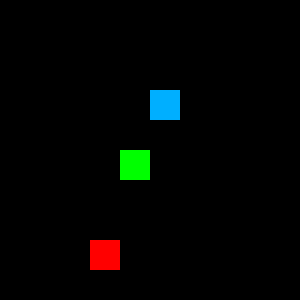

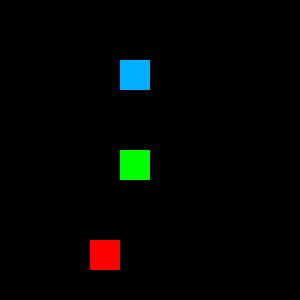

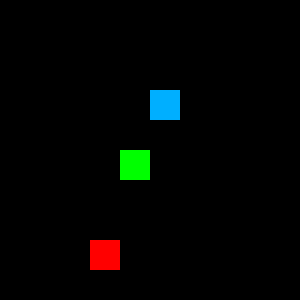

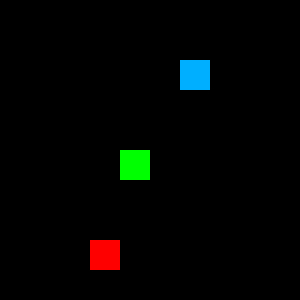

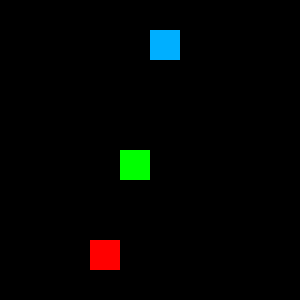

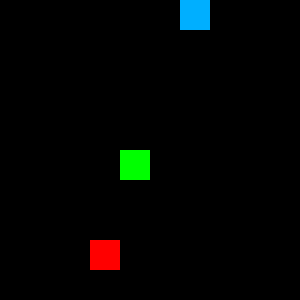

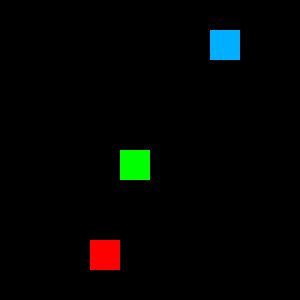

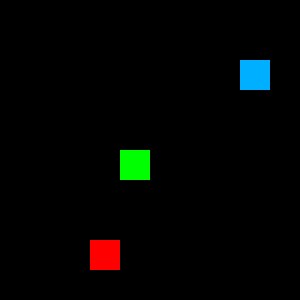

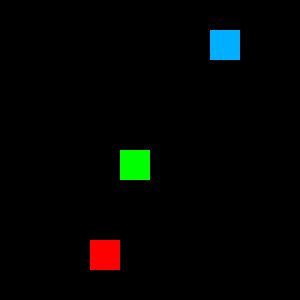

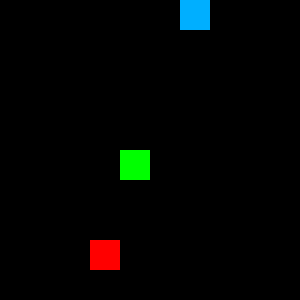

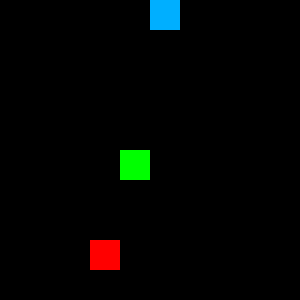

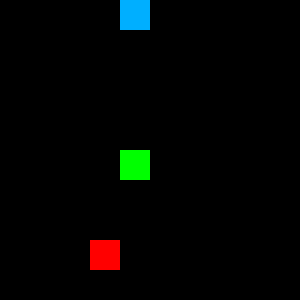

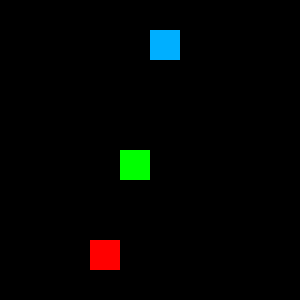

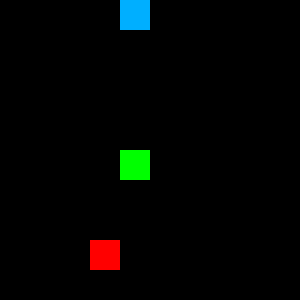

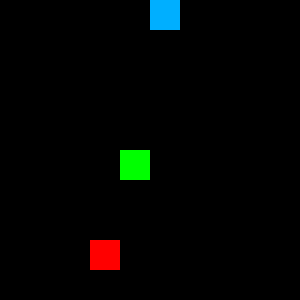

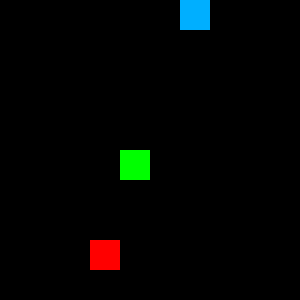

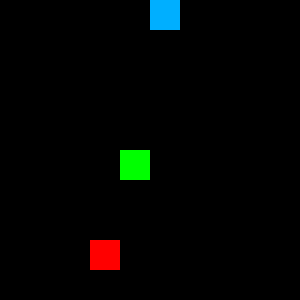

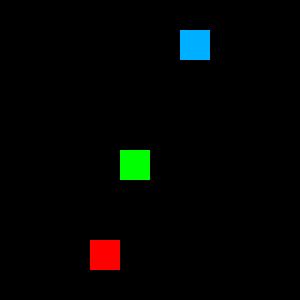

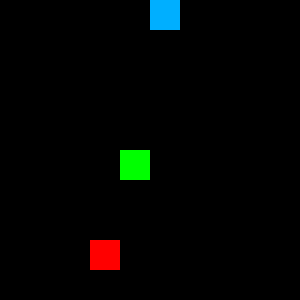

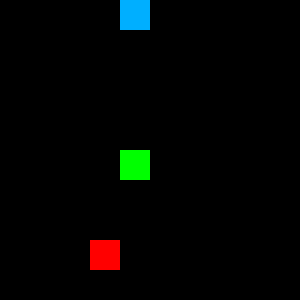

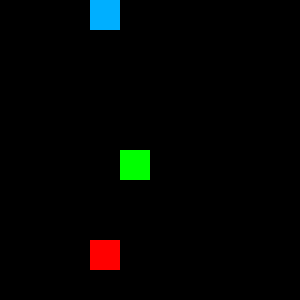

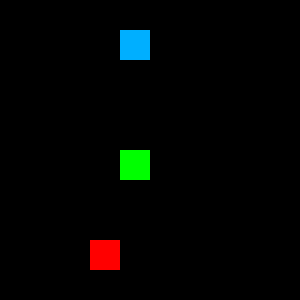

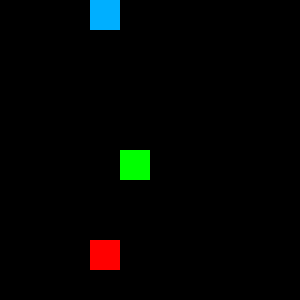

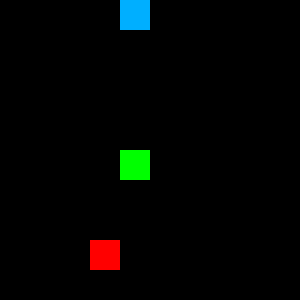

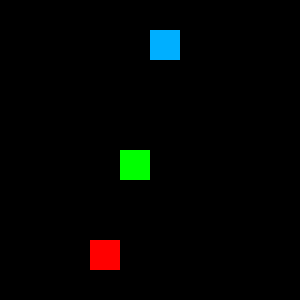

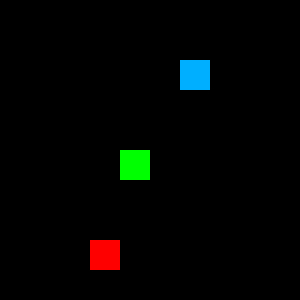

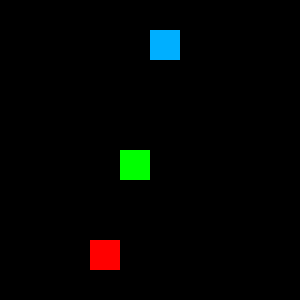

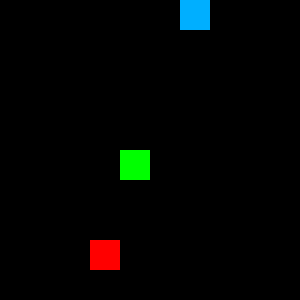

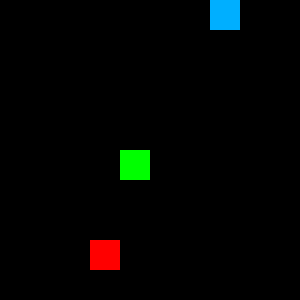

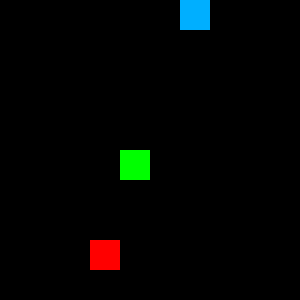

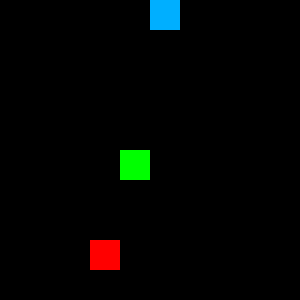

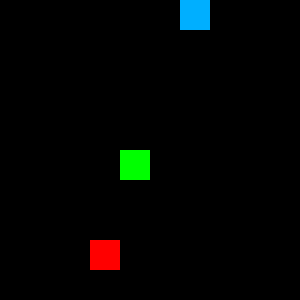

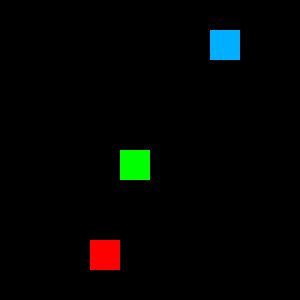

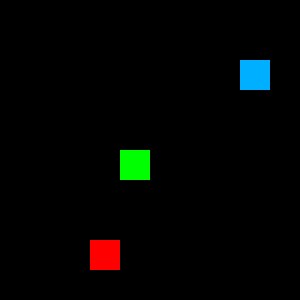

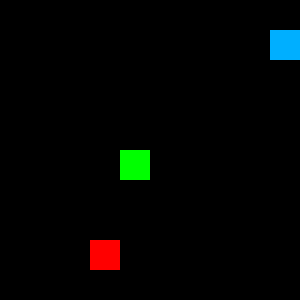

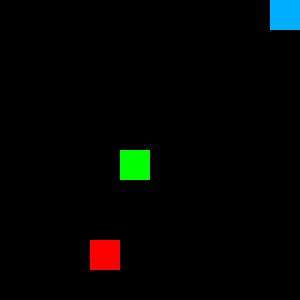

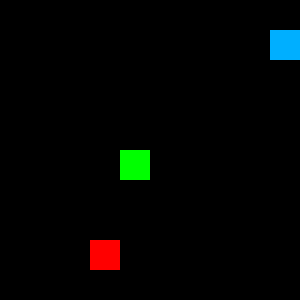

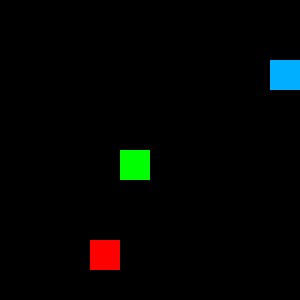

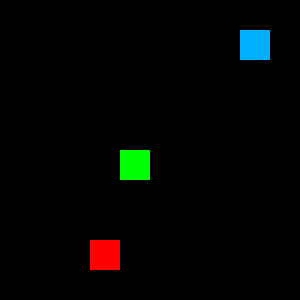

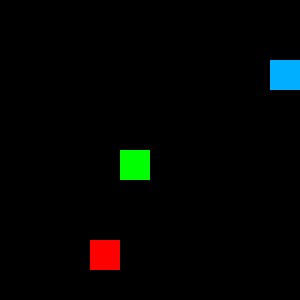

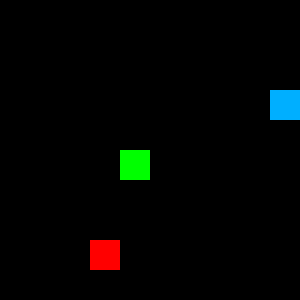

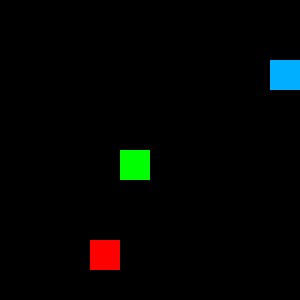

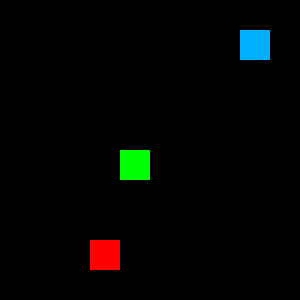

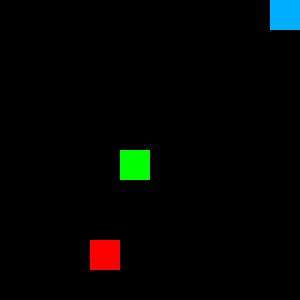

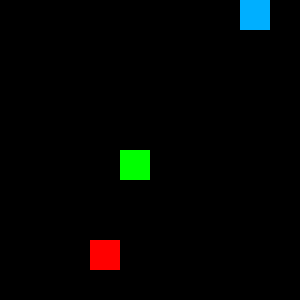

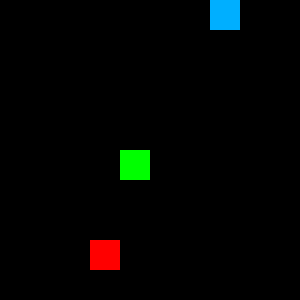

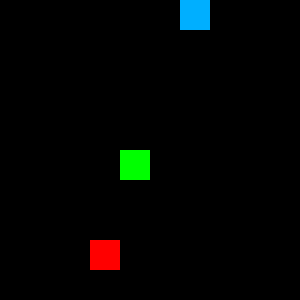

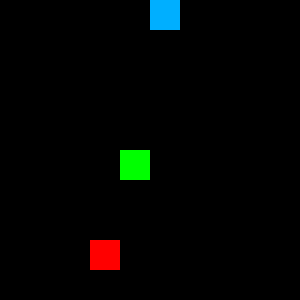

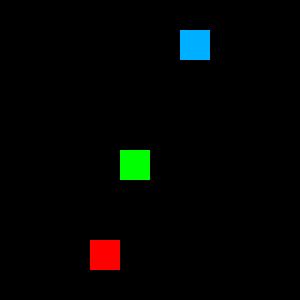

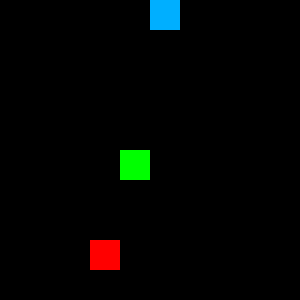

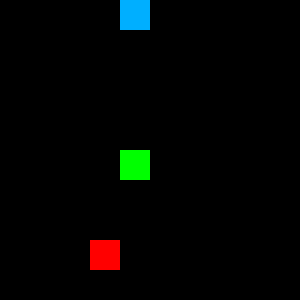

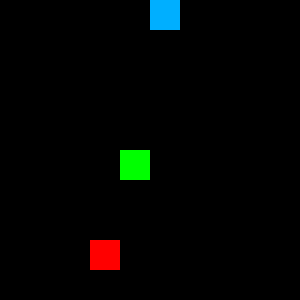

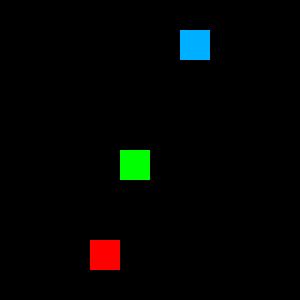

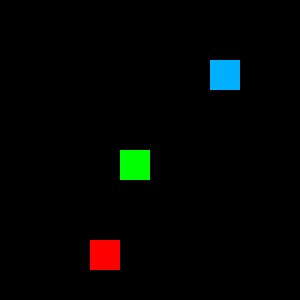

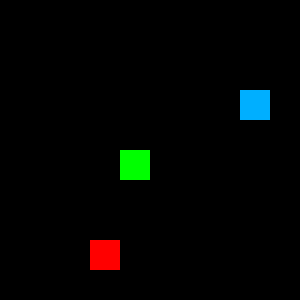

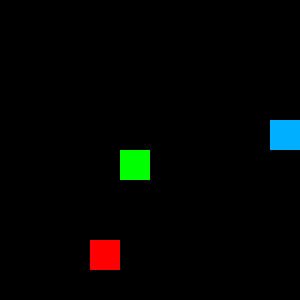

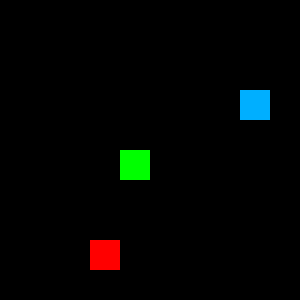

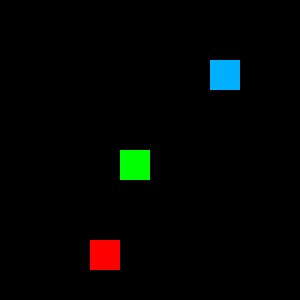

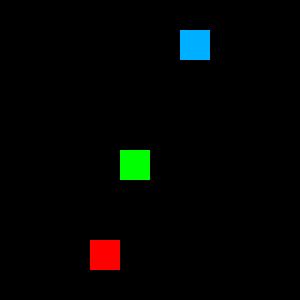

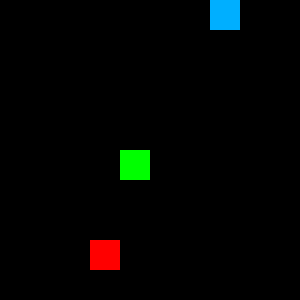

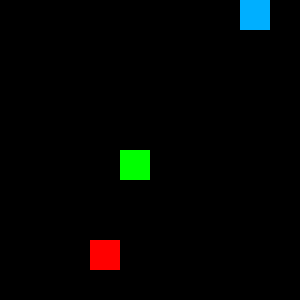

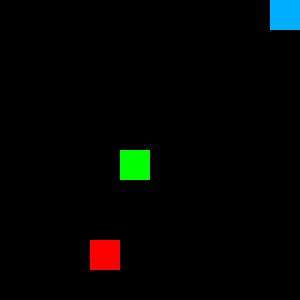

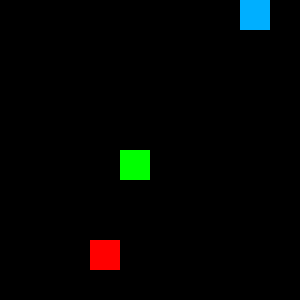

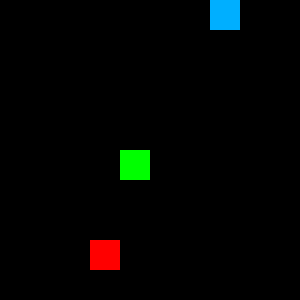

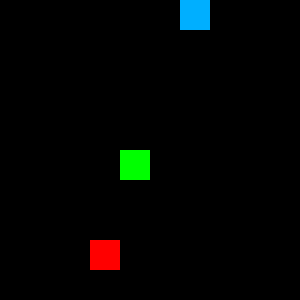

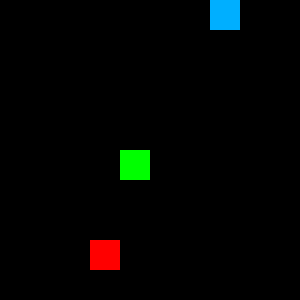

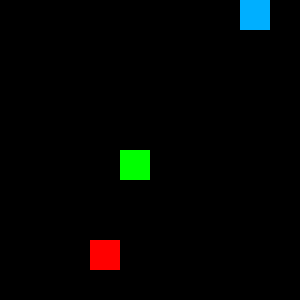

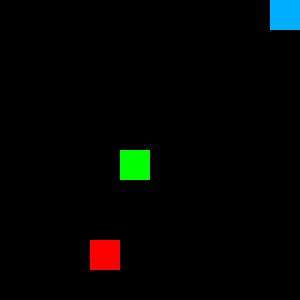

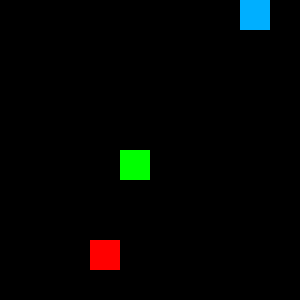

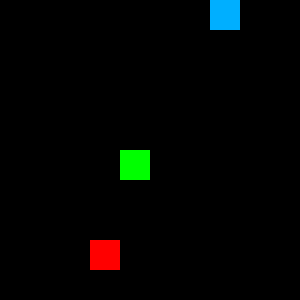

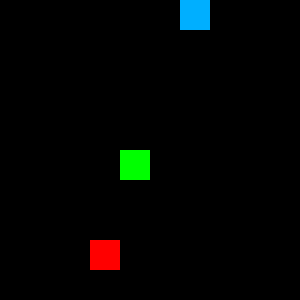

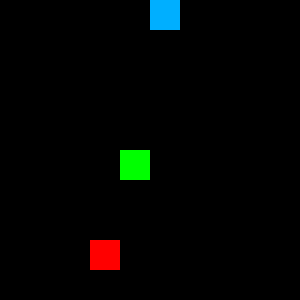

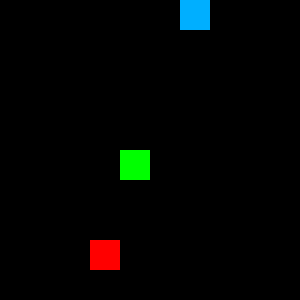

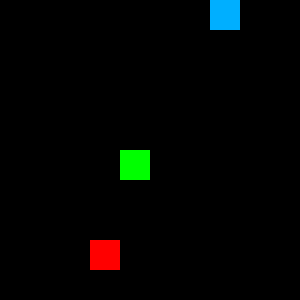

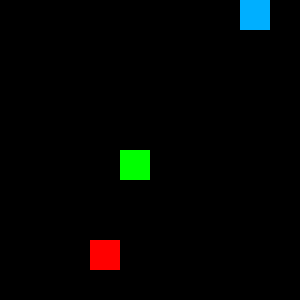

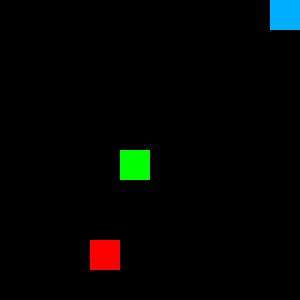

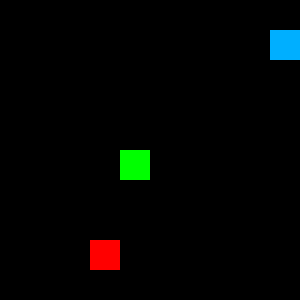

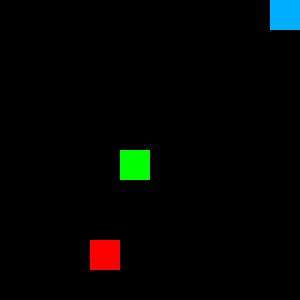

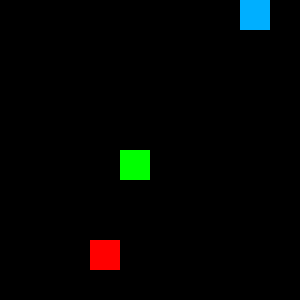

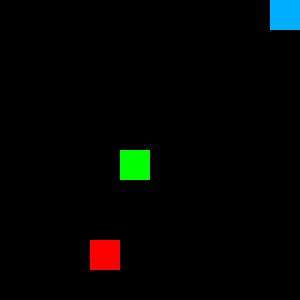

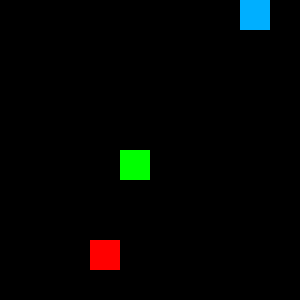

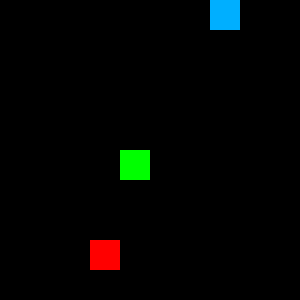

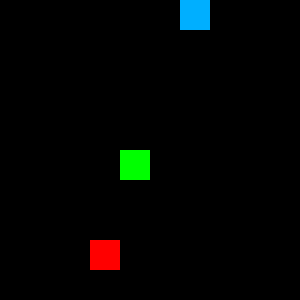

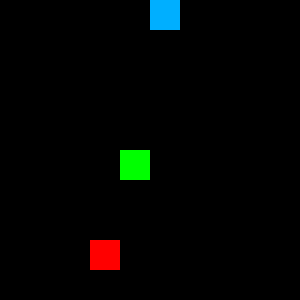

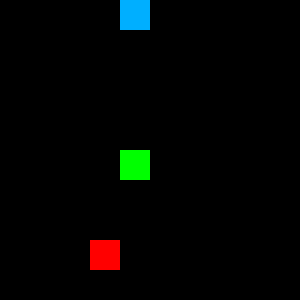

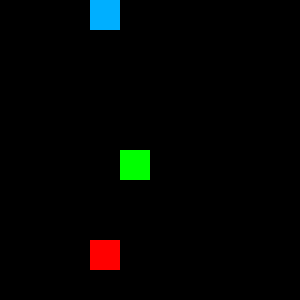

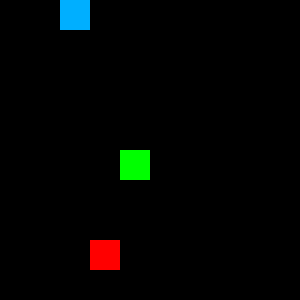

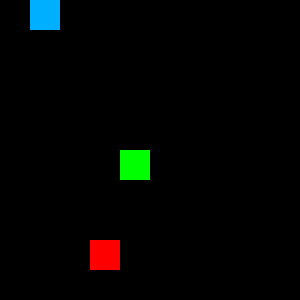

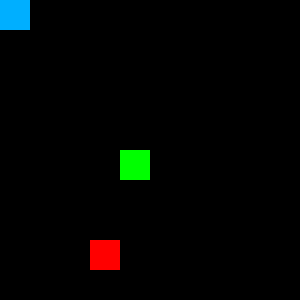

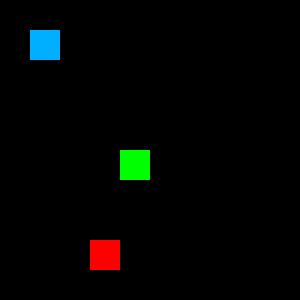

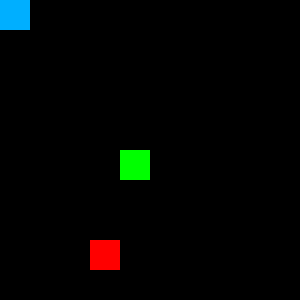

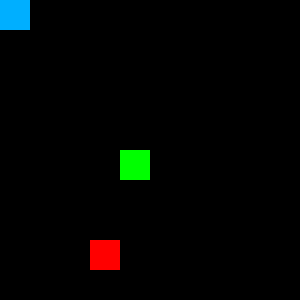

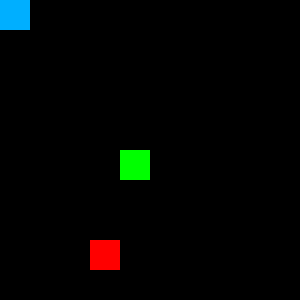

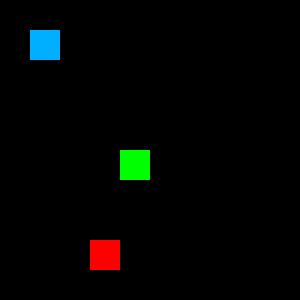

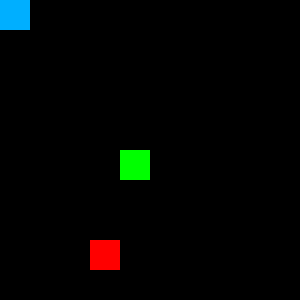

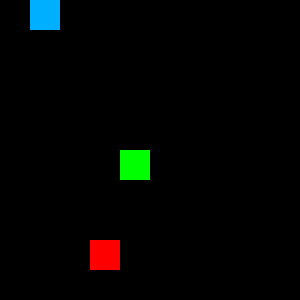

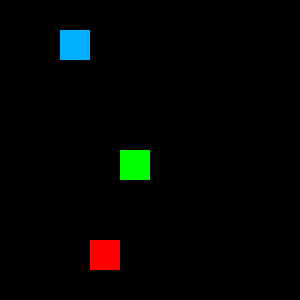

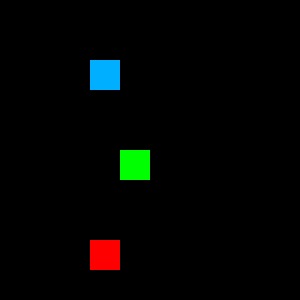

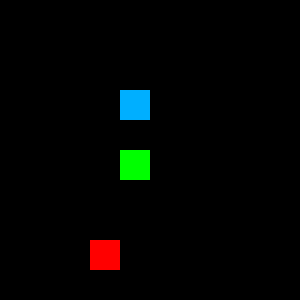

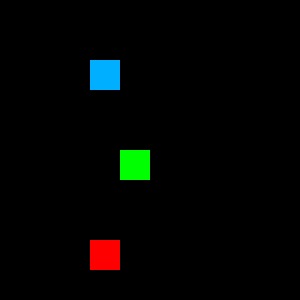

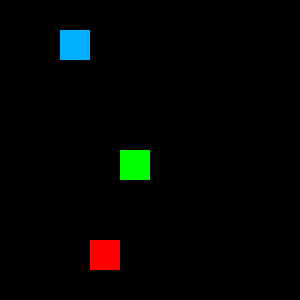

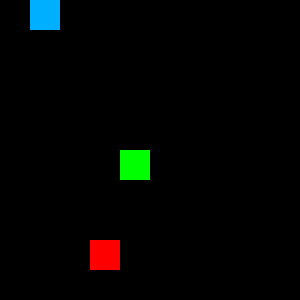

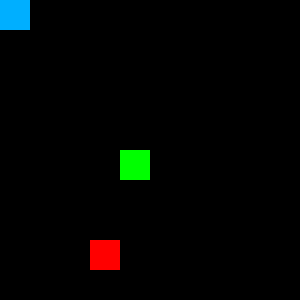

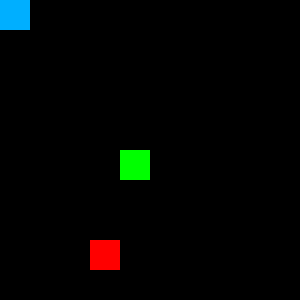

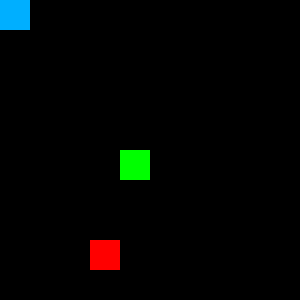

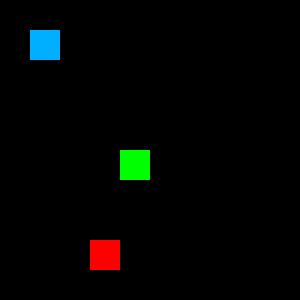

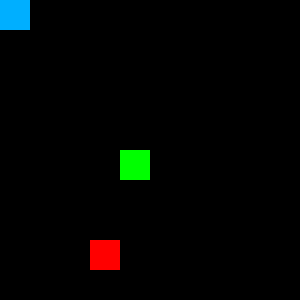

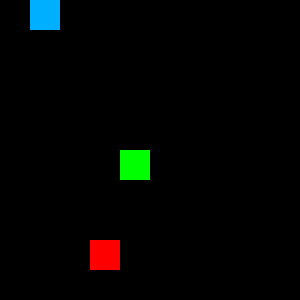

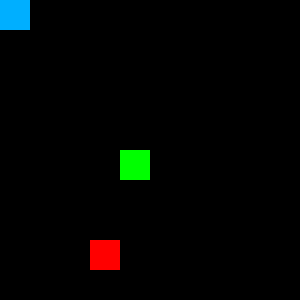

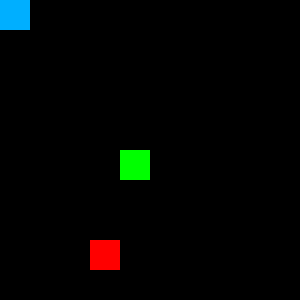

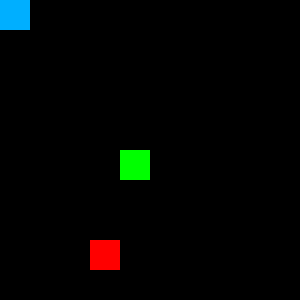

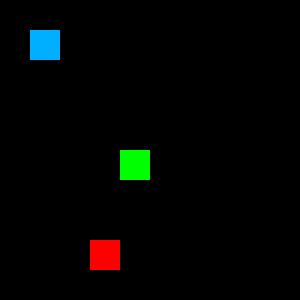

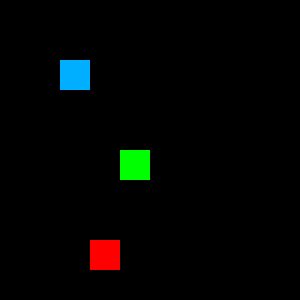

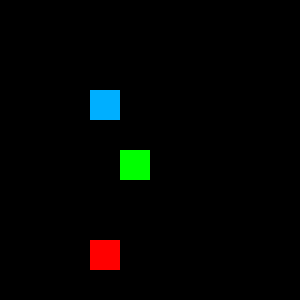

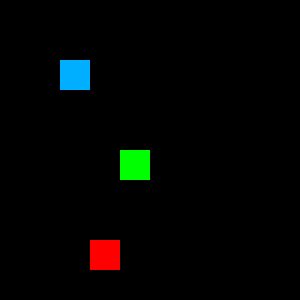

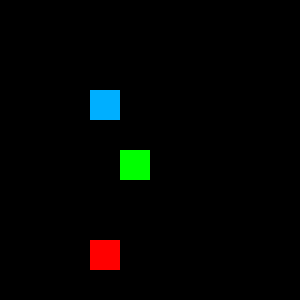

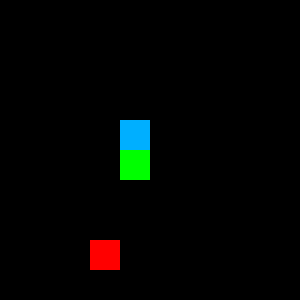

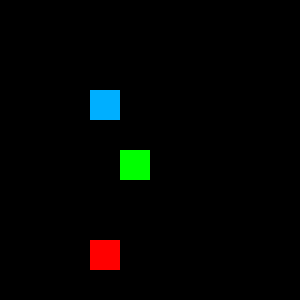

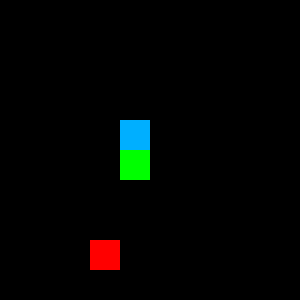

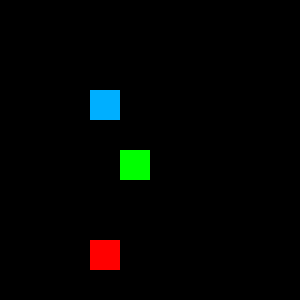

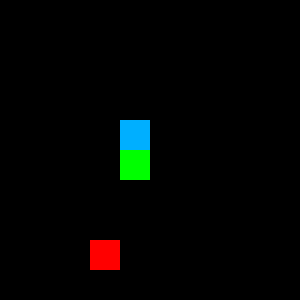

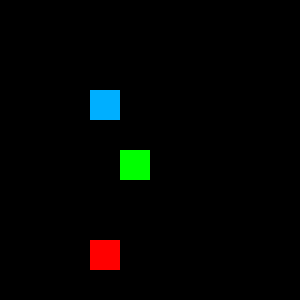

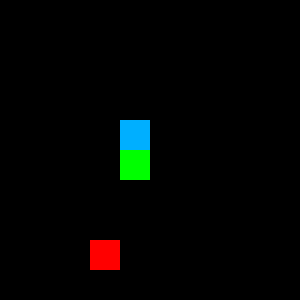

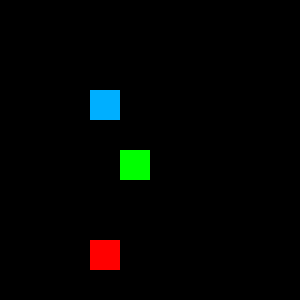

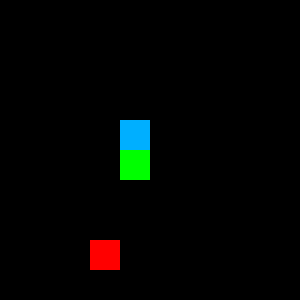

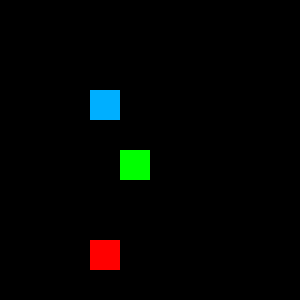

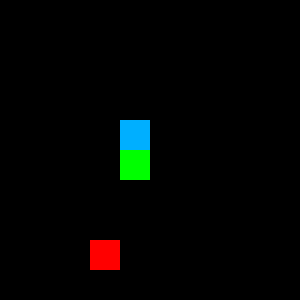

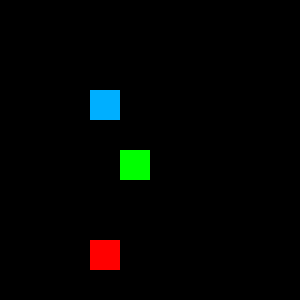

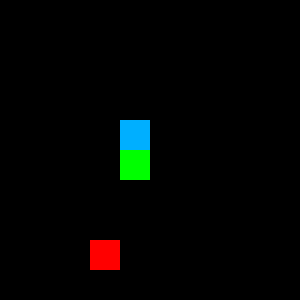

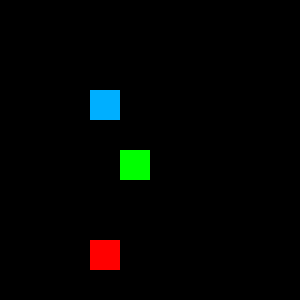

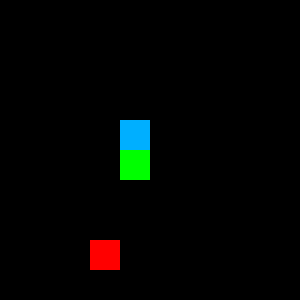

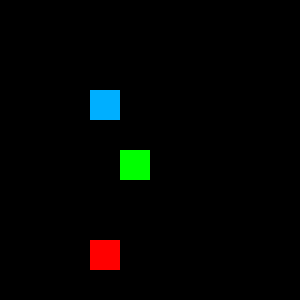

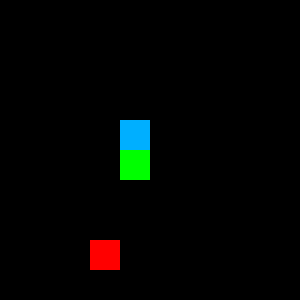

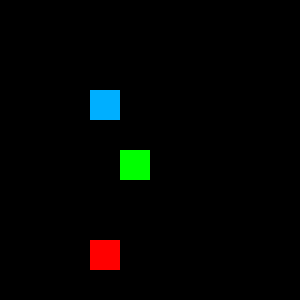

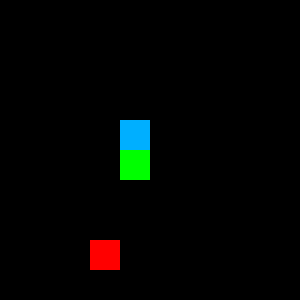

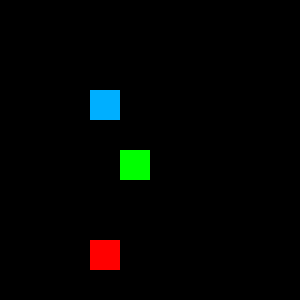

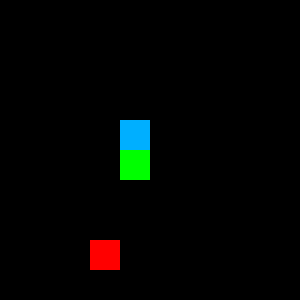

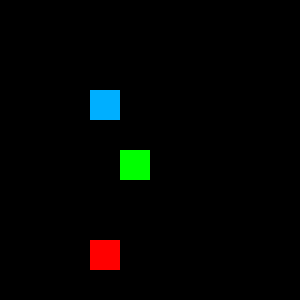

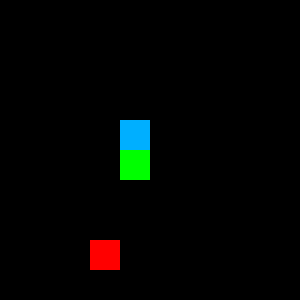

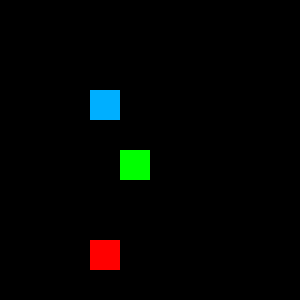

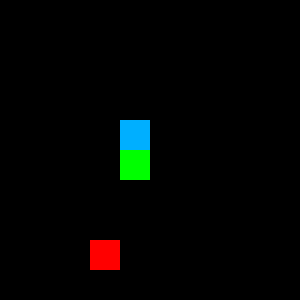

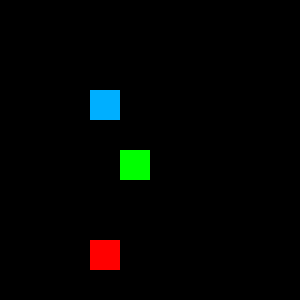

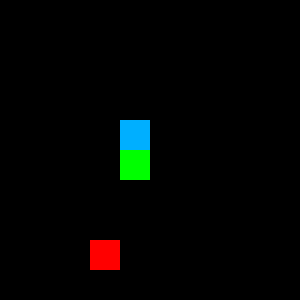

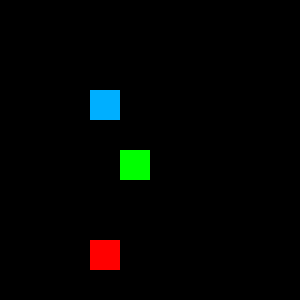

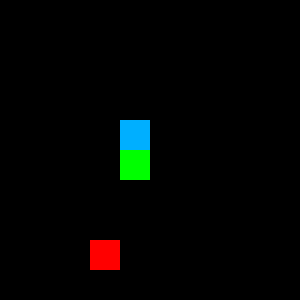

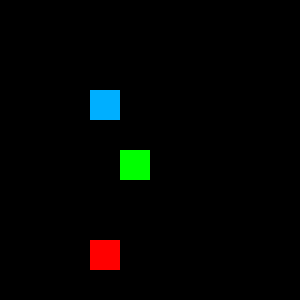

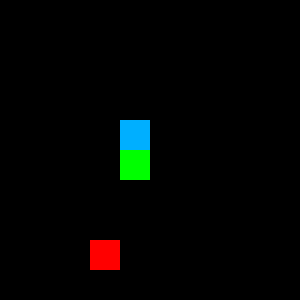

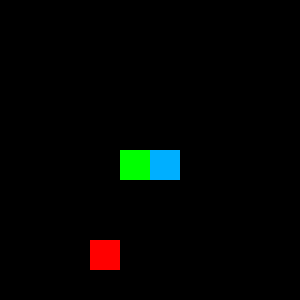

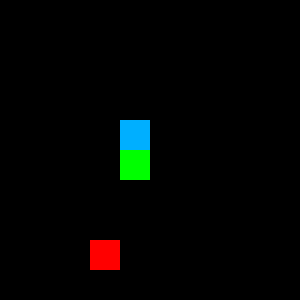

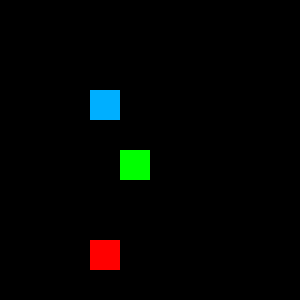

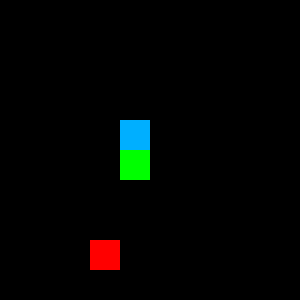

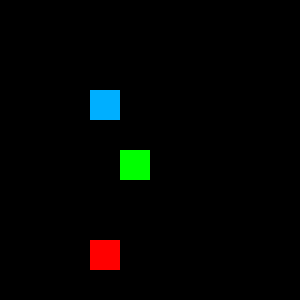

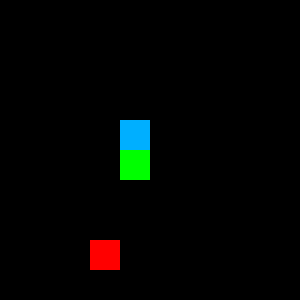

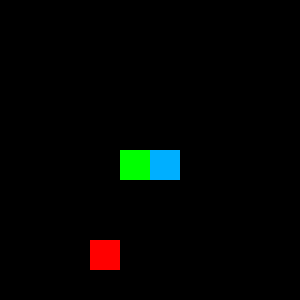

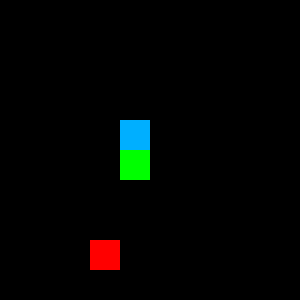

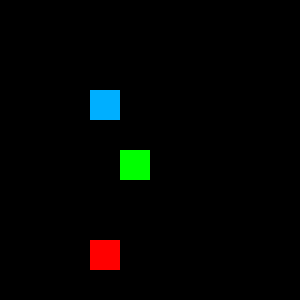

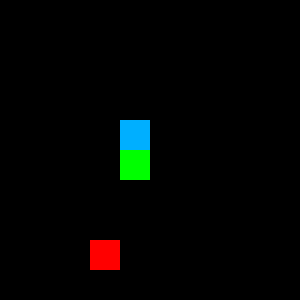

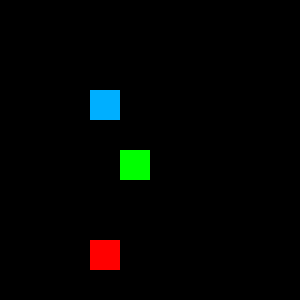

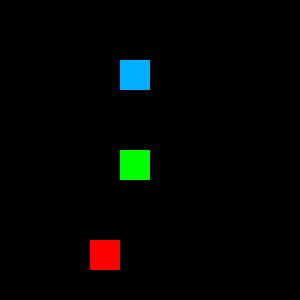

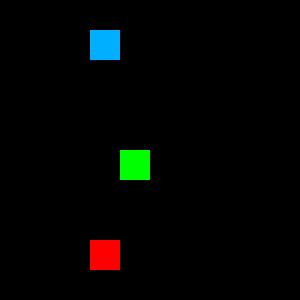

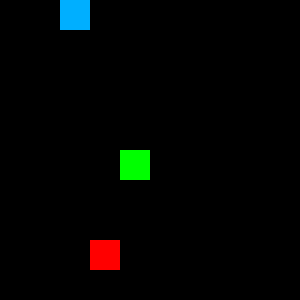

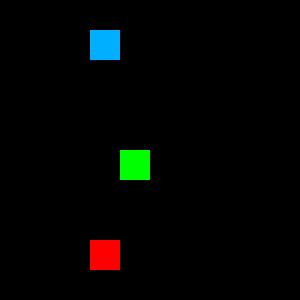

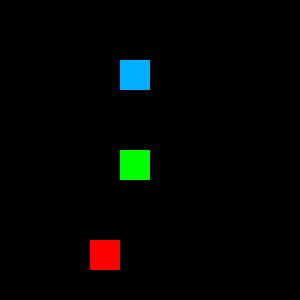

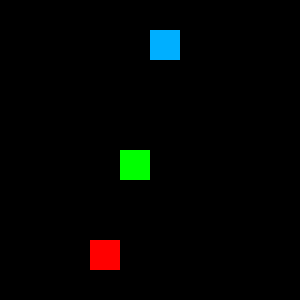

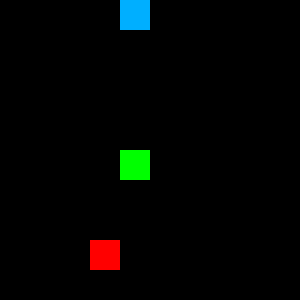

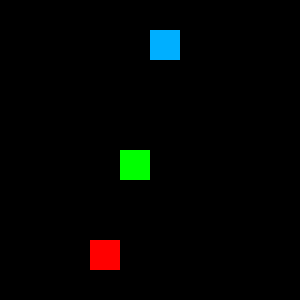

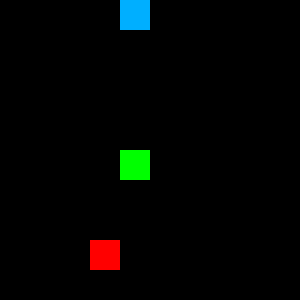

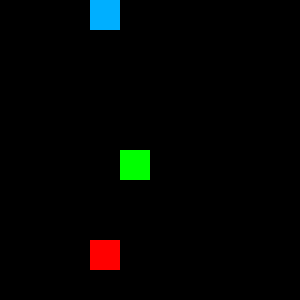

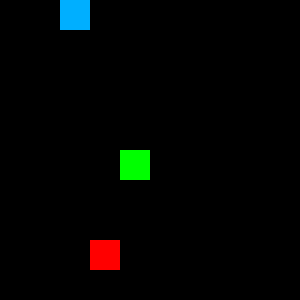

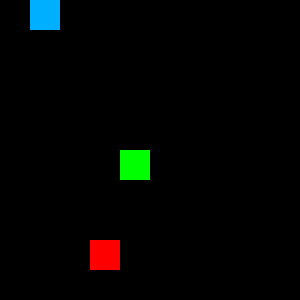

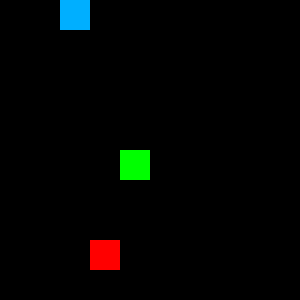

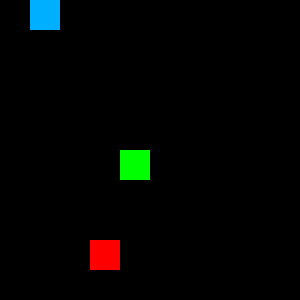

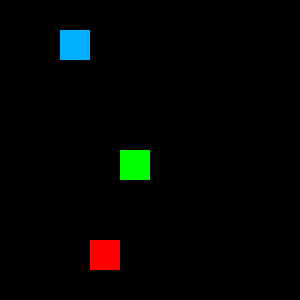

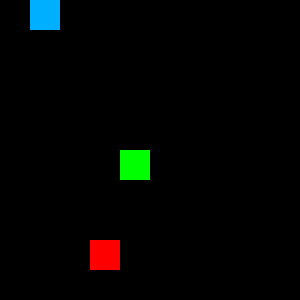

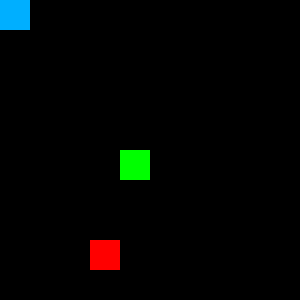

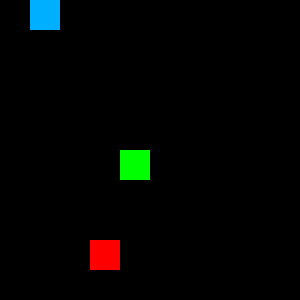

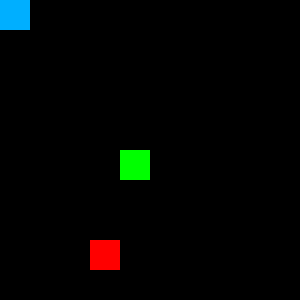

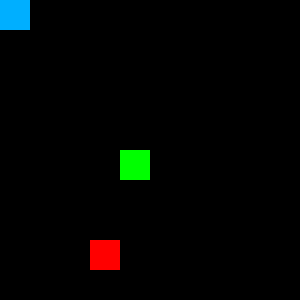

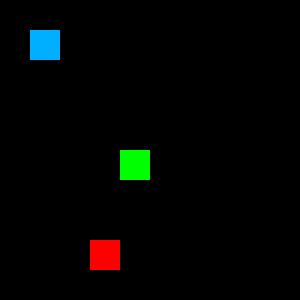

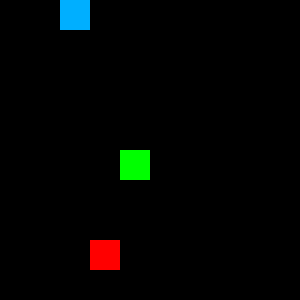

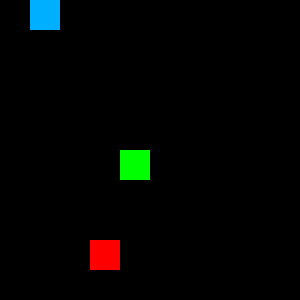

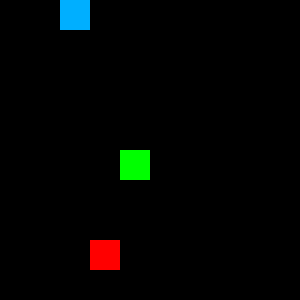

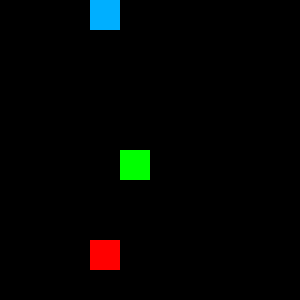

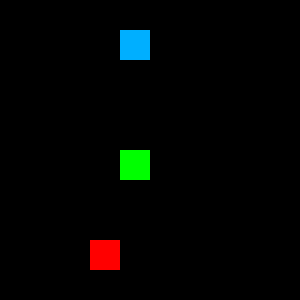

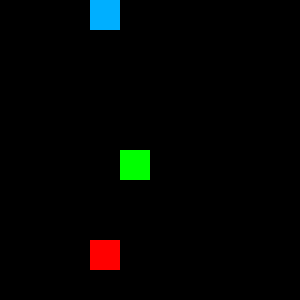

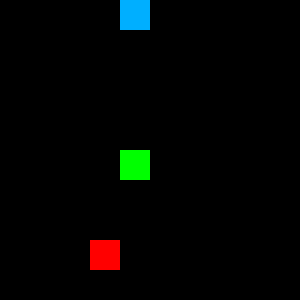

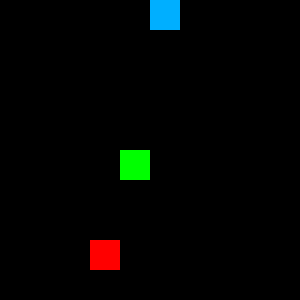

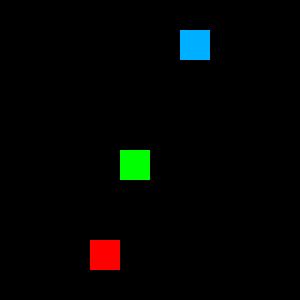

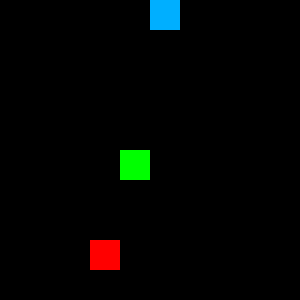

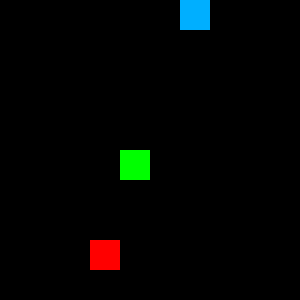

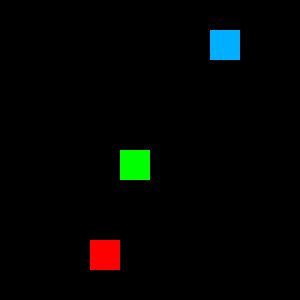

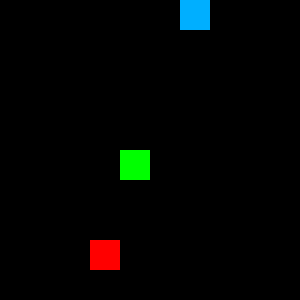

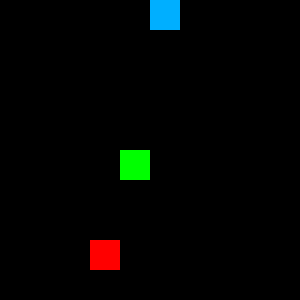

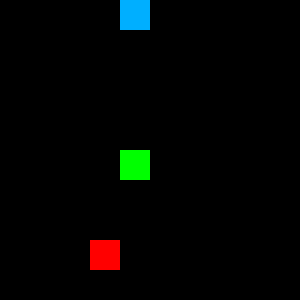

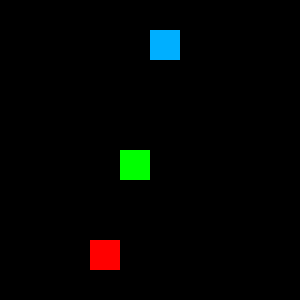

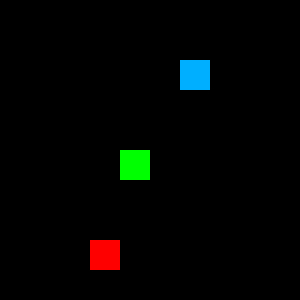

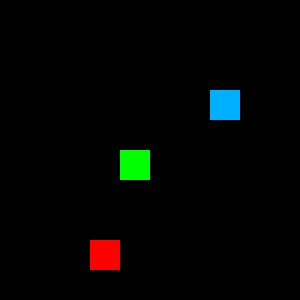

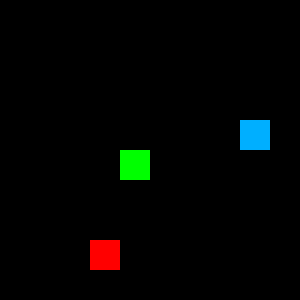

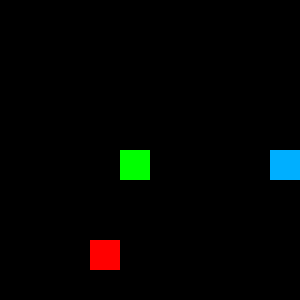

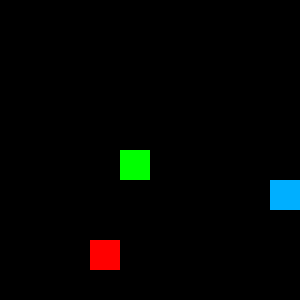

on #5000, epsilon is 1.355962562703553e-08
5000 ep mean: -128.566


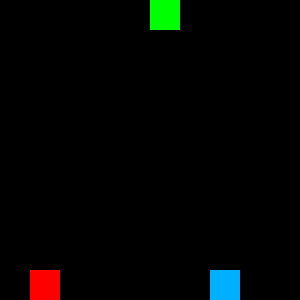

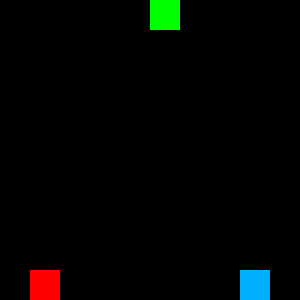

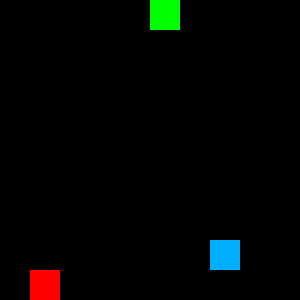

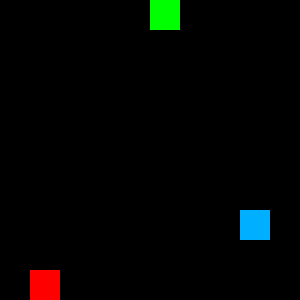

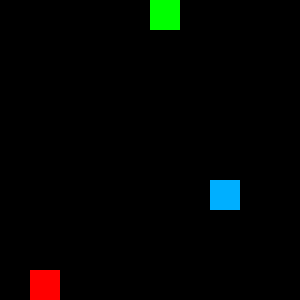

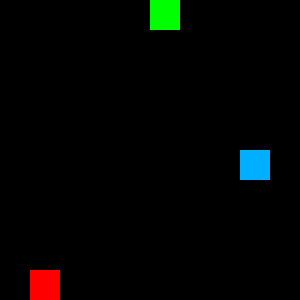

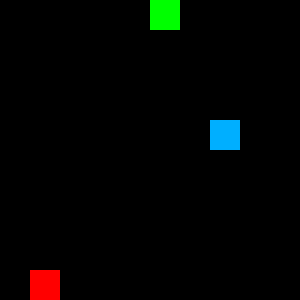

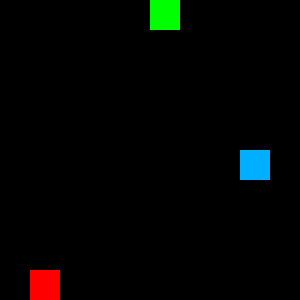

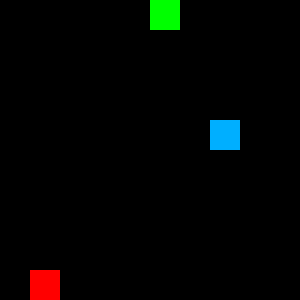

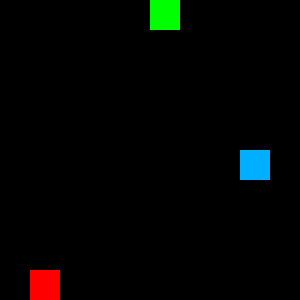

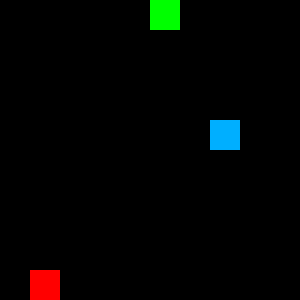

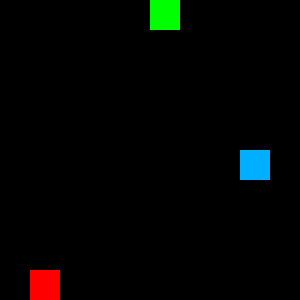

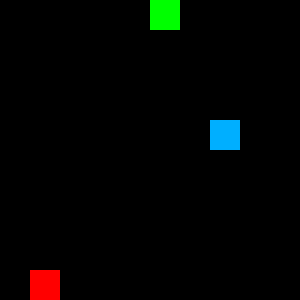

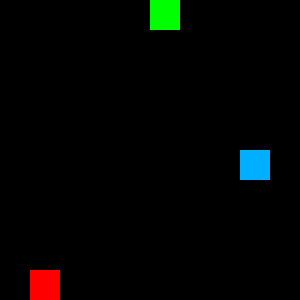

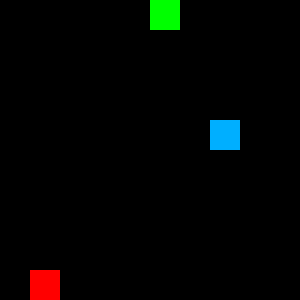

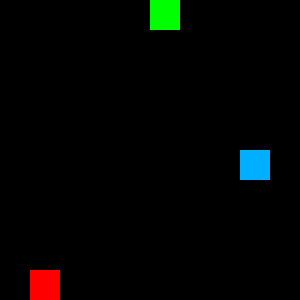

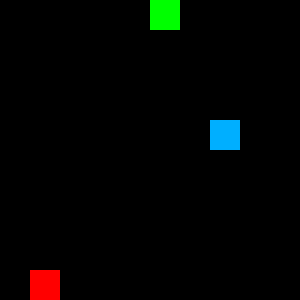

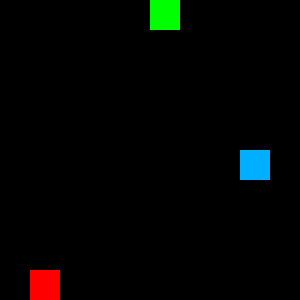

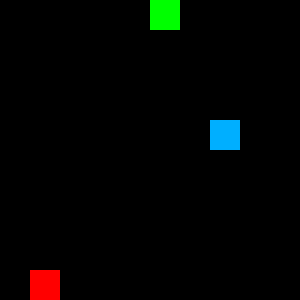

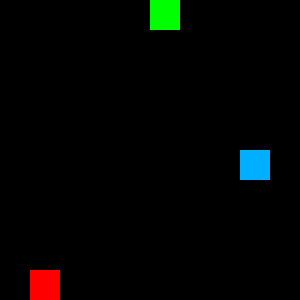

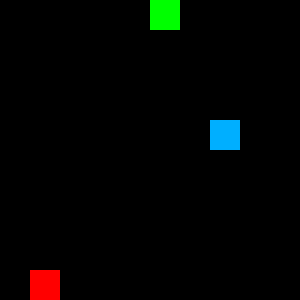

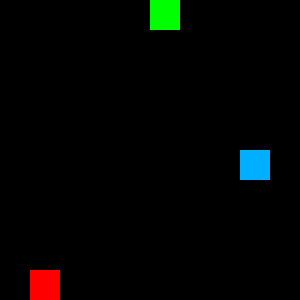

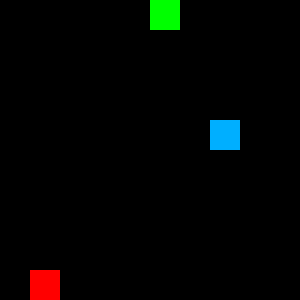

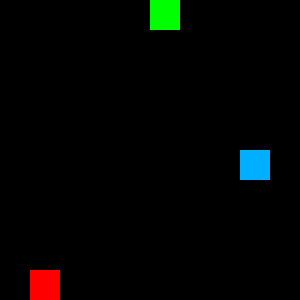

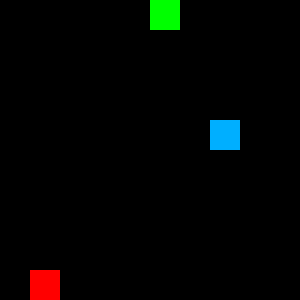

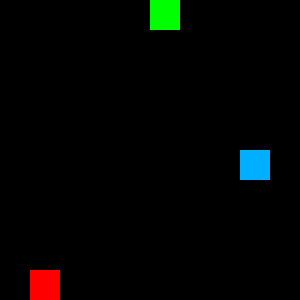

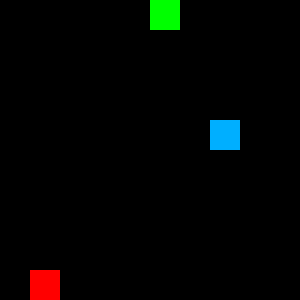

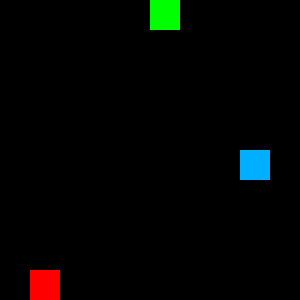

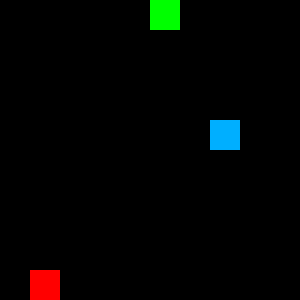

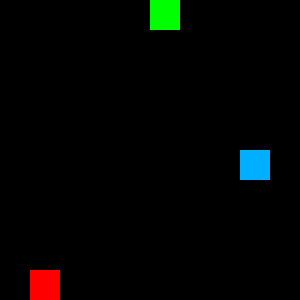

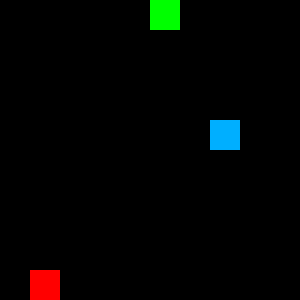

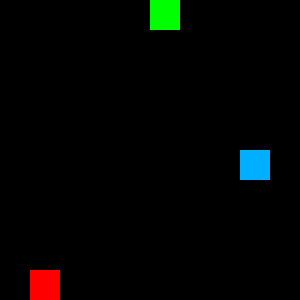

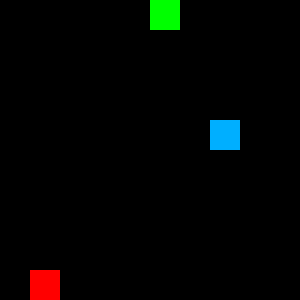

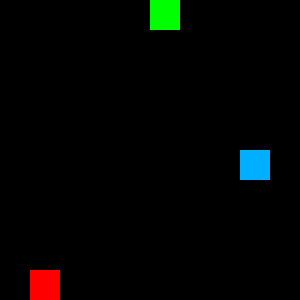

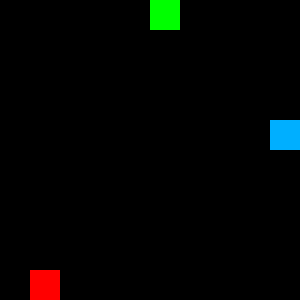

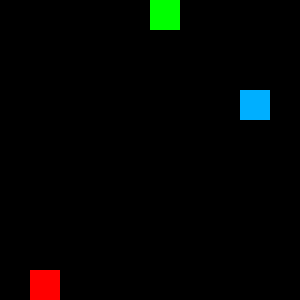

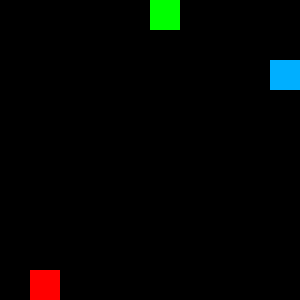

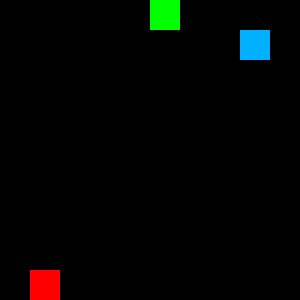

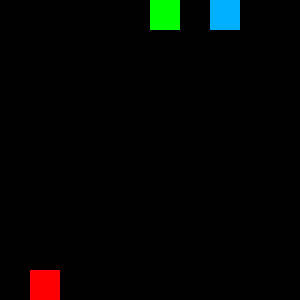

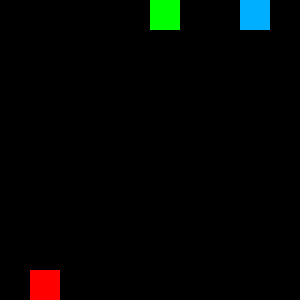

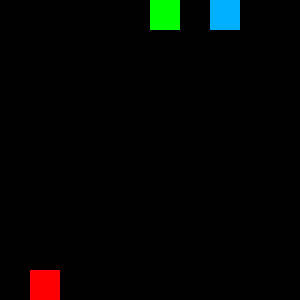

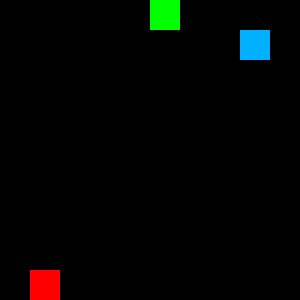

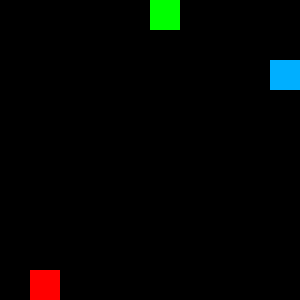

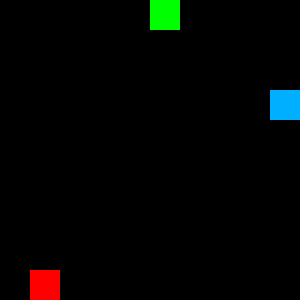

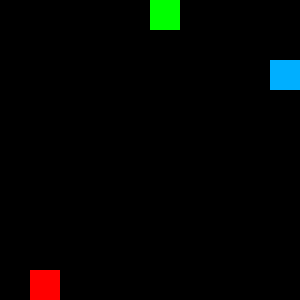

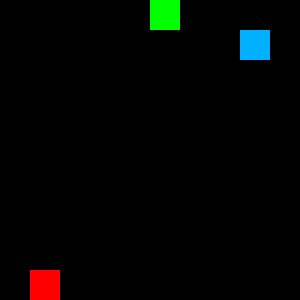

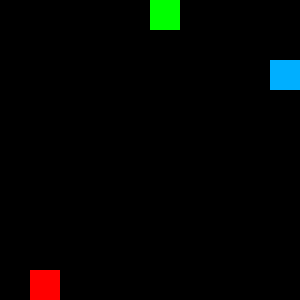

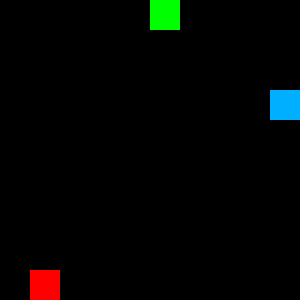

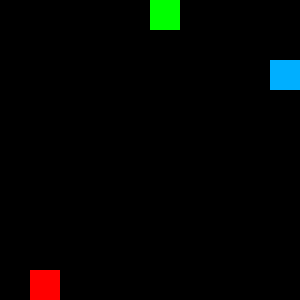

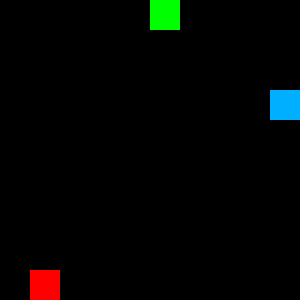

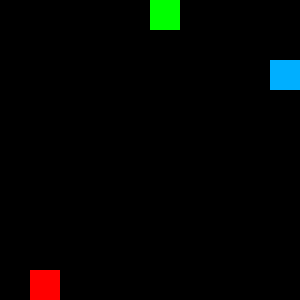

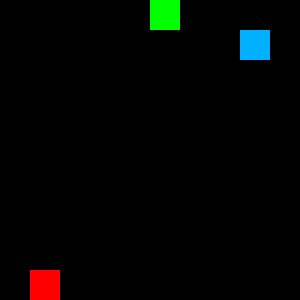

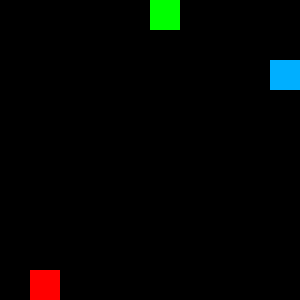

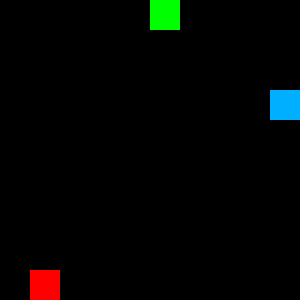

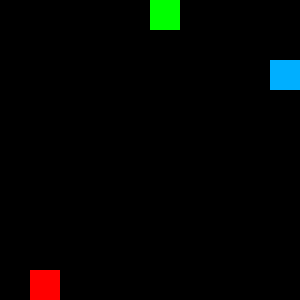

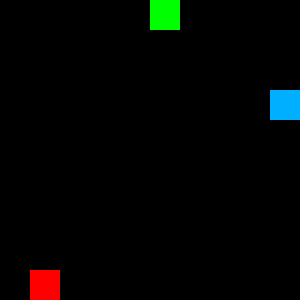

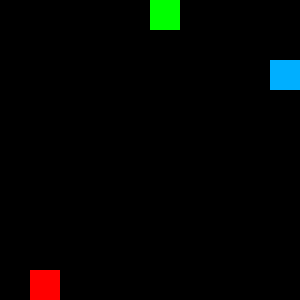

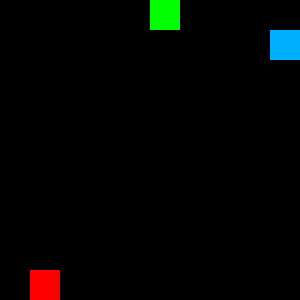

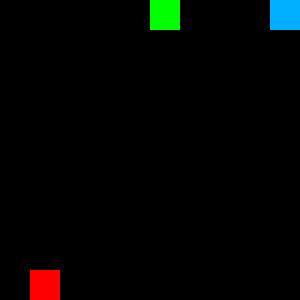

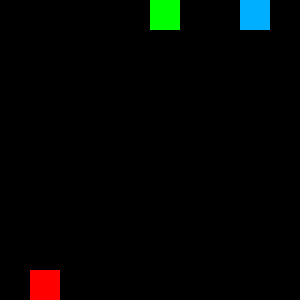

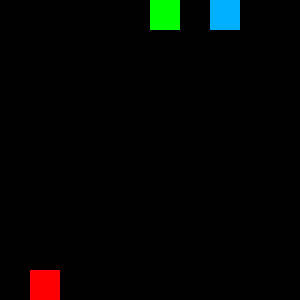

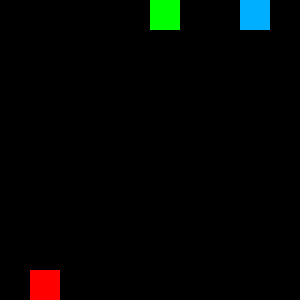

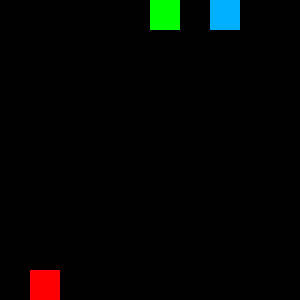

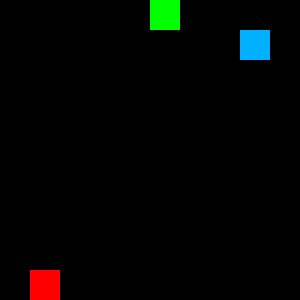

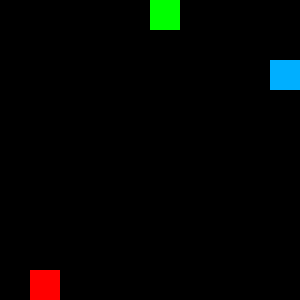

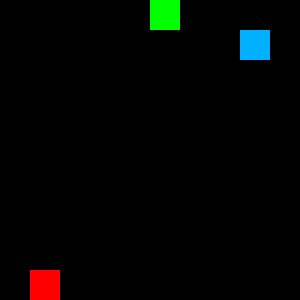

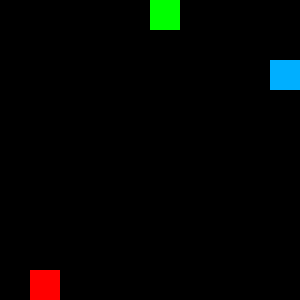

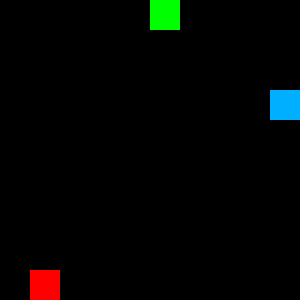

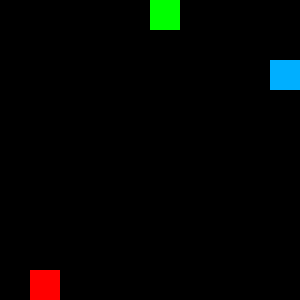

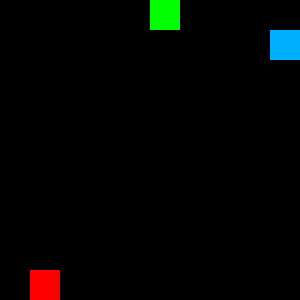

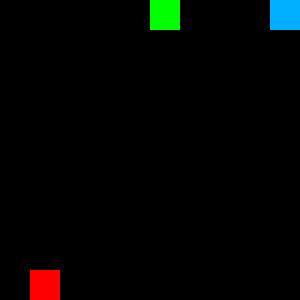

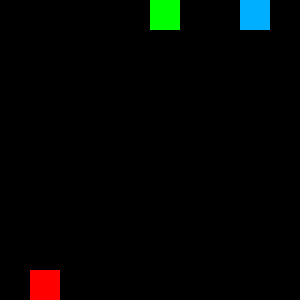

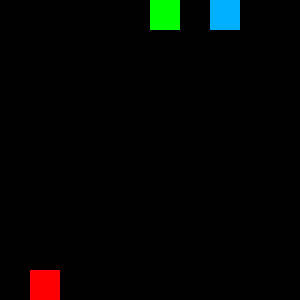

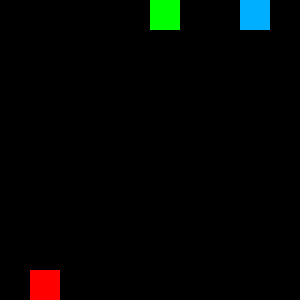

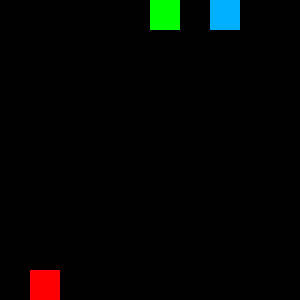

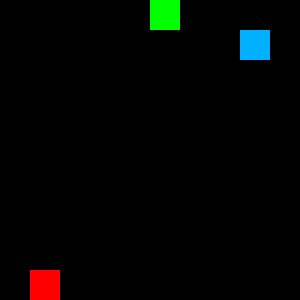

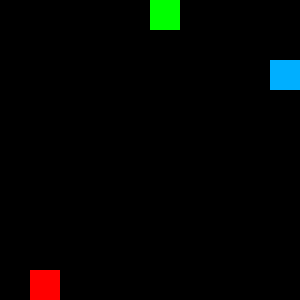

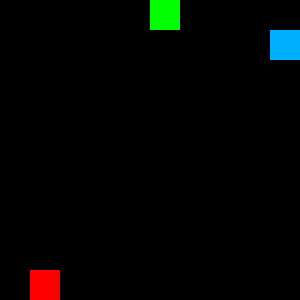

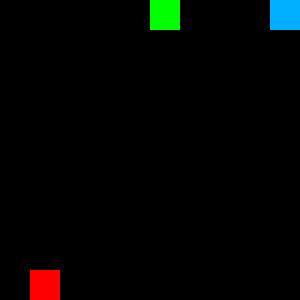

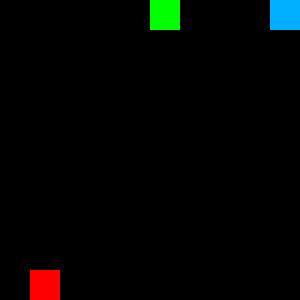

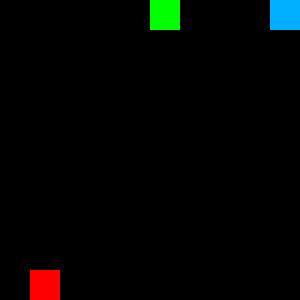

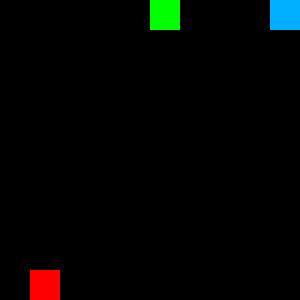

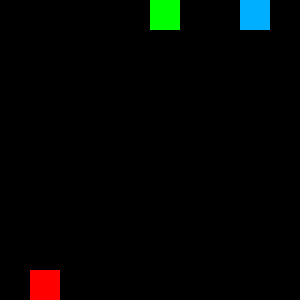

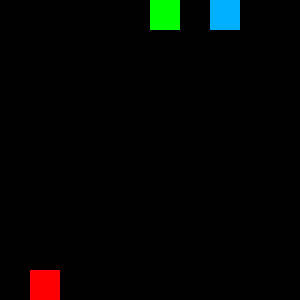

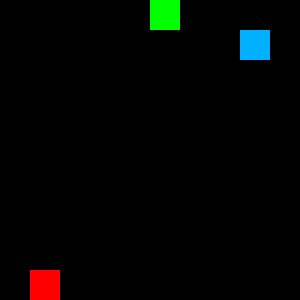

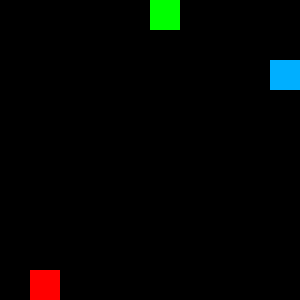

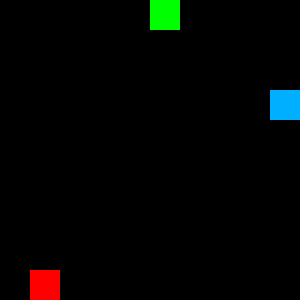

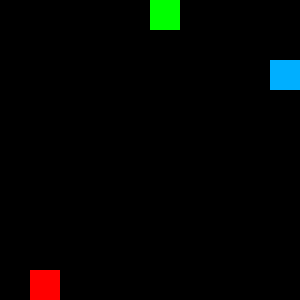

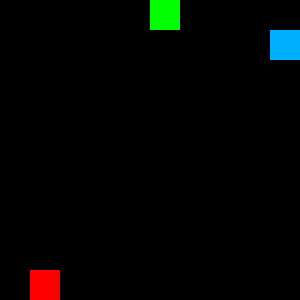

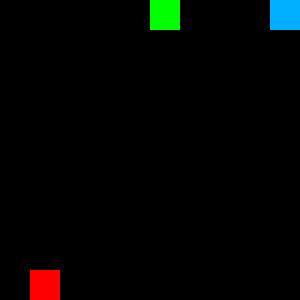

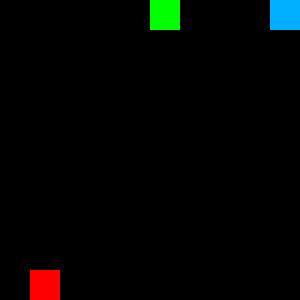

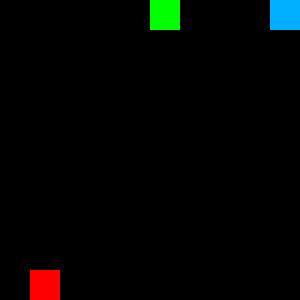

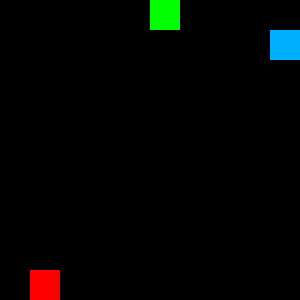

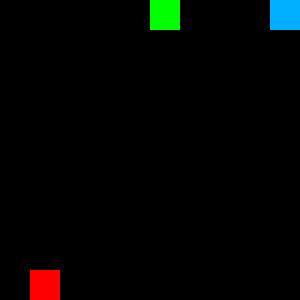

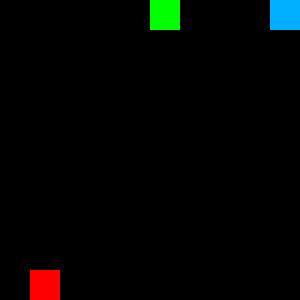

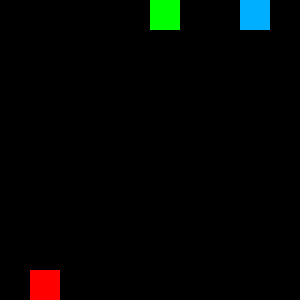

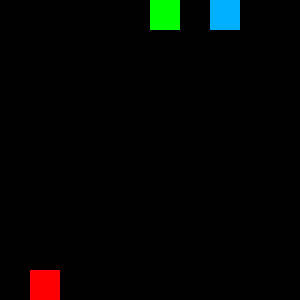

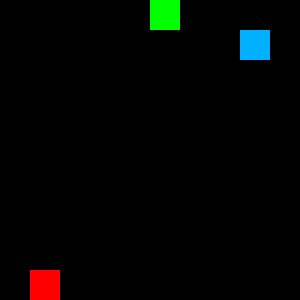

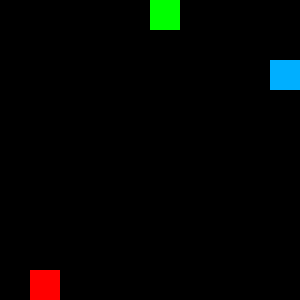

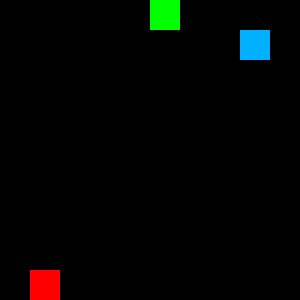

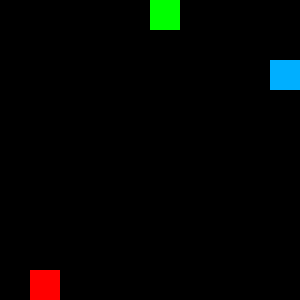

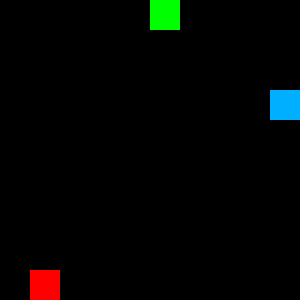

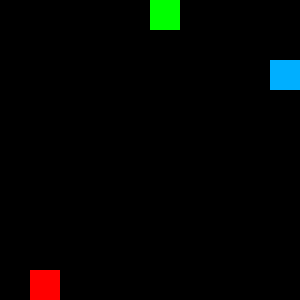

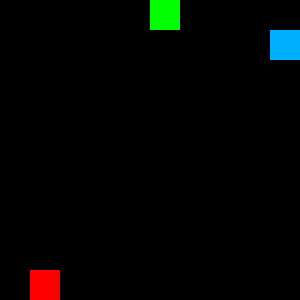

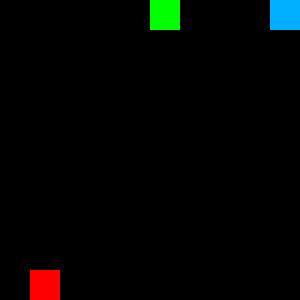

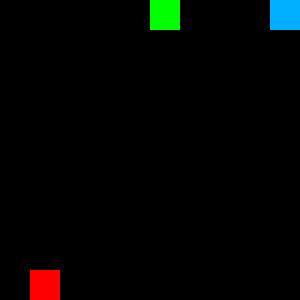

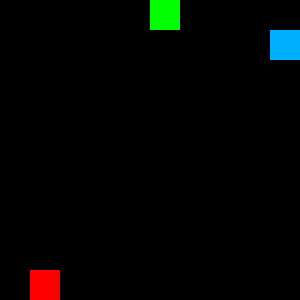

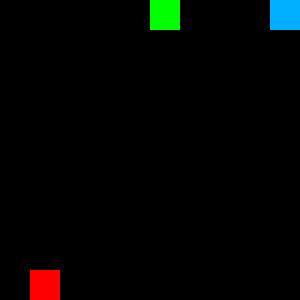

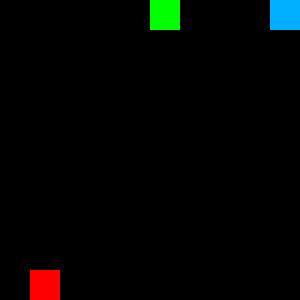

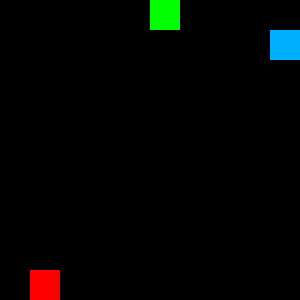

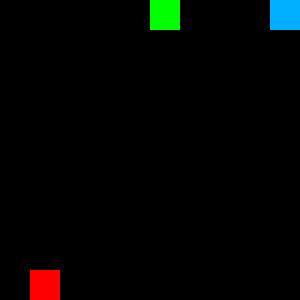

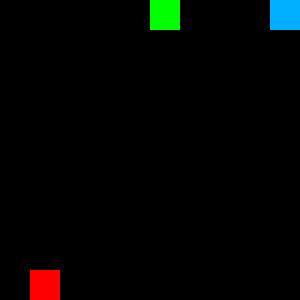

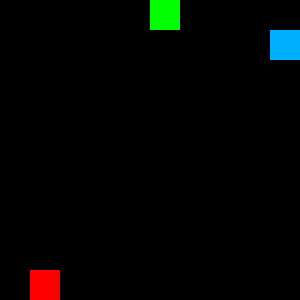

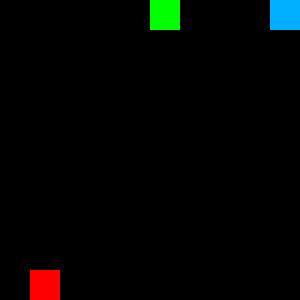

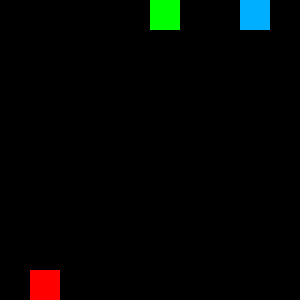

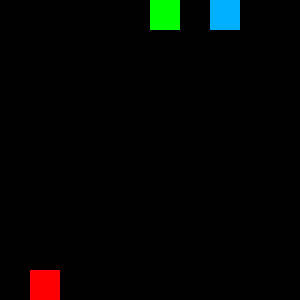

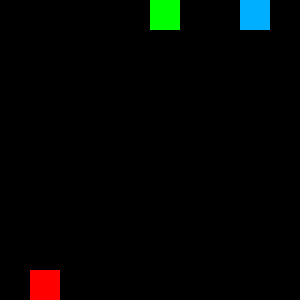

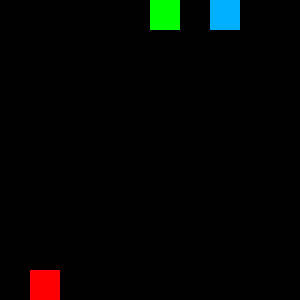

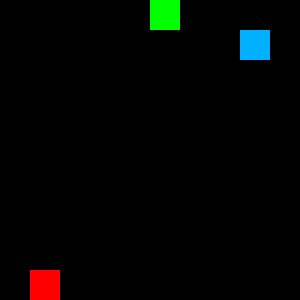

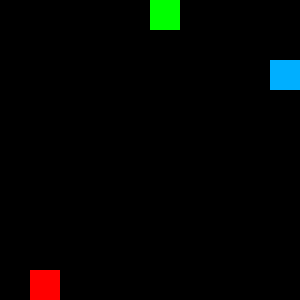

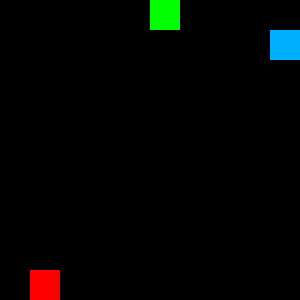

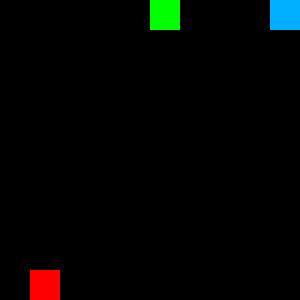

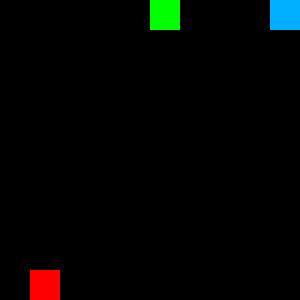

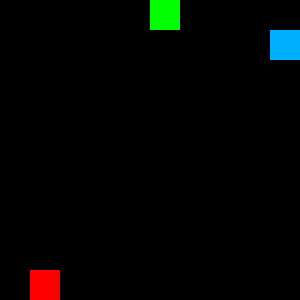

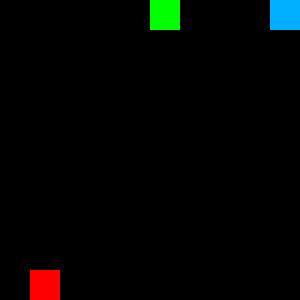

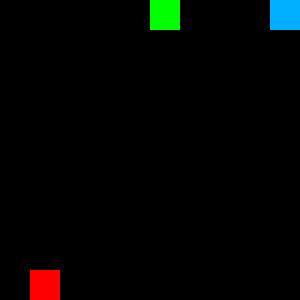

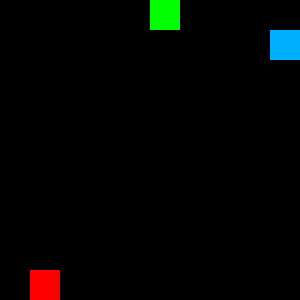

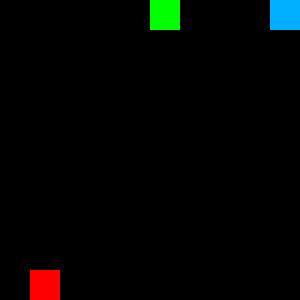

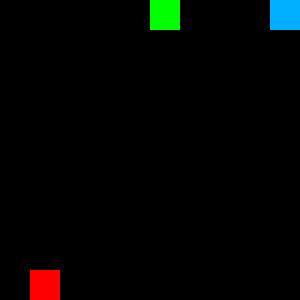

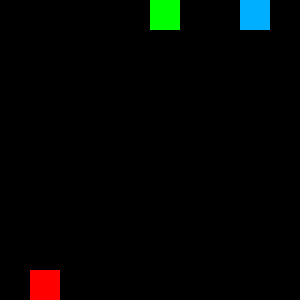

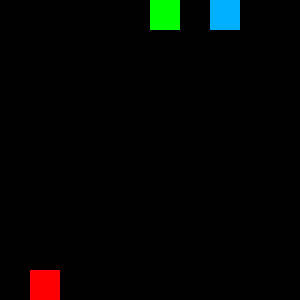

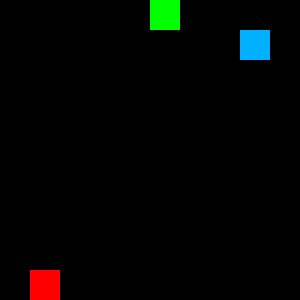

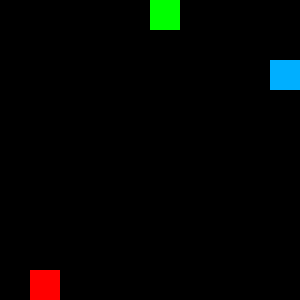

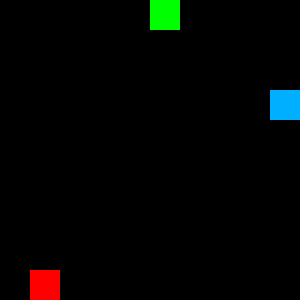

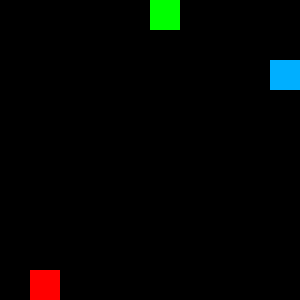

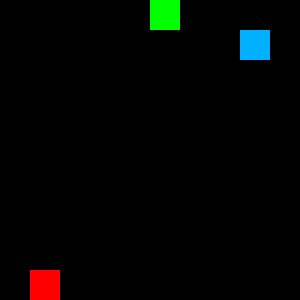

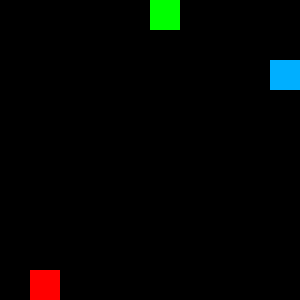

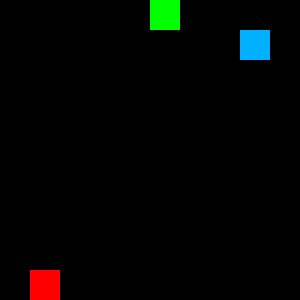

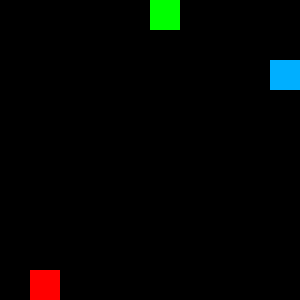

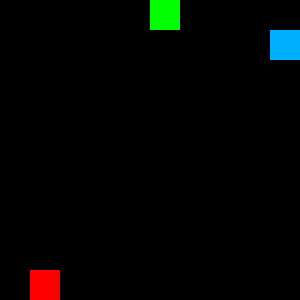

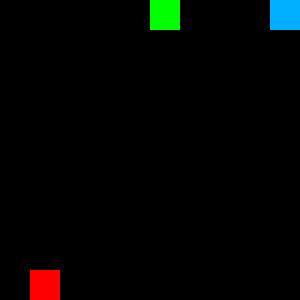

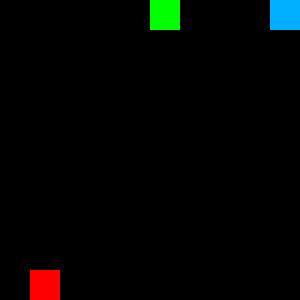

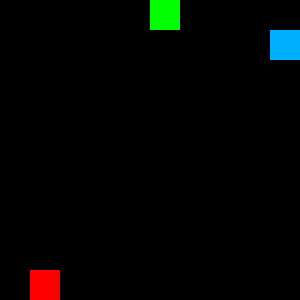

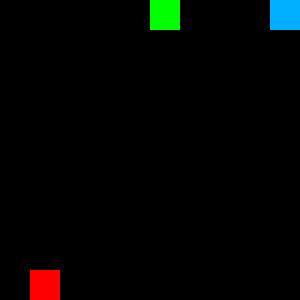

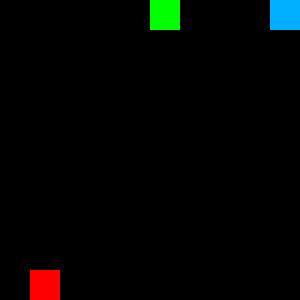

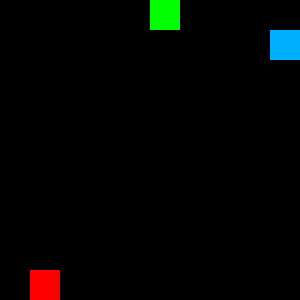

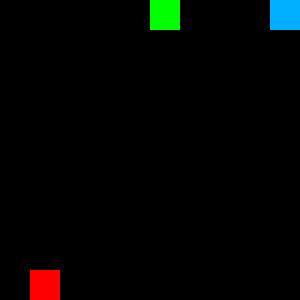

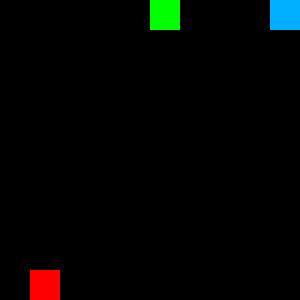

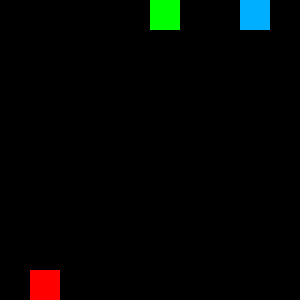

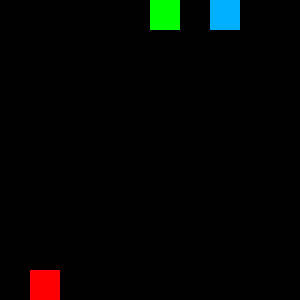

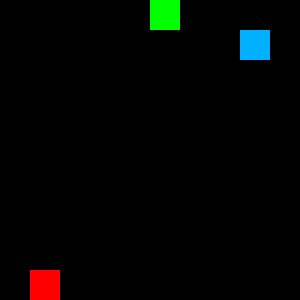

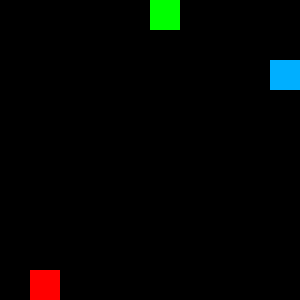

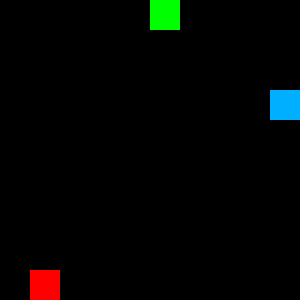

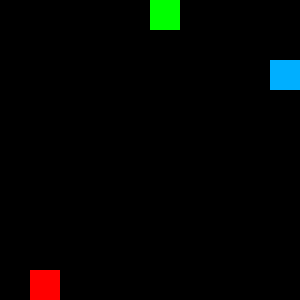

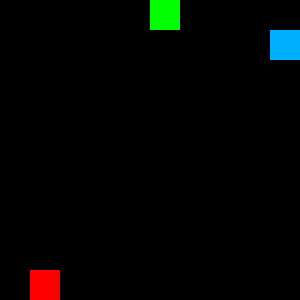

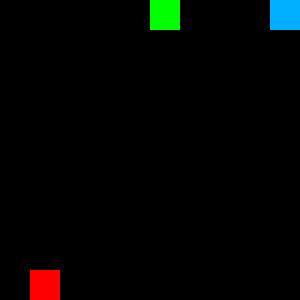

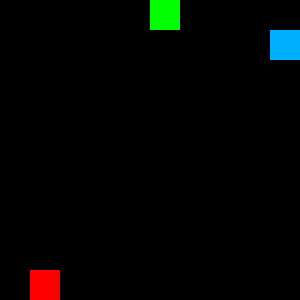

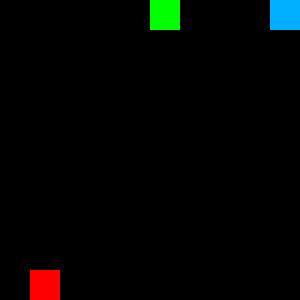

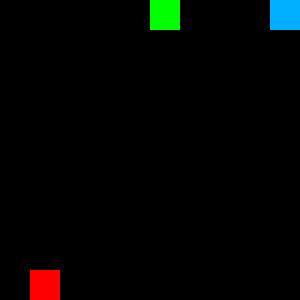

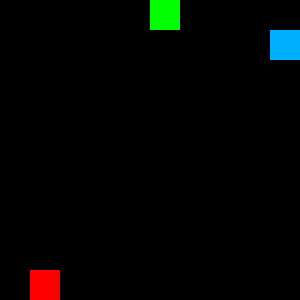

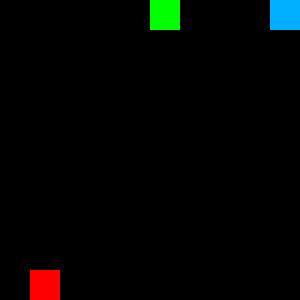

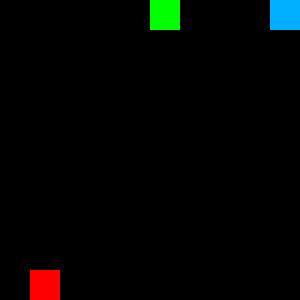

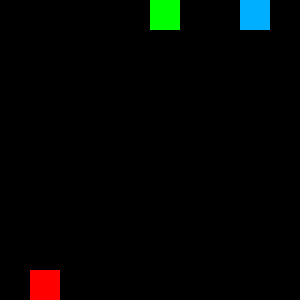

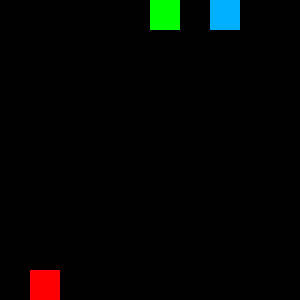

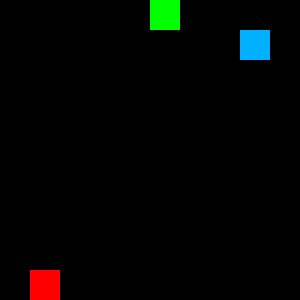

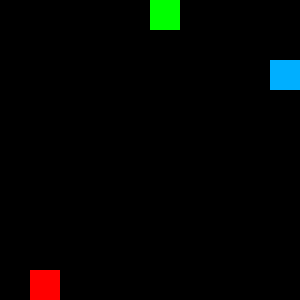

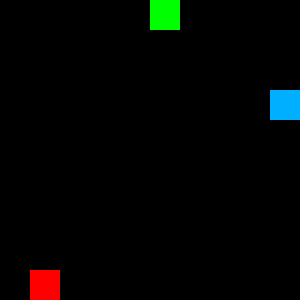

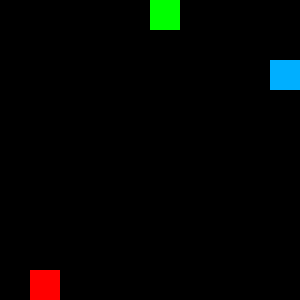

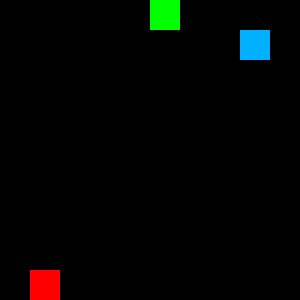

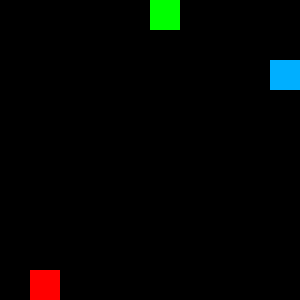

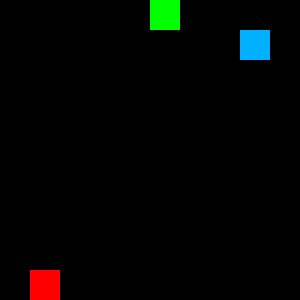

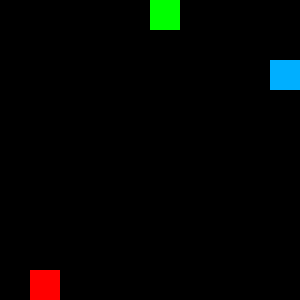

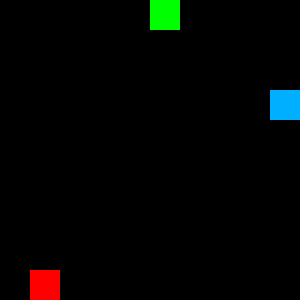

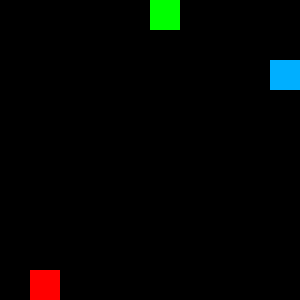

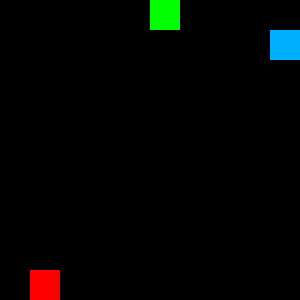

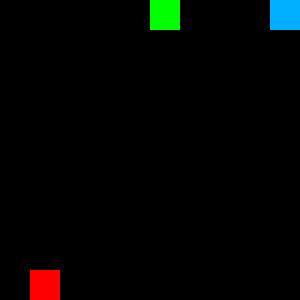

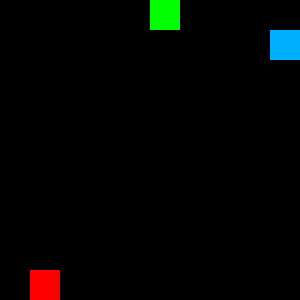

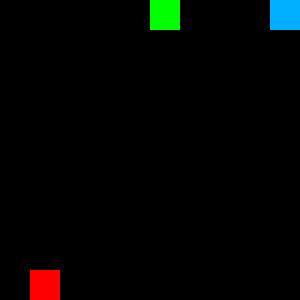

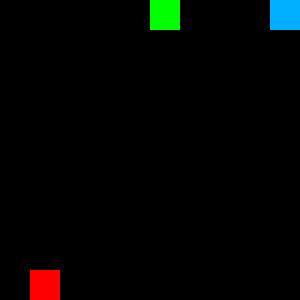

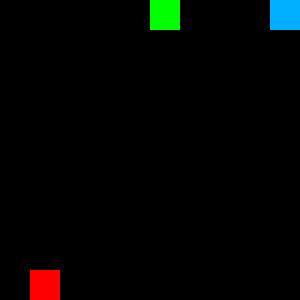

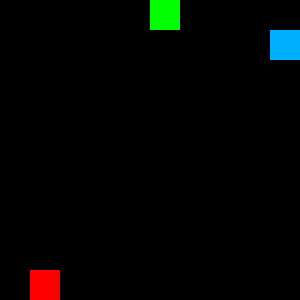

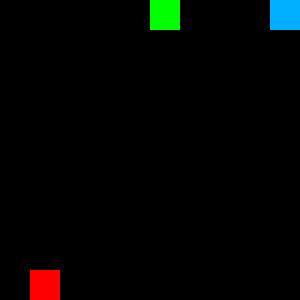

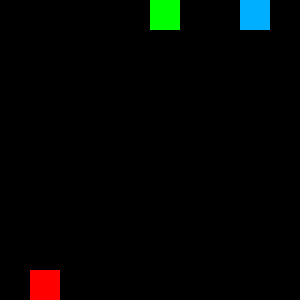

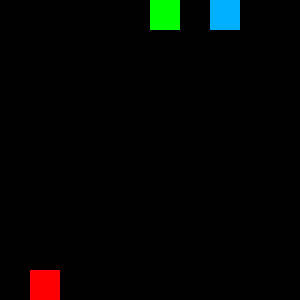

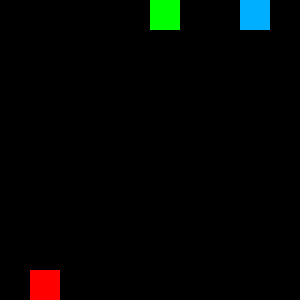

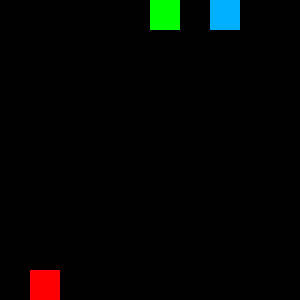

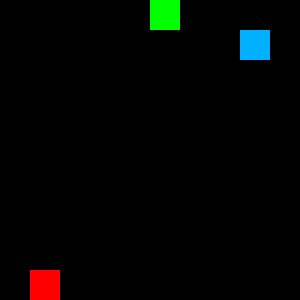

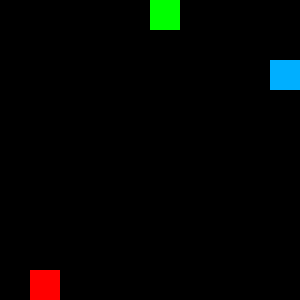

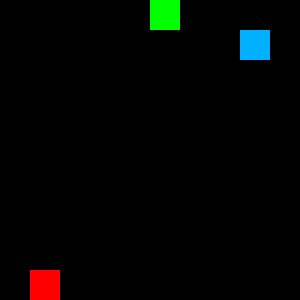

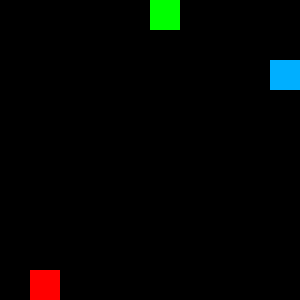

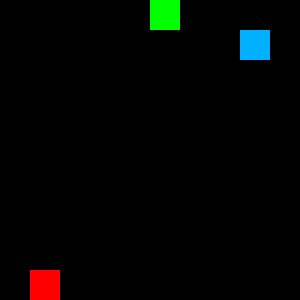

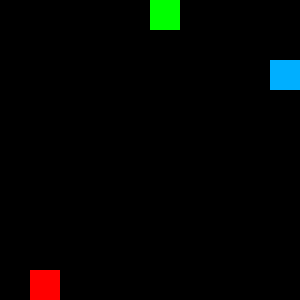

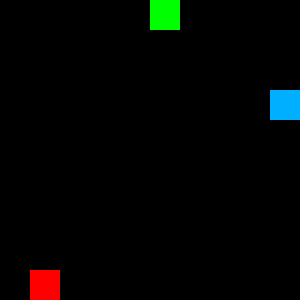

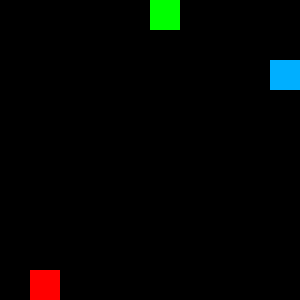

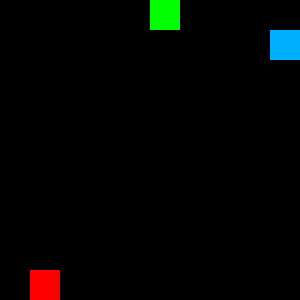

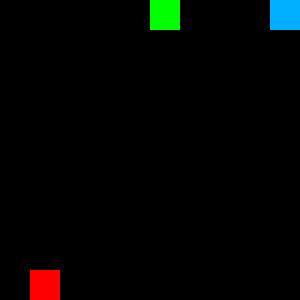

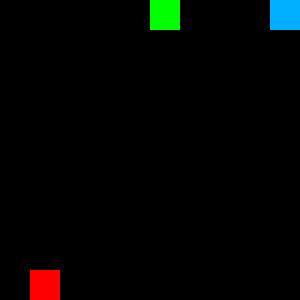

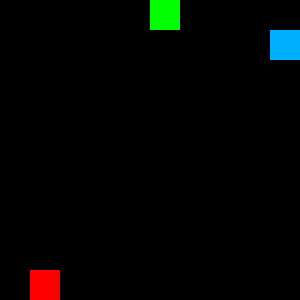

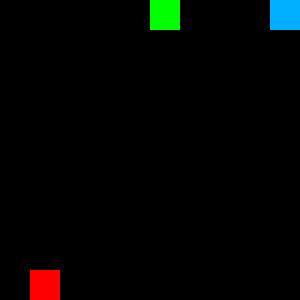

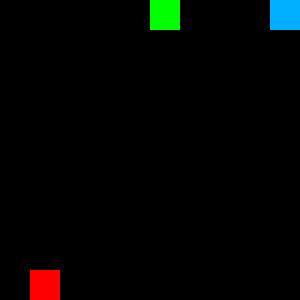

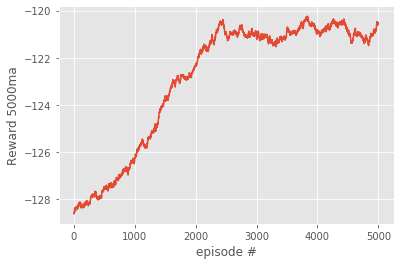

In [13]:
cv2.startWindowThread()

episode_rewards = []

for episode in range(HM_EPISODES):
    player = Blob()
    food = Blob()
    enemy = Blob()
    
    if episode % SHOW_EVERY == 0:
        print(f"on #{episode}, epsilon is {epsilon}")
        print(f"{SHOW_EVERY} ep mean: {np.mean(episode_rewards[-SHOW_EVERY:])}")
        show = True
    else:
        show = False

    episode_reward = 0
    
    for i in range(200):
        obs = (player-food, player-enemy)
        # print(obs)
        if np.random.random() > epsilon:
            # GET THE ACTION
            action = np.argmax(q_table[obs])
        else:
            action = np.random.randint(0, 4)
        # Take the action!
        player.action(action)

        if player.x == enemy.x and player.y == enemy.y:
            reward = -ENEMY_PENALTY

        elif player.x == food.x and player.y == food.y:
            reward = FOOD_REWARD

        else:
            reward = -MOVE_PENALTY

        ## NOW WE KNOW THE REWARD, LET'S CALC YO
        # first we need to obs immediately after the move.

        new_obs = (player-food, player-enemy)  # new observation
        max_future_q = np.max(q_table[new_obs])  # max Q value for this new obs
        current_q = q_table[obs][action]  # current Q for our chosen action

        if reward == FOOD_REWARD:
            new_q = FOOD_REWARD
        elif reward == -ENEMY_PENALTY:
            new_q = -ENEMY_PENALTY
        else:
            new_q = (1 - LEARNING_RATE) * current_q + LEARNING_RATE*(reward + DISCOUNT*max_future_q)

        q_table[obs][action] = new_q

        if show:
            env = np.zeros((SIZE, SIZE, 3), dtype=np.uint8)  # starts an rbg of our size
            env[food.y][food.x] = d[FOOD_N]  # sets the food location tile to green color
            env[player.y][player.x] = d[PLAYER_N]  # sets the player tile to blue
            env[enemy.y][enemy.x] = d[ENEMY_N]  # sets the enemy location to red
            img = Image.fromarray(env, 'RGB')  # reading to rgb. Apparently. Even tho color definitions are bgr. ???
            img = img.resize((300, 300))  # resizing so we can see our agent in all its glory.
            cv2_imshow(np.array(img))  # show it!
            if reward == FOOD_REWARD or reward == -ENEMY_PENALTY:  # crummy code to hang at the end if we reach abrupt end for good reasons or not.
                if cv2.waitKey(500) & 0xFF == ord('q'):
                    break
            else:
                if cv2.waitKey(1) & 0xFF == ord('q'):
                    break
            
        episode_reward += reward

        if reward == FOOD_REWARD or reward == -ENEMY_PENALTY: #if we either reached objective or hit our enemy
          break

    #print(episode_reward)
    episode_rewards.append(episode_reward)
    epsilon *= EPS_DECAY


# plotting rewards
moving_avg = np.convolve(episode_rewards, np.ones((SHOW_EVERY,))/SHOW_EVERY, mode='valid')

plt.plot([i for i in range(len(moving_avg))], moving_avg)
plt.ylabel(f"Reward {SHOW_EVERY}ma")
plt.xlabel("episode #")
plt.show()


with open(f"qtable-{int(time.time())}.pickle", "wb") as f:
    pickle.dump(q_table, f)

출처

https://youtu.be/G92TF4xYQcU?list=PLQVvvaa0QuDezJFIOU5wDdfy4e9vdnx-7


https://pythonprogramming.net/own-environment-q-learning-reinforcement-learning-python-tutorial/



완벽해질때까지 해보자

In [0]:
epsilon = 1 #다음
HM_EPISODES = 50000
SHOW_EVERY = 10000

start_q_table = '/content/qtable-1576079795.pickle'
if start_q_table is None:
    # initialize the q-table#
    q_table = {}
    for i in range(-SIZE+1, SIZE):
        for ii in range(-SIZE+1, SIZE):
            for iii in range(-SIZE+1, SIZE):
                    for iiii in range(-SIZE+1, SIZE):
                        q_table[((i, ii), (iii, iiii))] = [np.random.uniform(-5, 0) for i in range(4)]
else:
    with open(start_q_table, "rb") as f:
        q_table = pickle.load(f)

on #0, epsilon is 1
10000 ep mean: nan


/usr/local/lib/python3.6/dist-packages/numpy/core/fromnumeric.py:3257: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


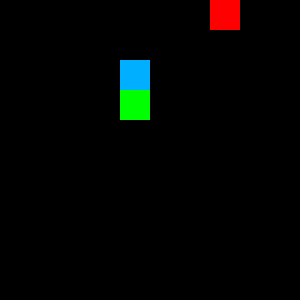

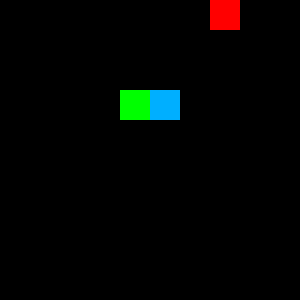

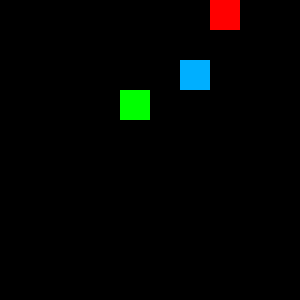

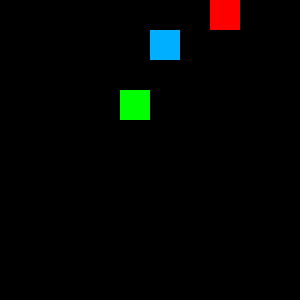

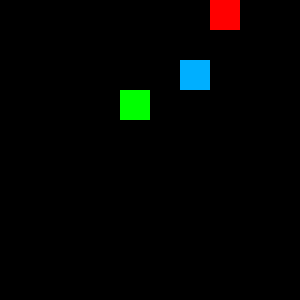

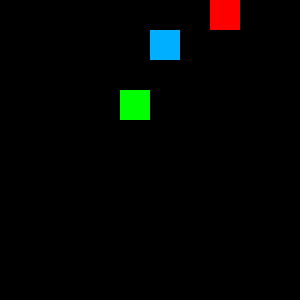

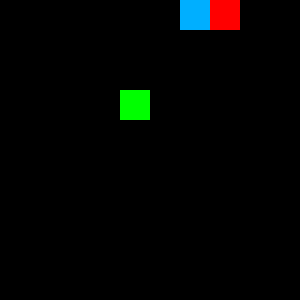

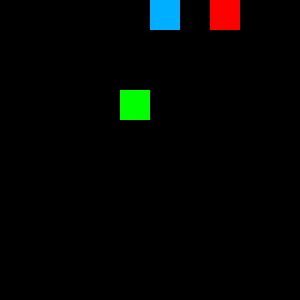

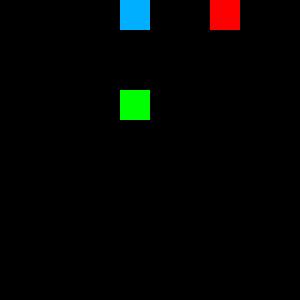

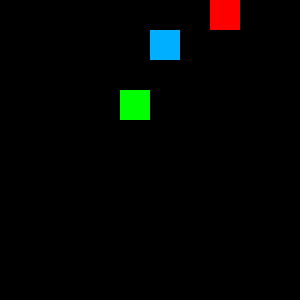

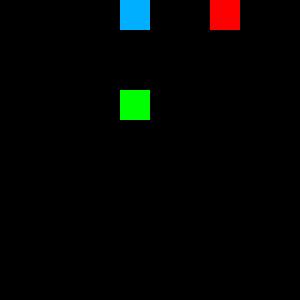

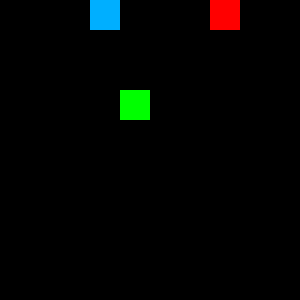

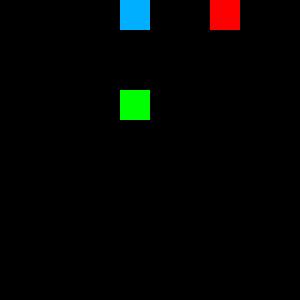

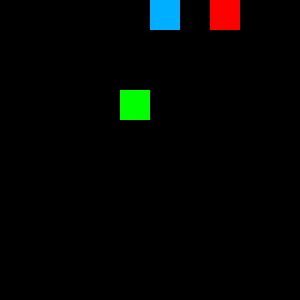

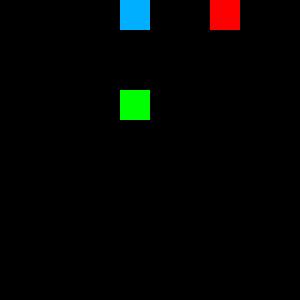

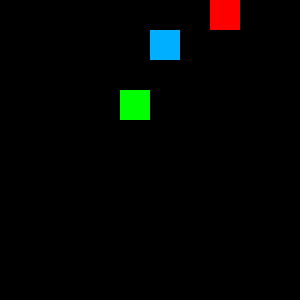

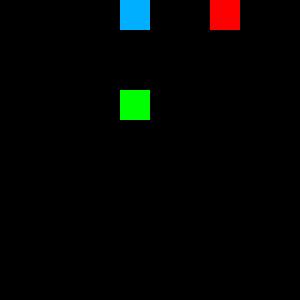

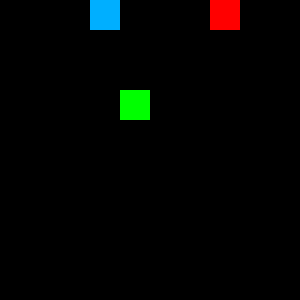

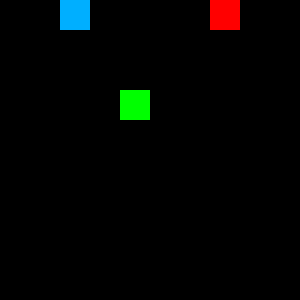

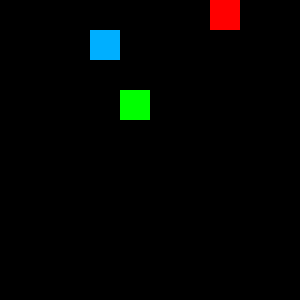

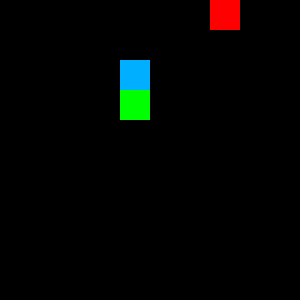

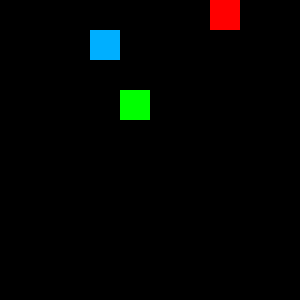

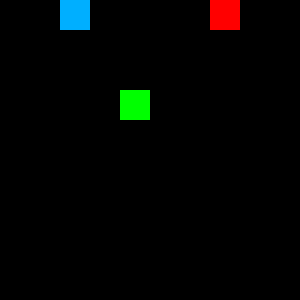

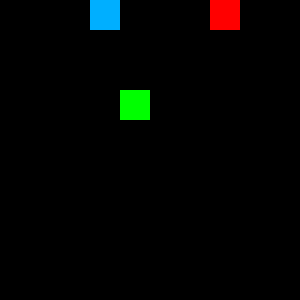

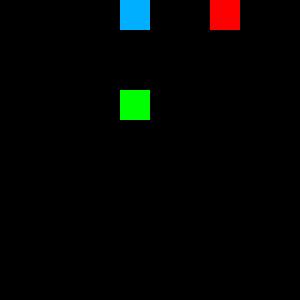

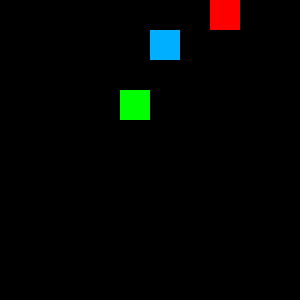

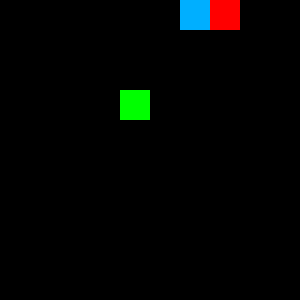

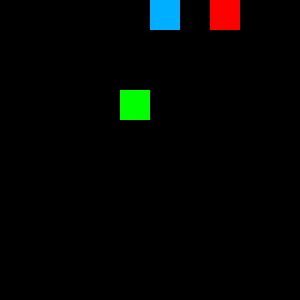

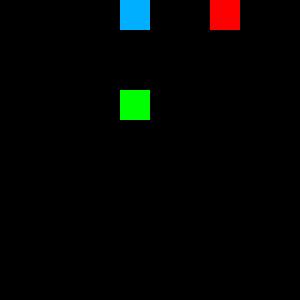

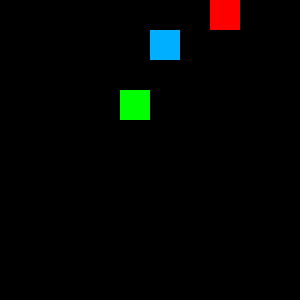

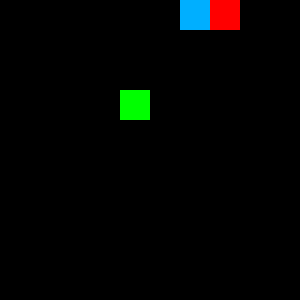

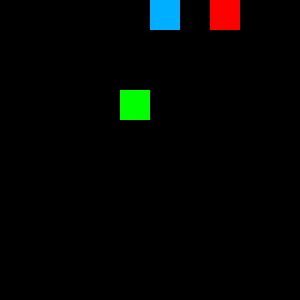

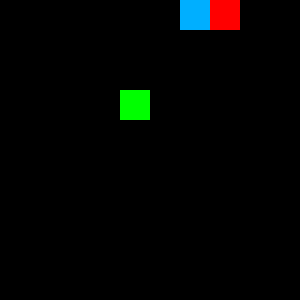

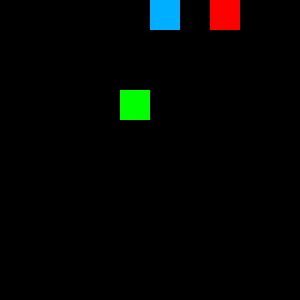

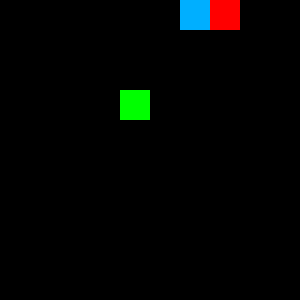

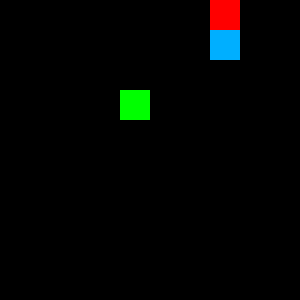

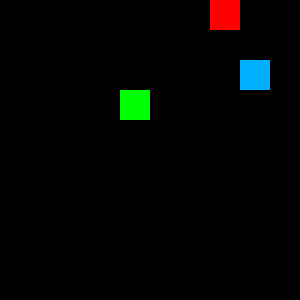

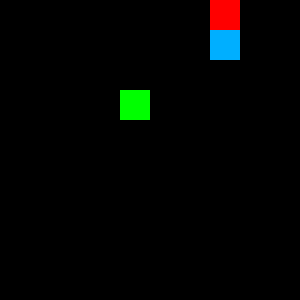

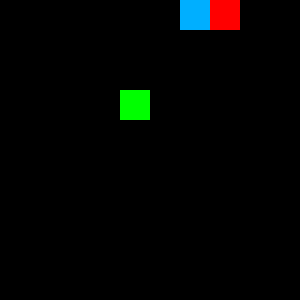

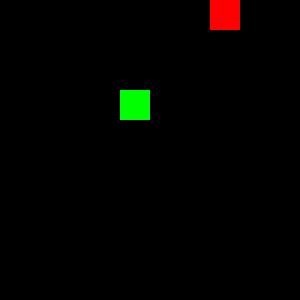

on #10000, epsilon is 6.100097732519995e-06
10000 ep mean: -112.9288


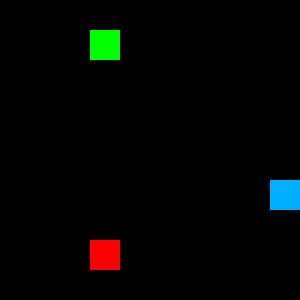

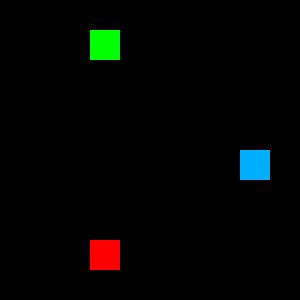

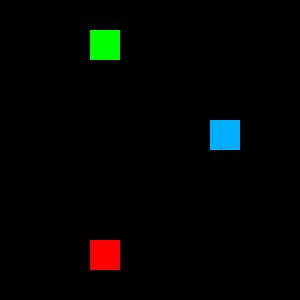

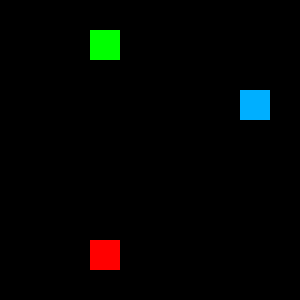

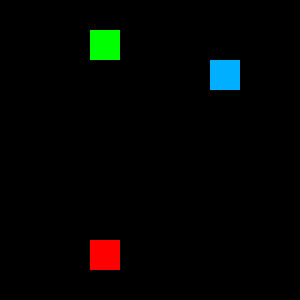

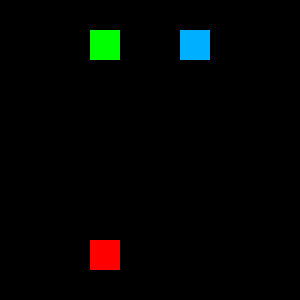

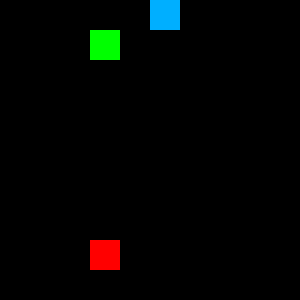

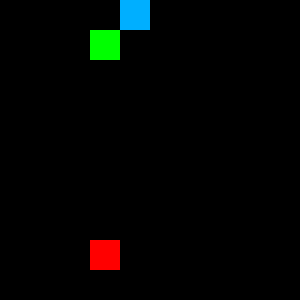

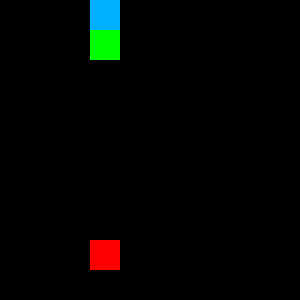

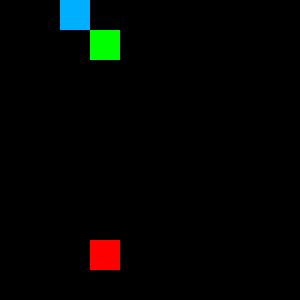

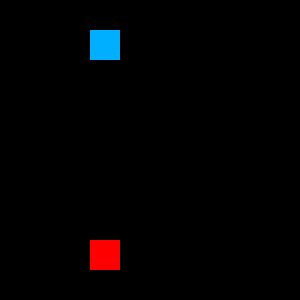

on #20000, epsilon is 3.721119234629542e-11
10000 ep mean: -94.881


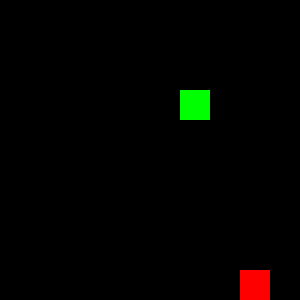

on #30000, epsilon is 2.269919100560006e-16
10000 ep mean: -90.0365


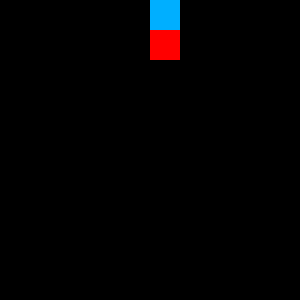

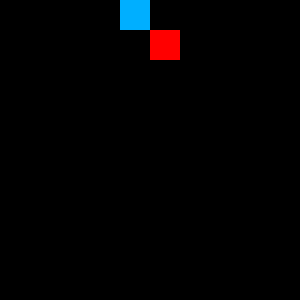

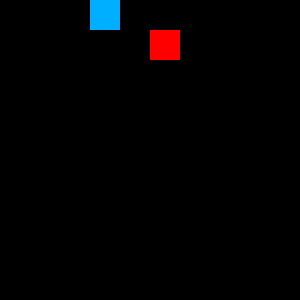

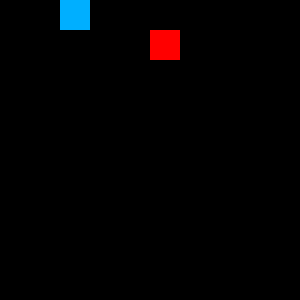

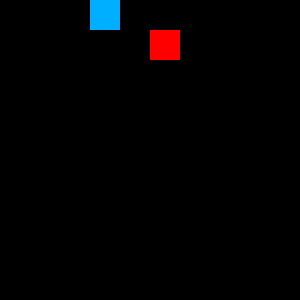

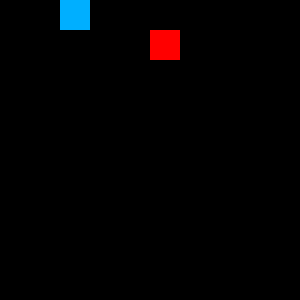

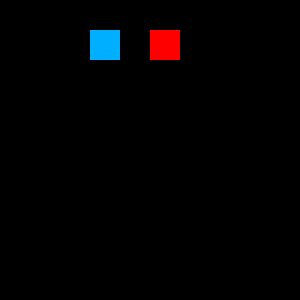

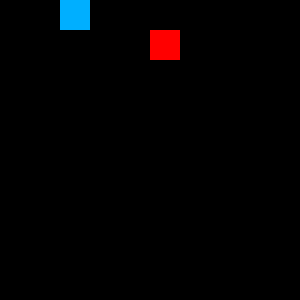

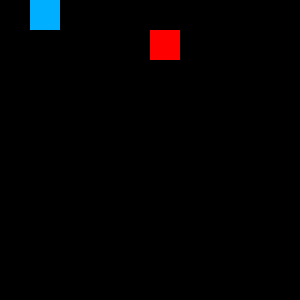

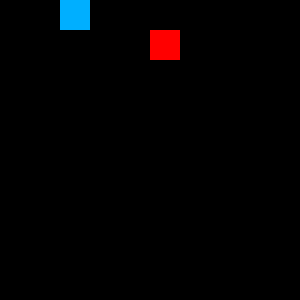

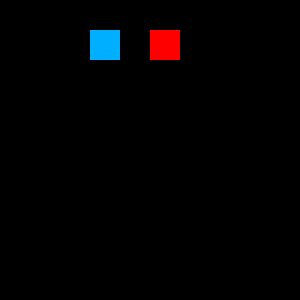

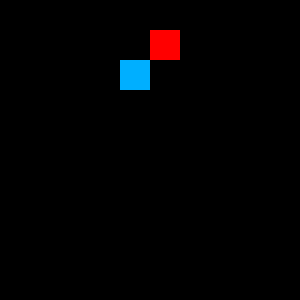

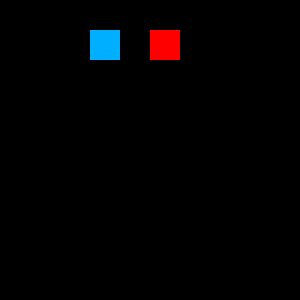

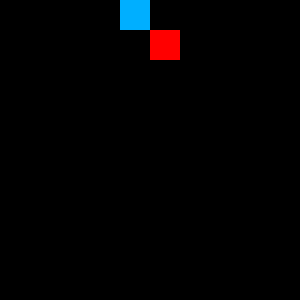

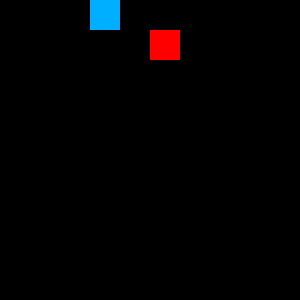

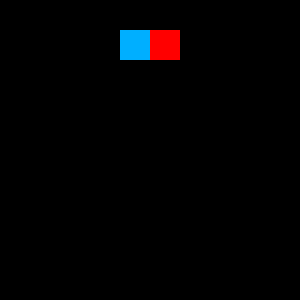

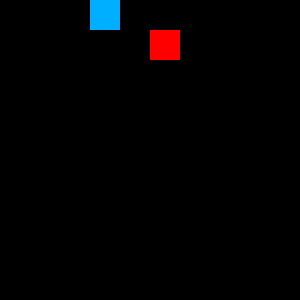

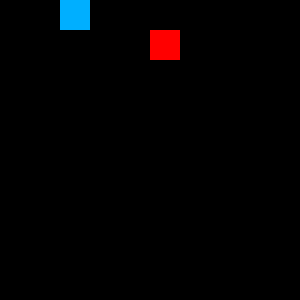

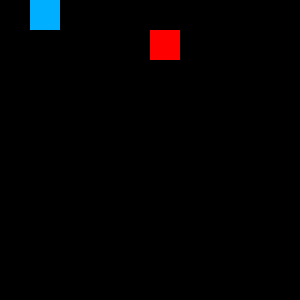

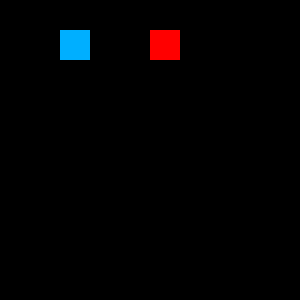

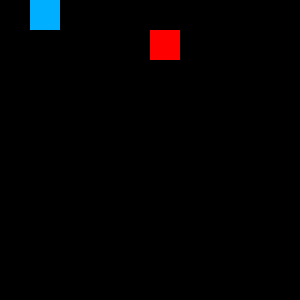

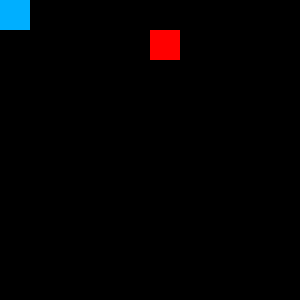

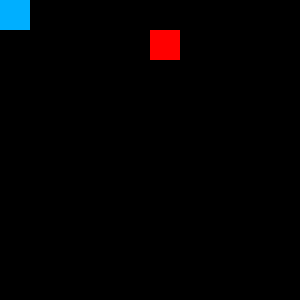

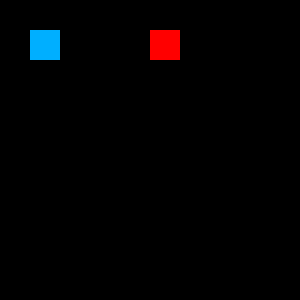

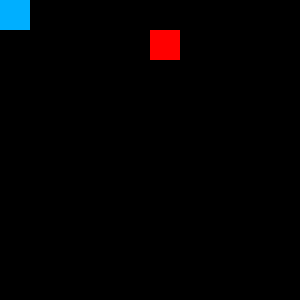

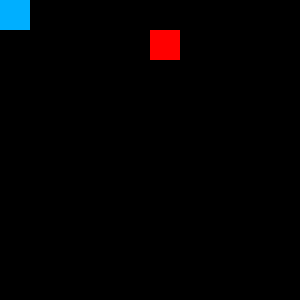

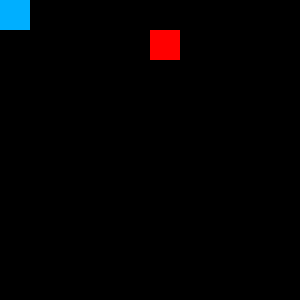

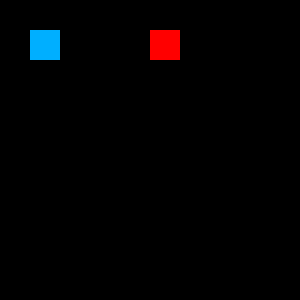

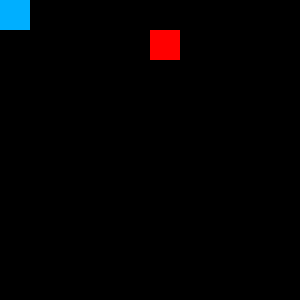

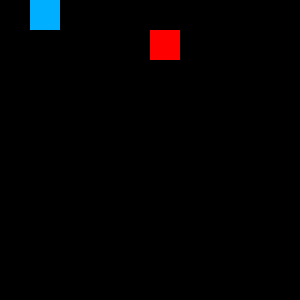

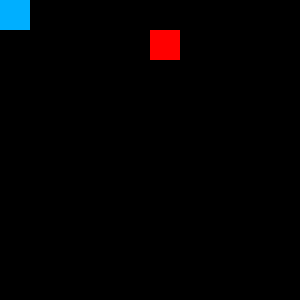

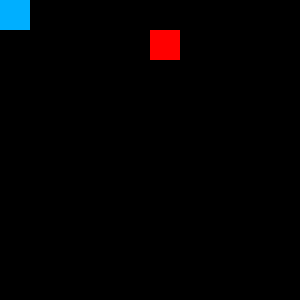

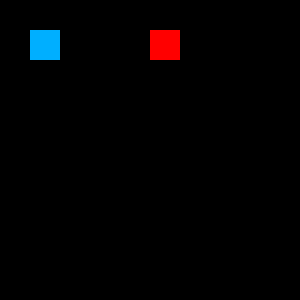

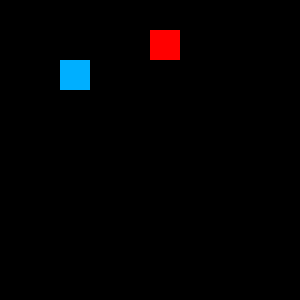

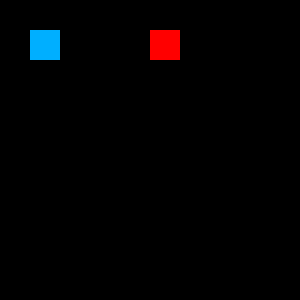

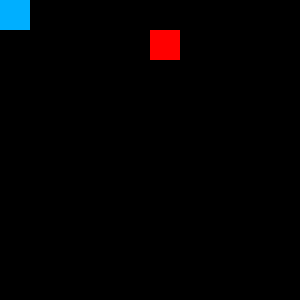

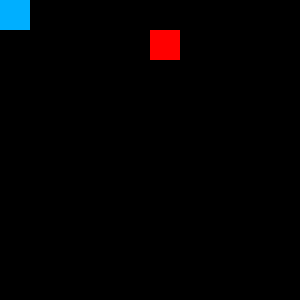

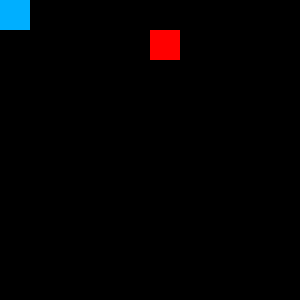

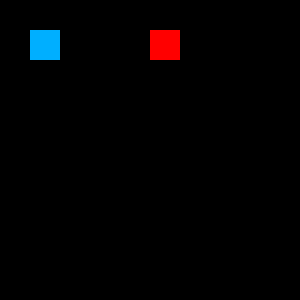

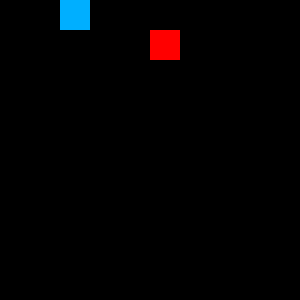

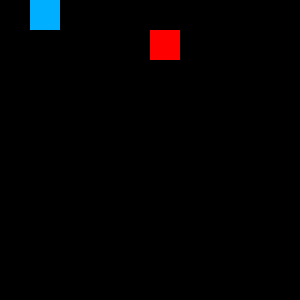

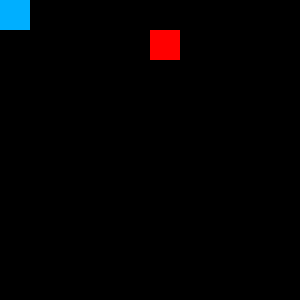

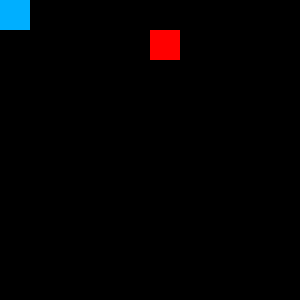

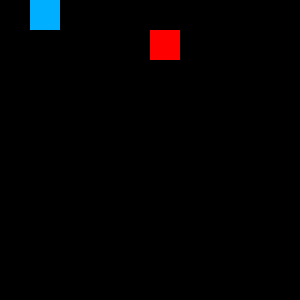

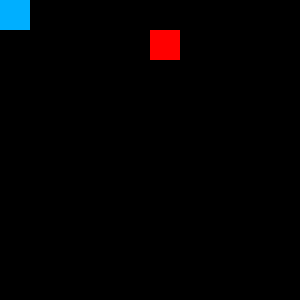

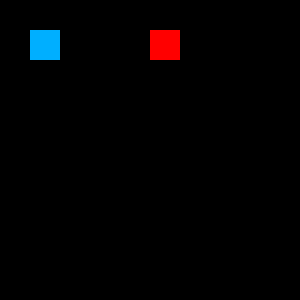

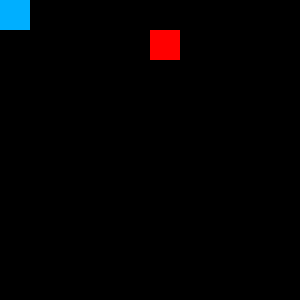

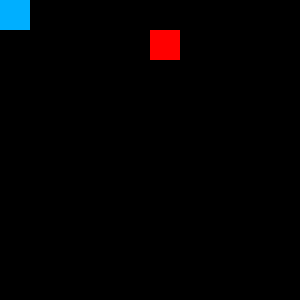

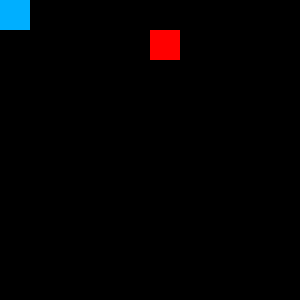

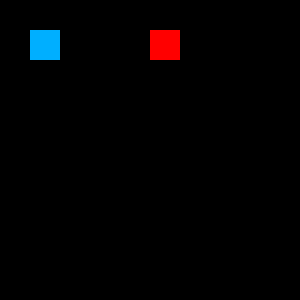

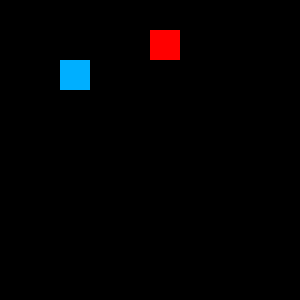

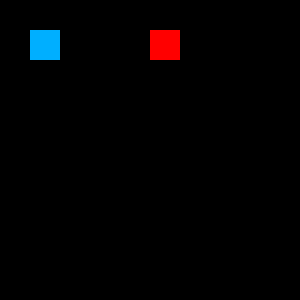

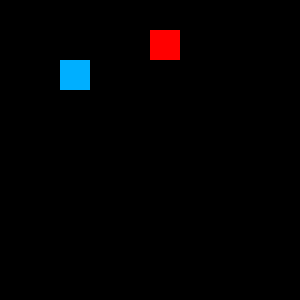

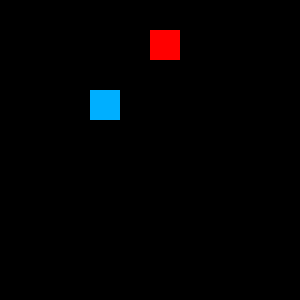

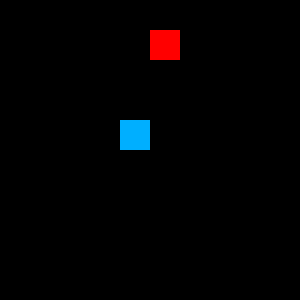

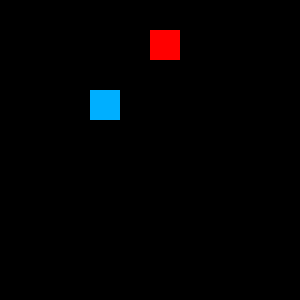

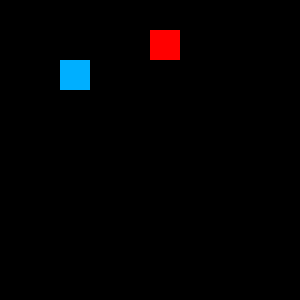

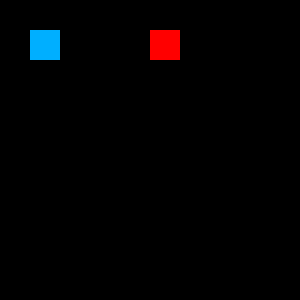

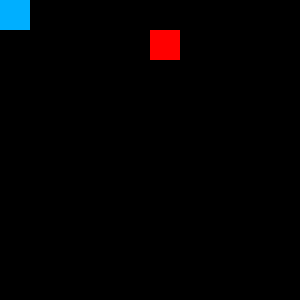

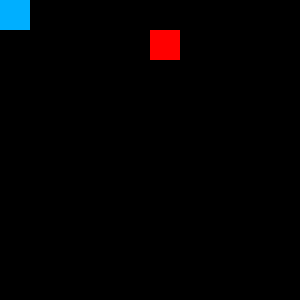

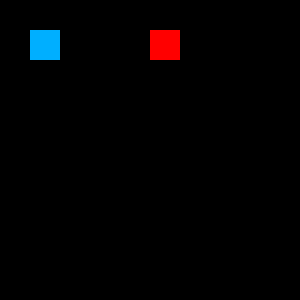

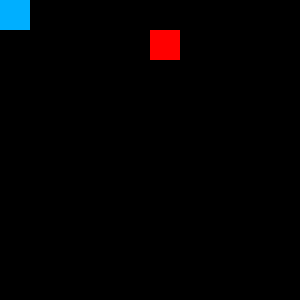

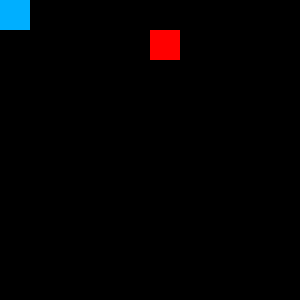

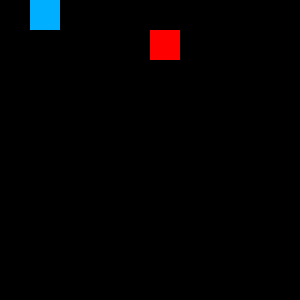

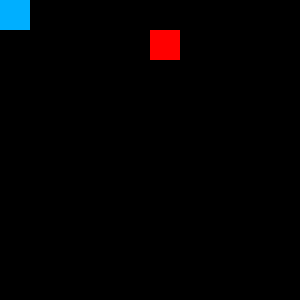

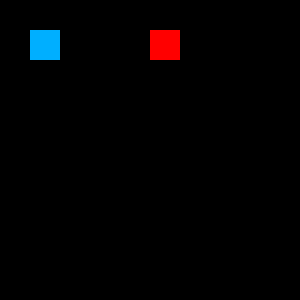

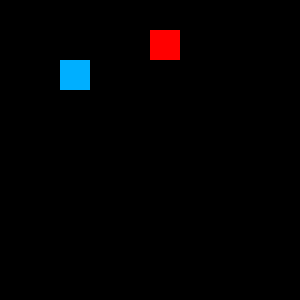

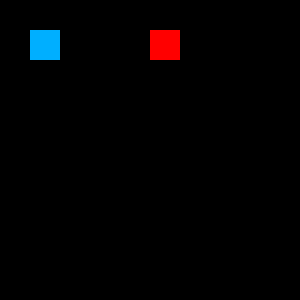

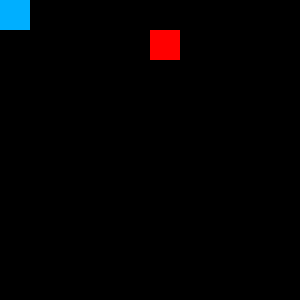

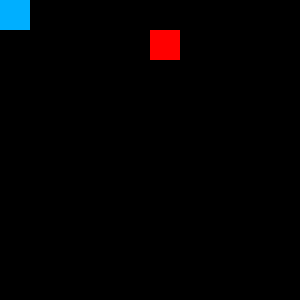

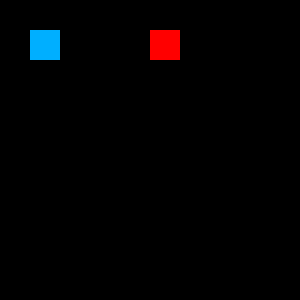

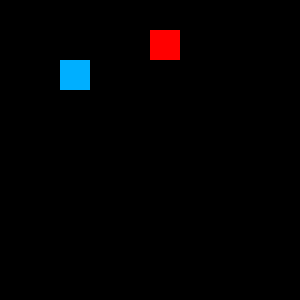

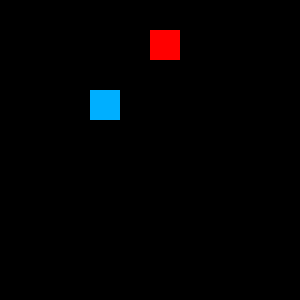

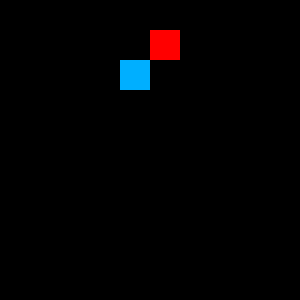

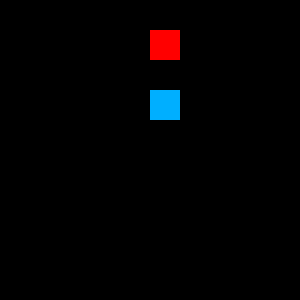

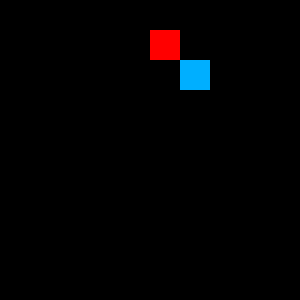

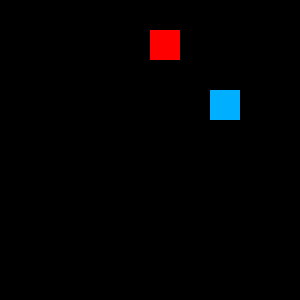

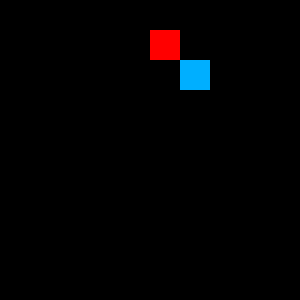

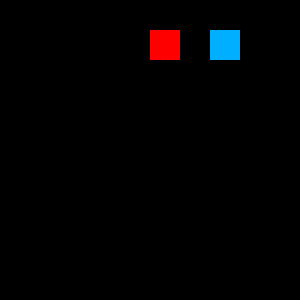

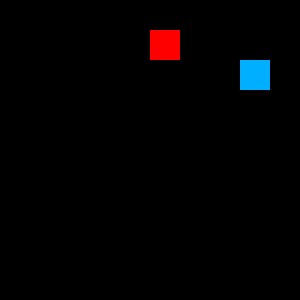

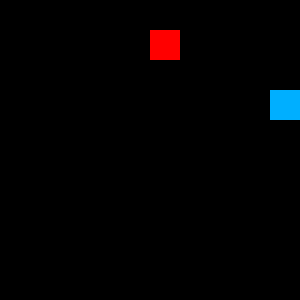

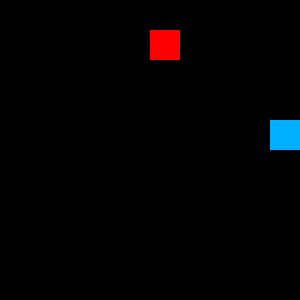

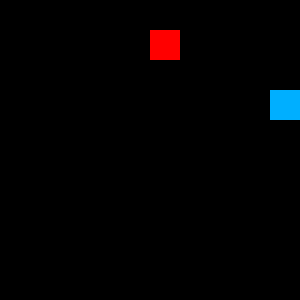

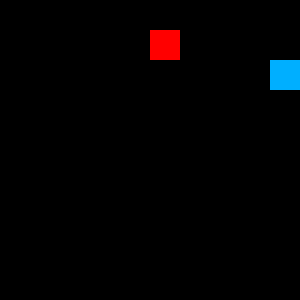

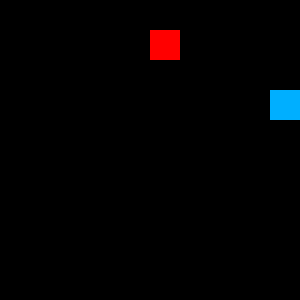

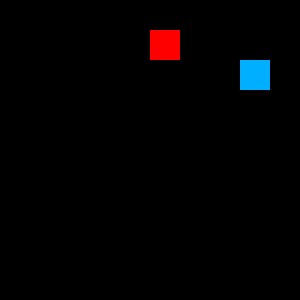

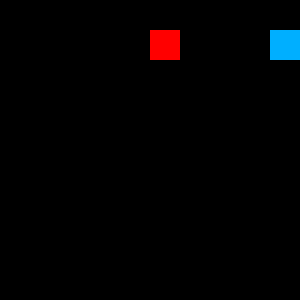

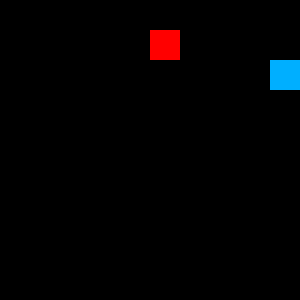

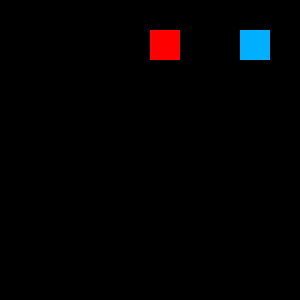

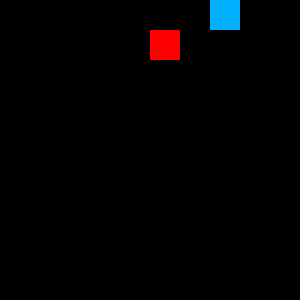

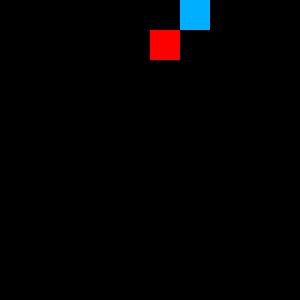

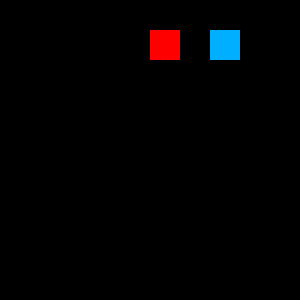

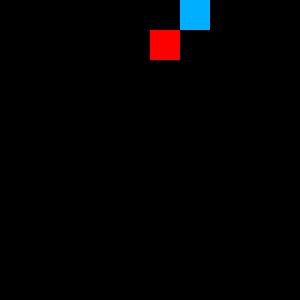

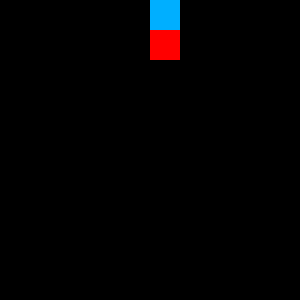

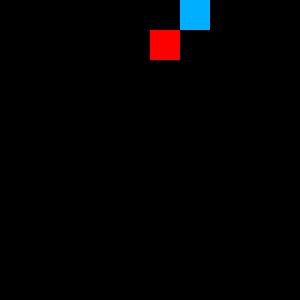

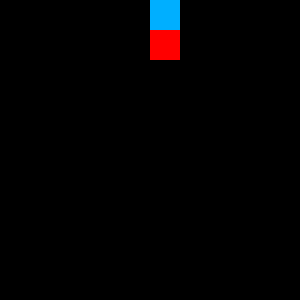

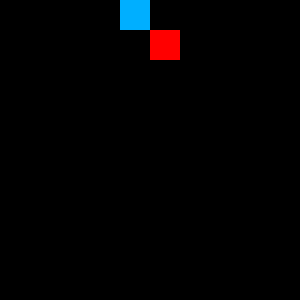

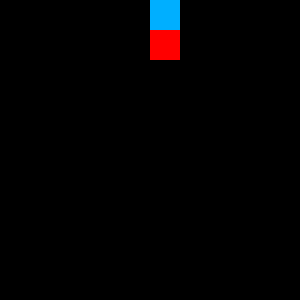

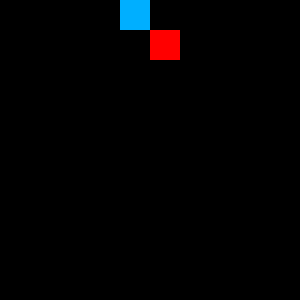

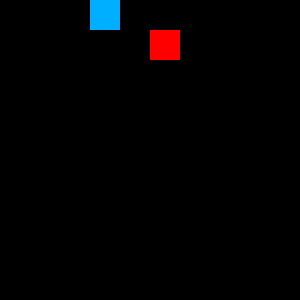

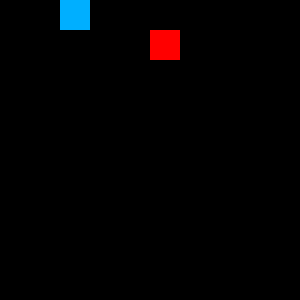

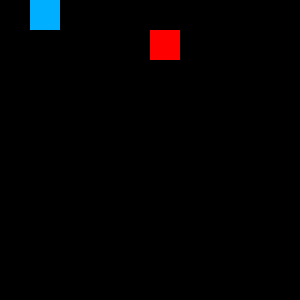

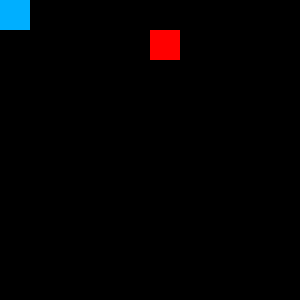

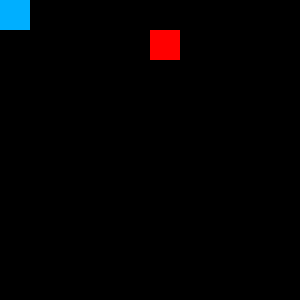

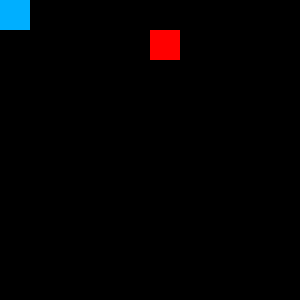

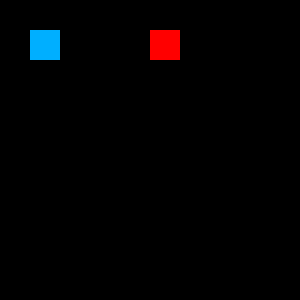

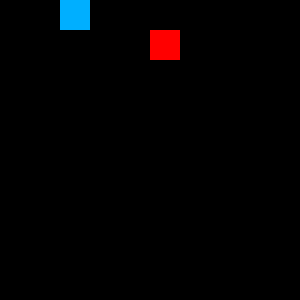

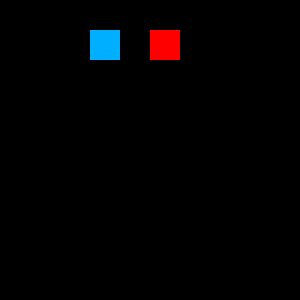

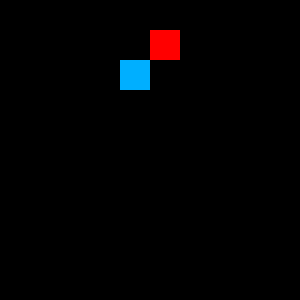

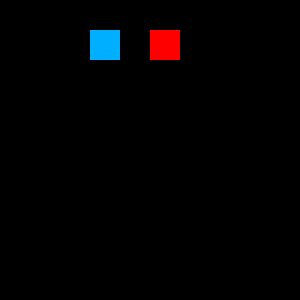

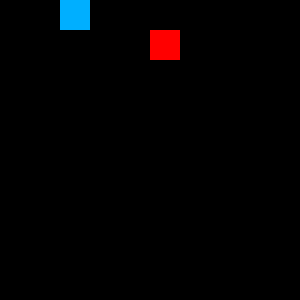

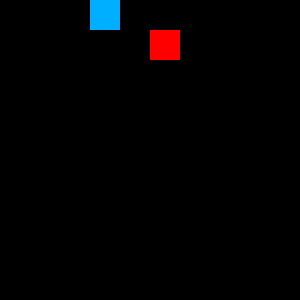

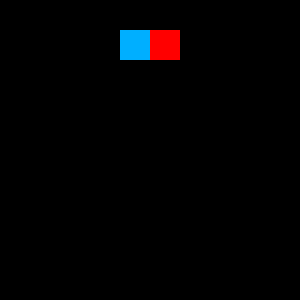

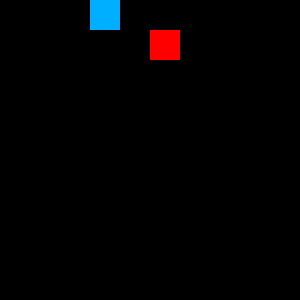

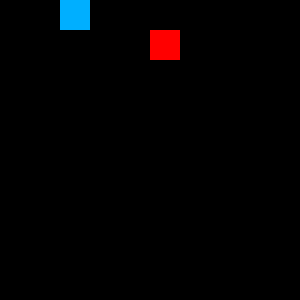

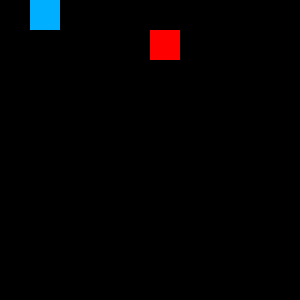

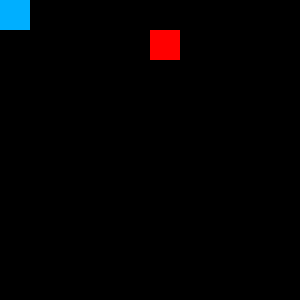

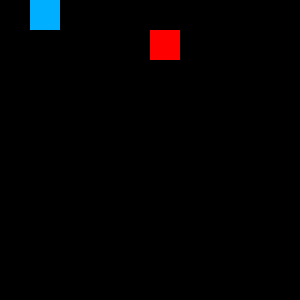

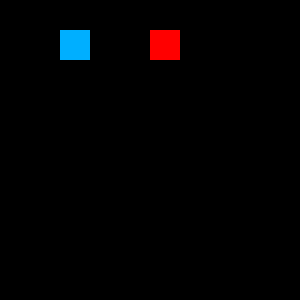

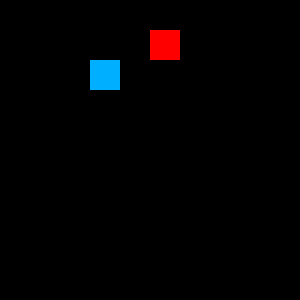

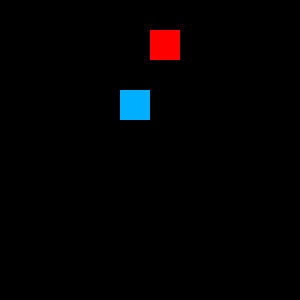

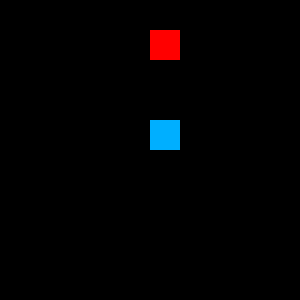

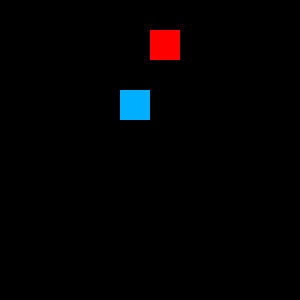

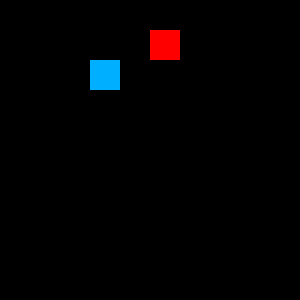

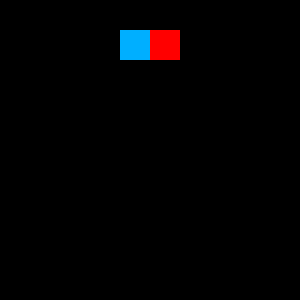

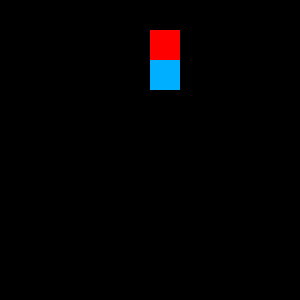

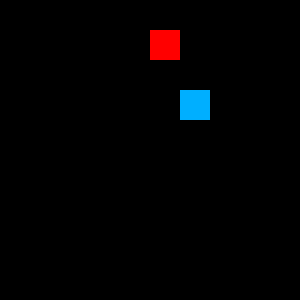

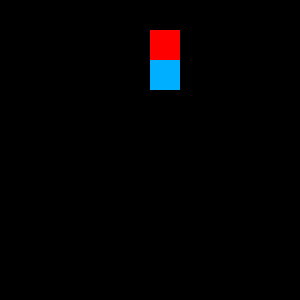

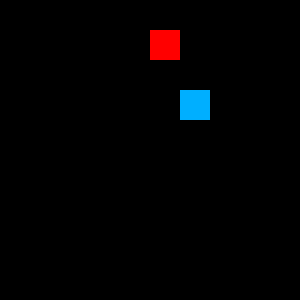

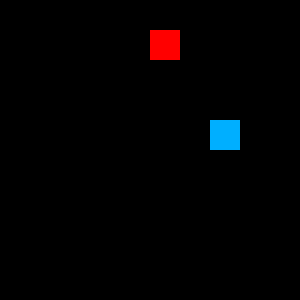

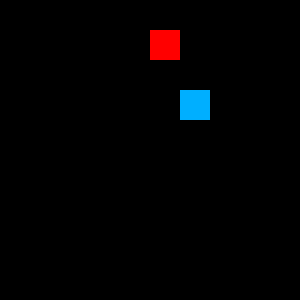

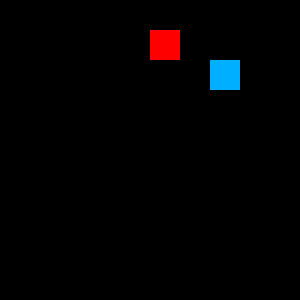

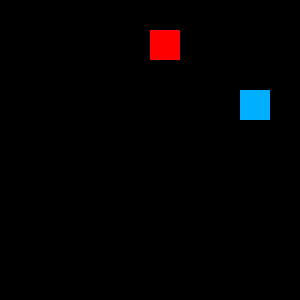

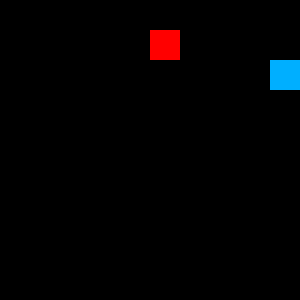

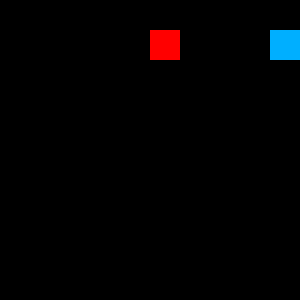

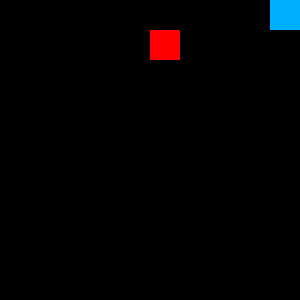

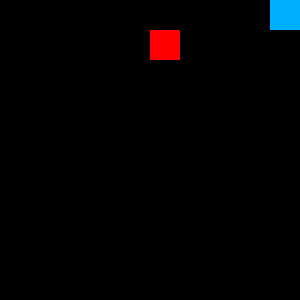

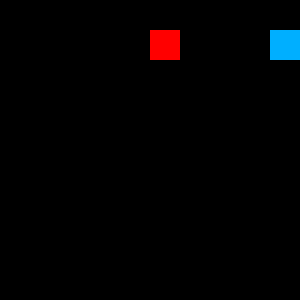

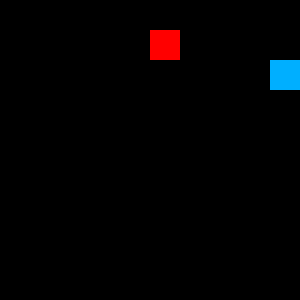

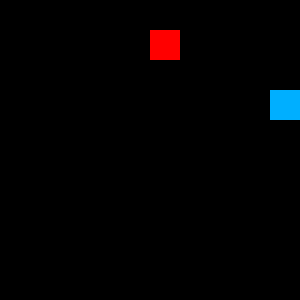

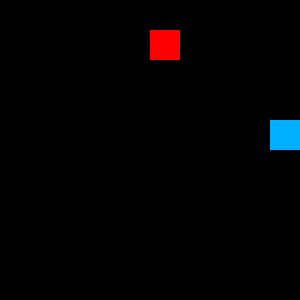

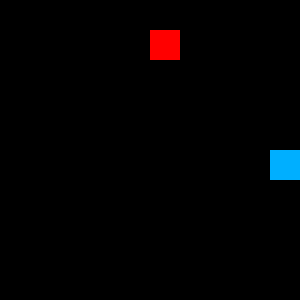

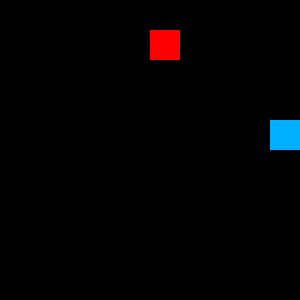

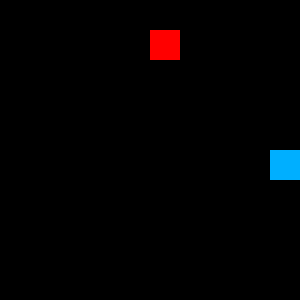

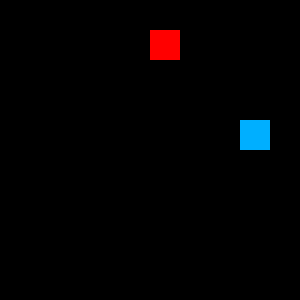

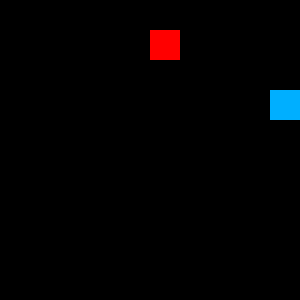

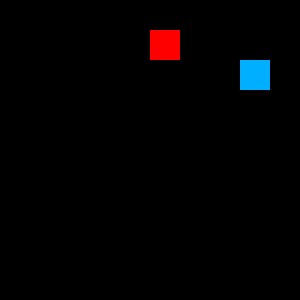

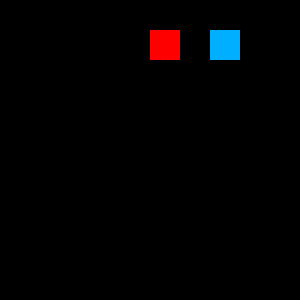

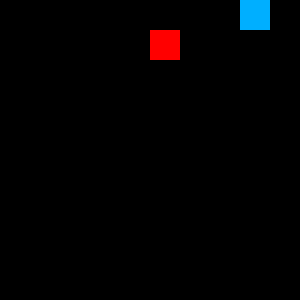

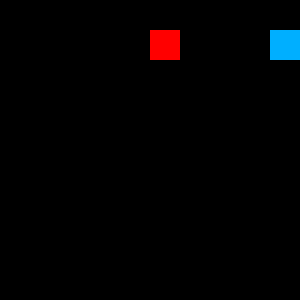

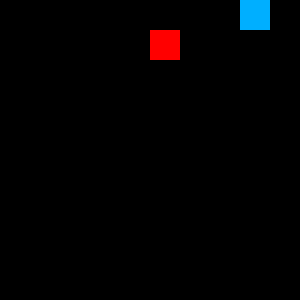

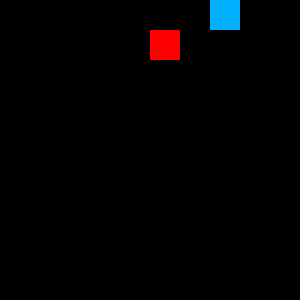

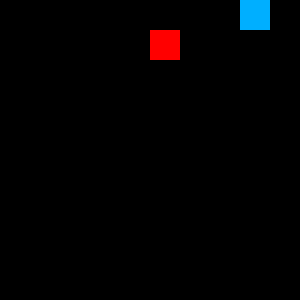

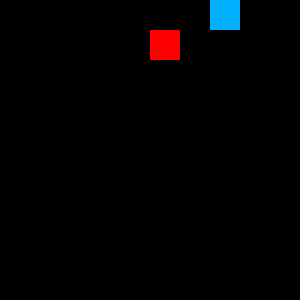

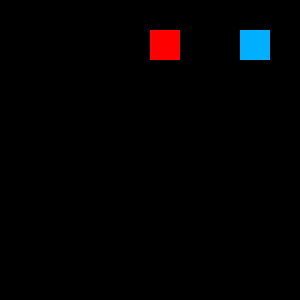

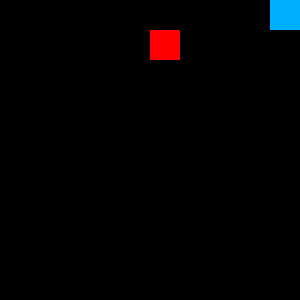

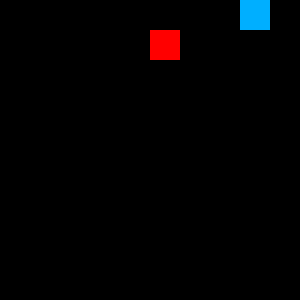

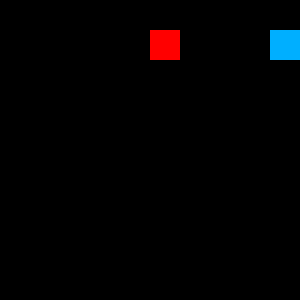

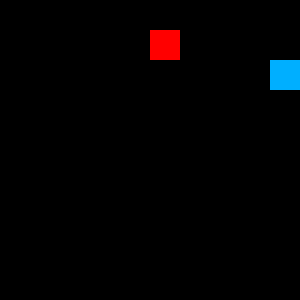

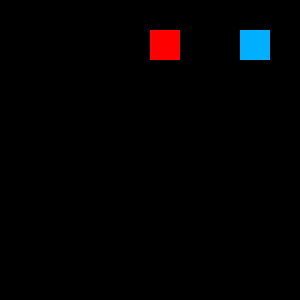

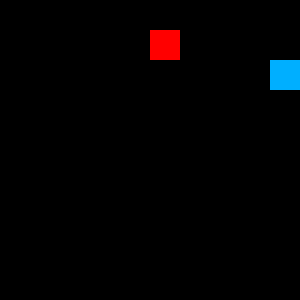

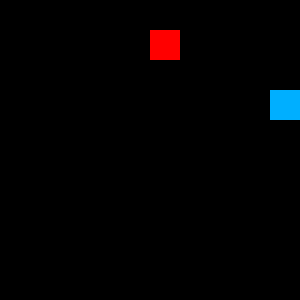

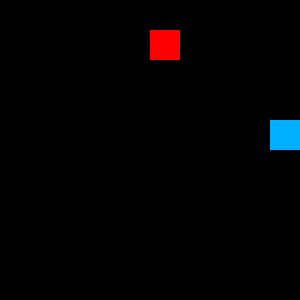

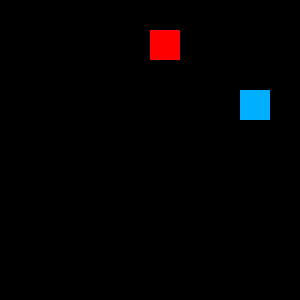

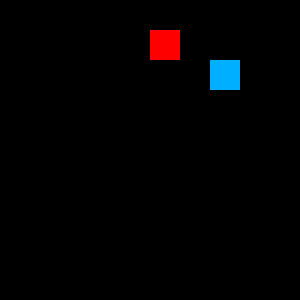

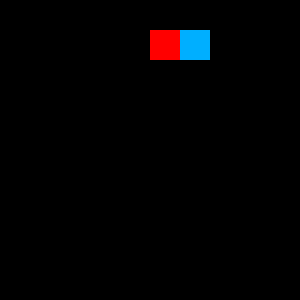

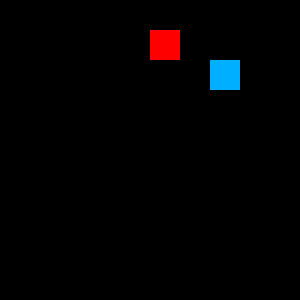

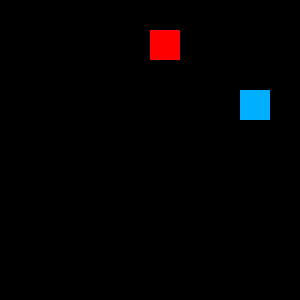

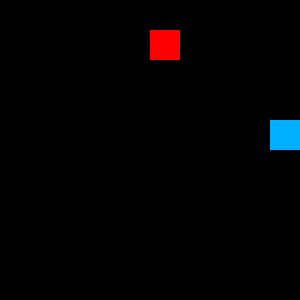

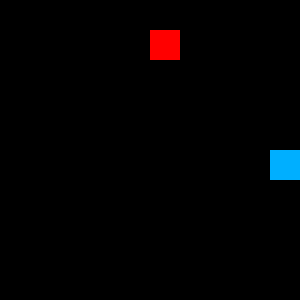

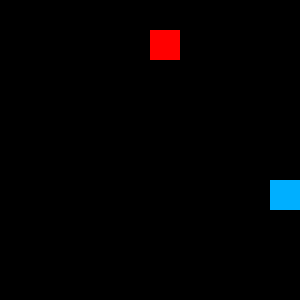

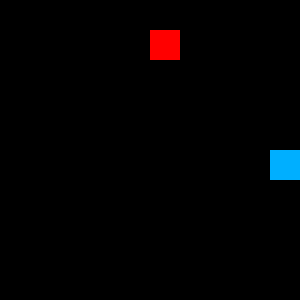

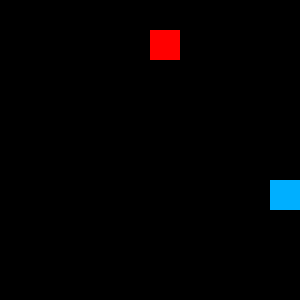

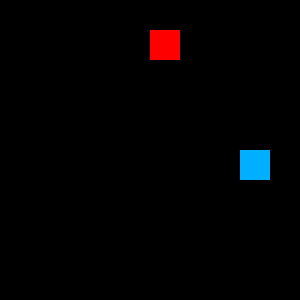

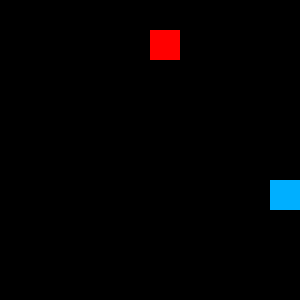

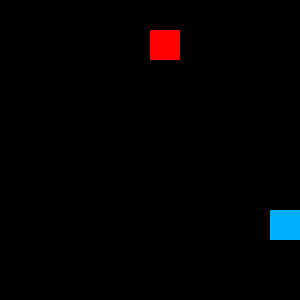

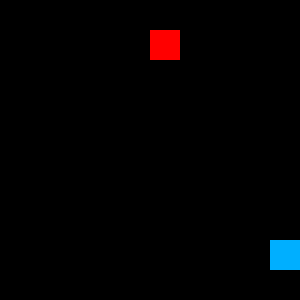

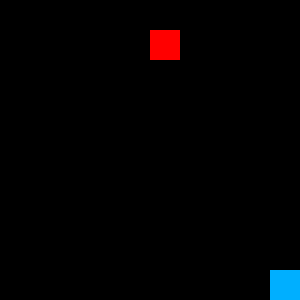

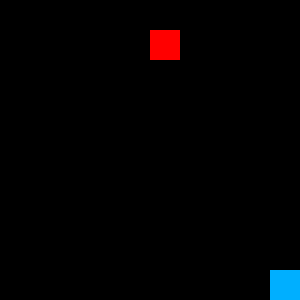

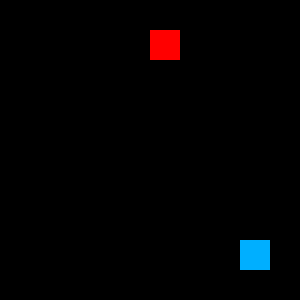

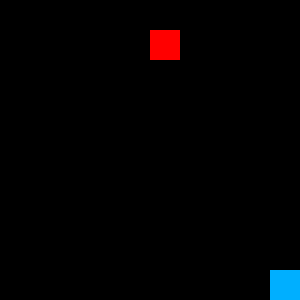

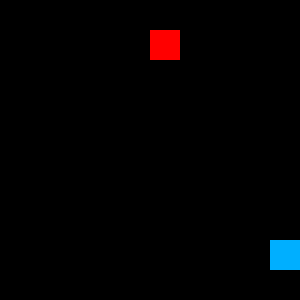

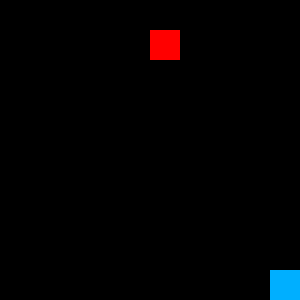

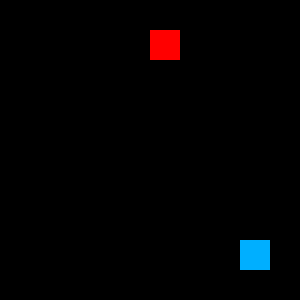

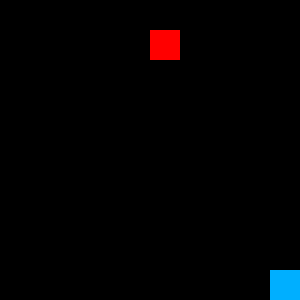

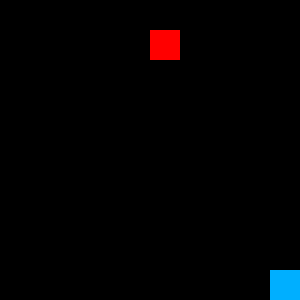

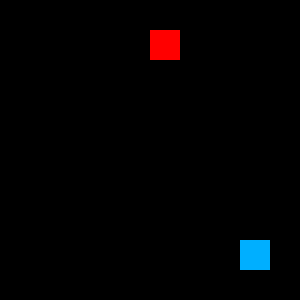

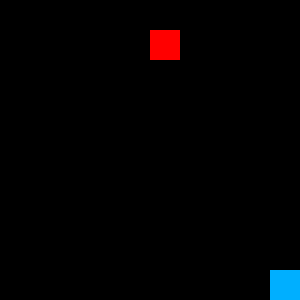

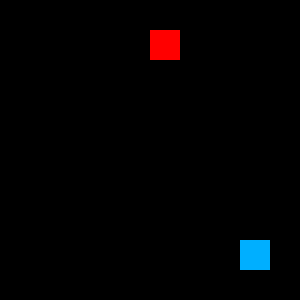

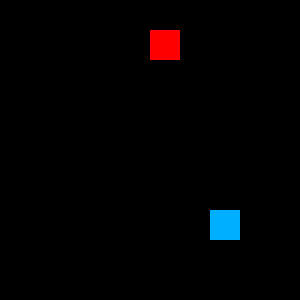

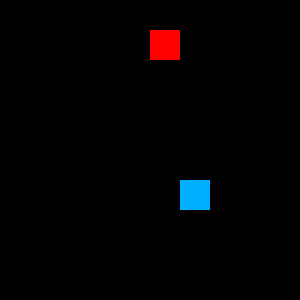

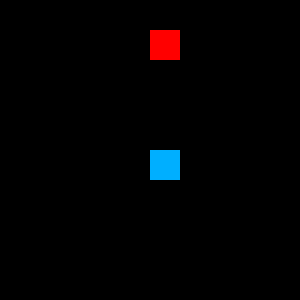

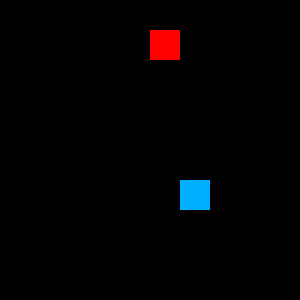

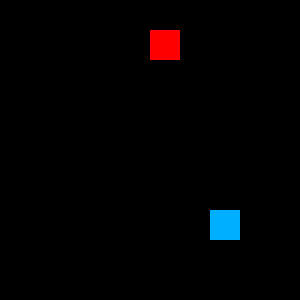

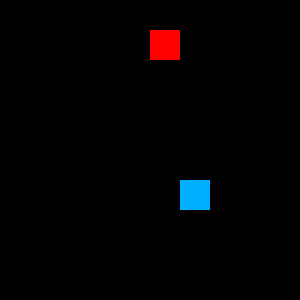

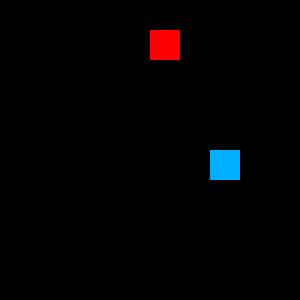

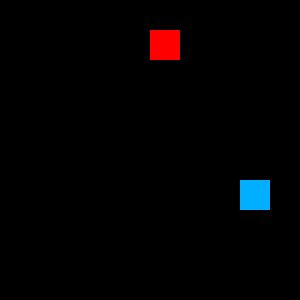

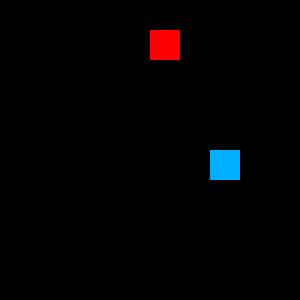

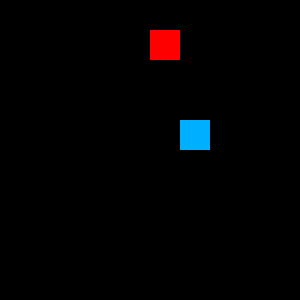

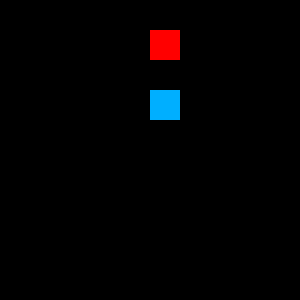

on #40000, epsilon is 1.3846728358329882e-21
10000 ep mean: -87.6761


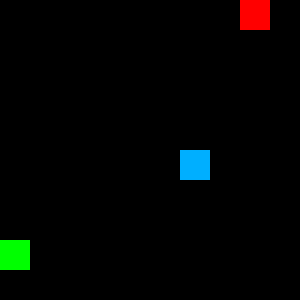

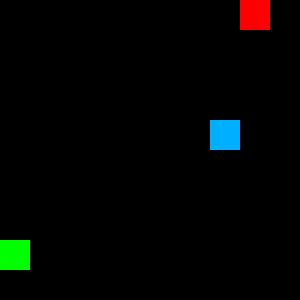

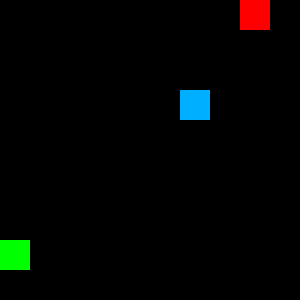

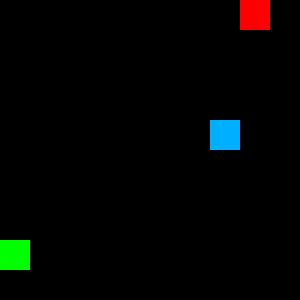

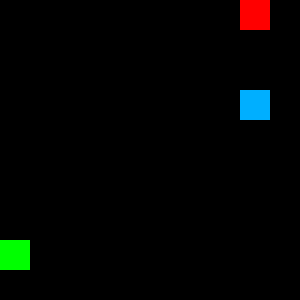

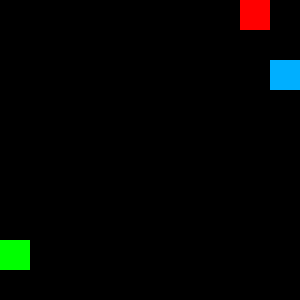

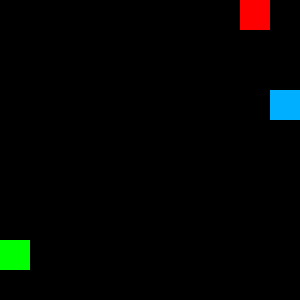

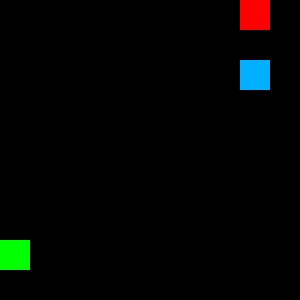

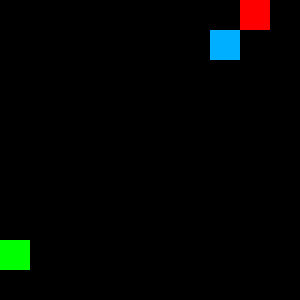

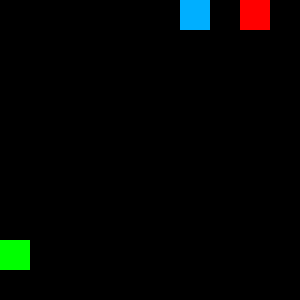

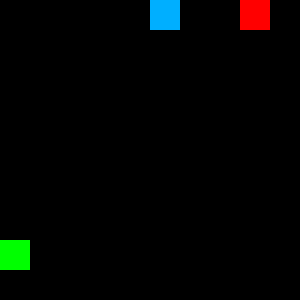

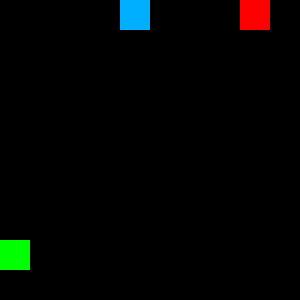

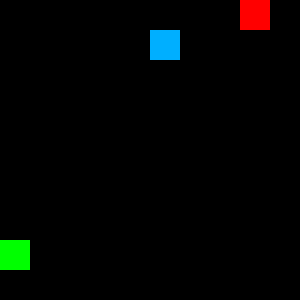

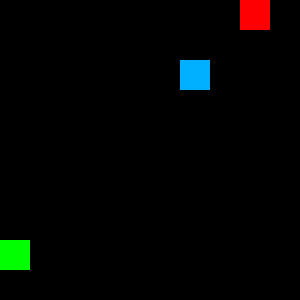

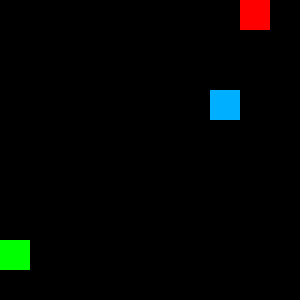

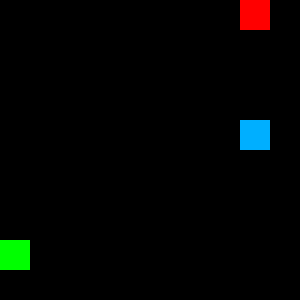

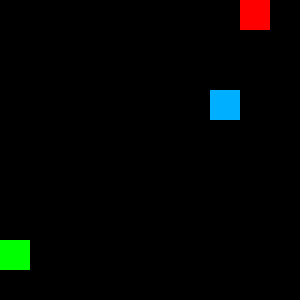

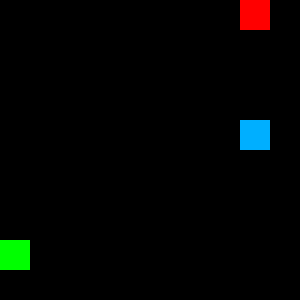

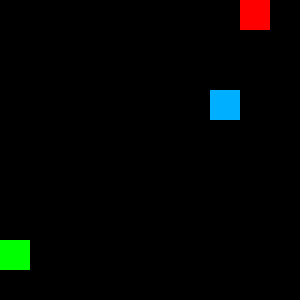

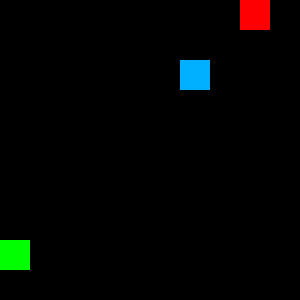

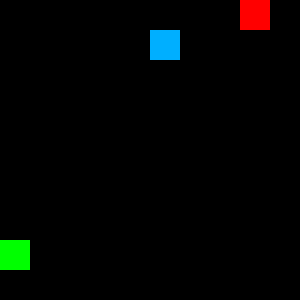

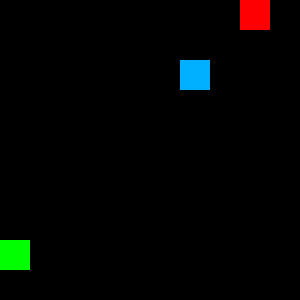

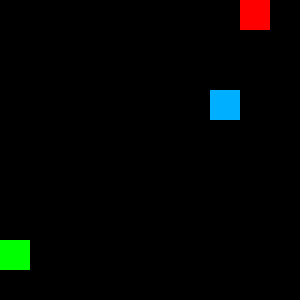

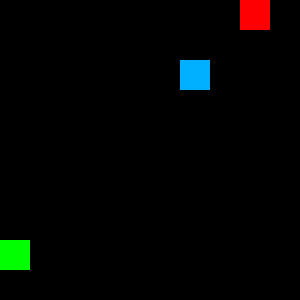

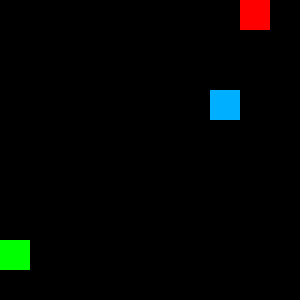

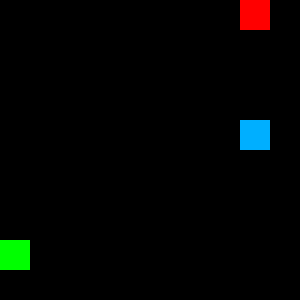

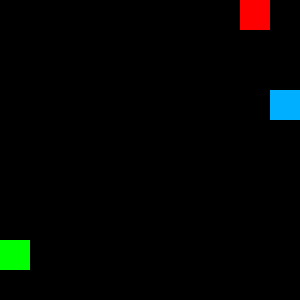

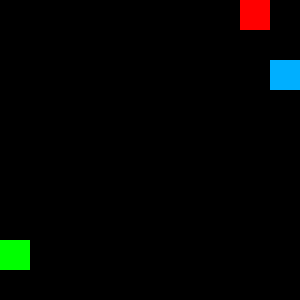

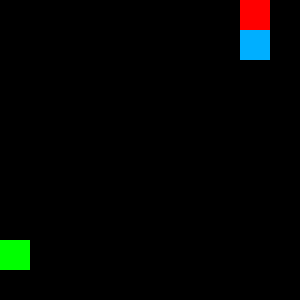

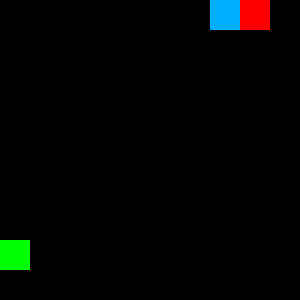

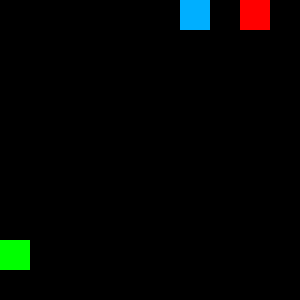

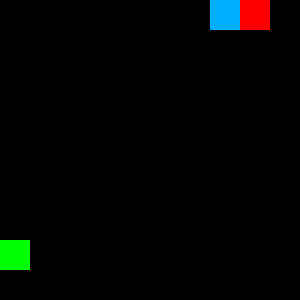

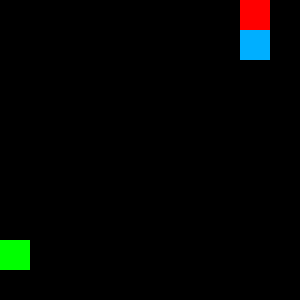

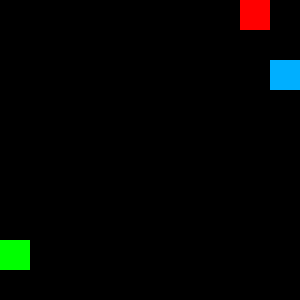

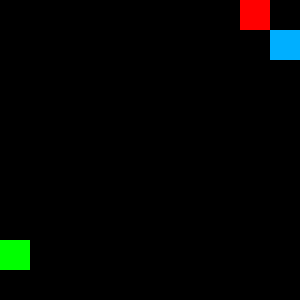

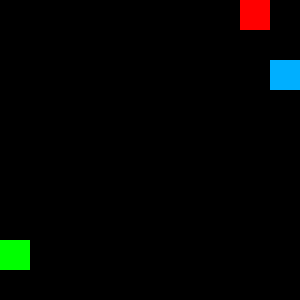

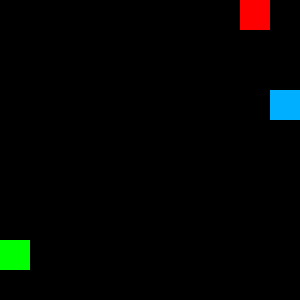

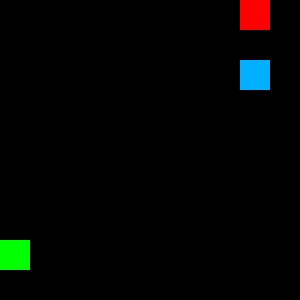

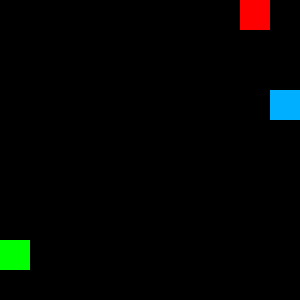

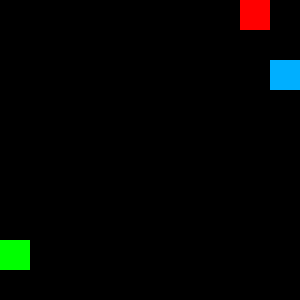

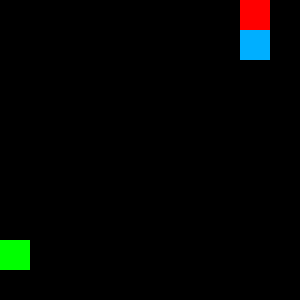

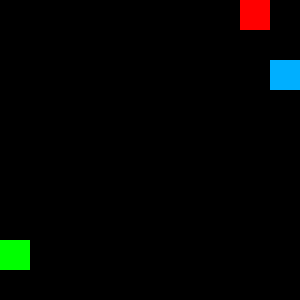

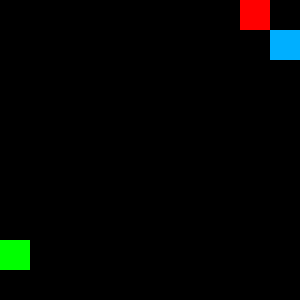

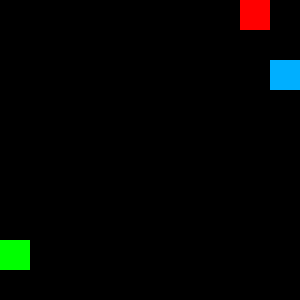

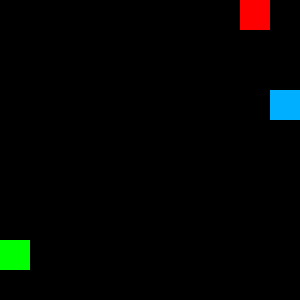

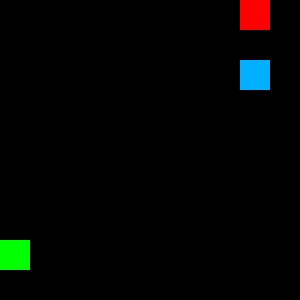

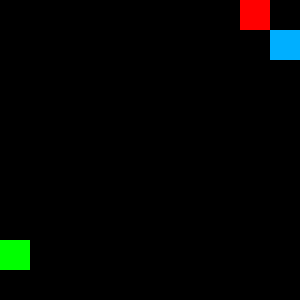

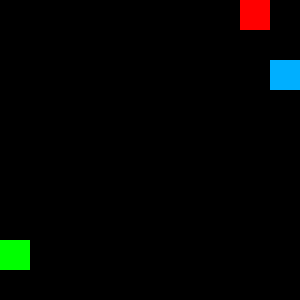

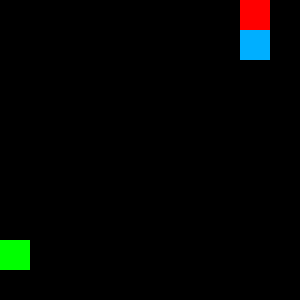

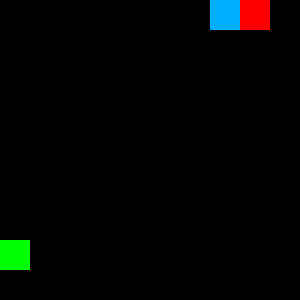

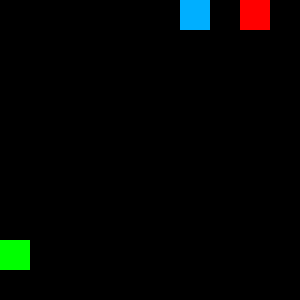

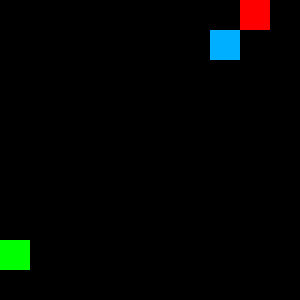

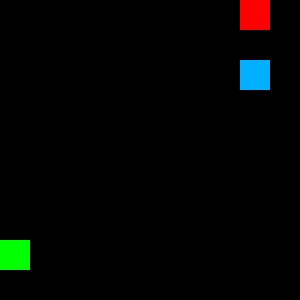

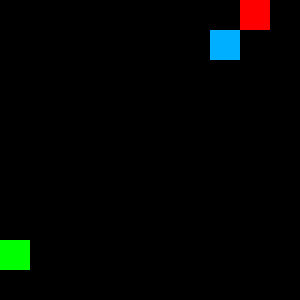

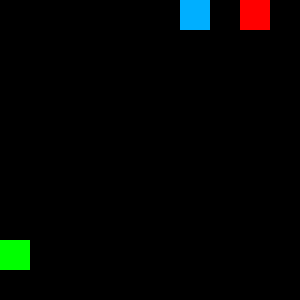

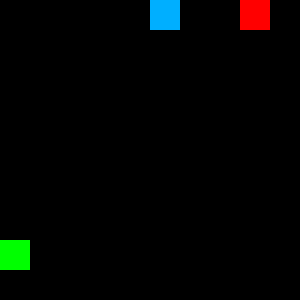

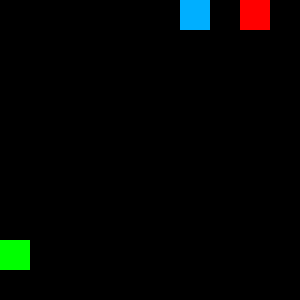

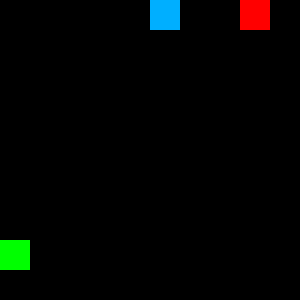

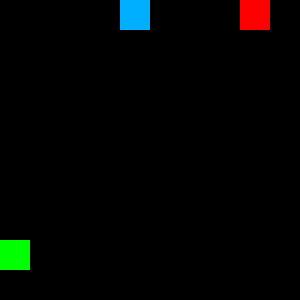

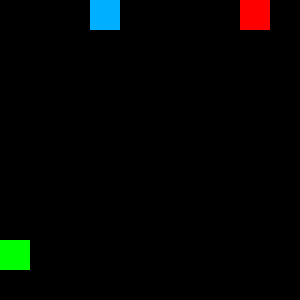

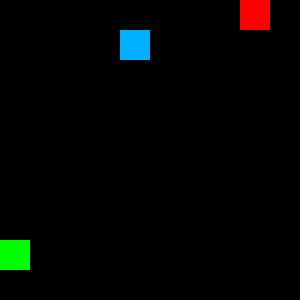

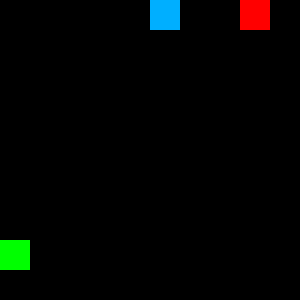

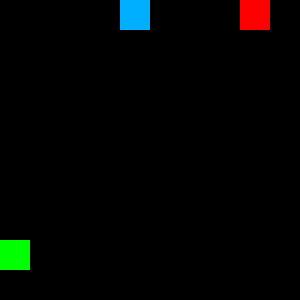

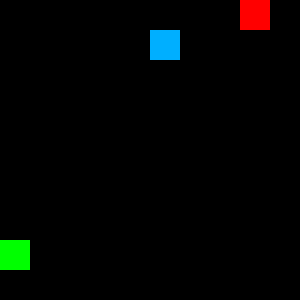

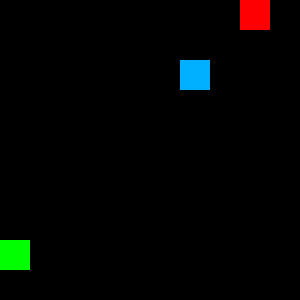

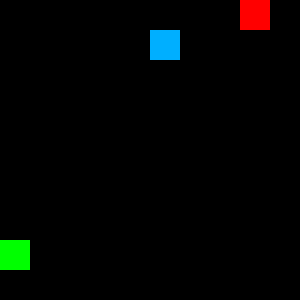

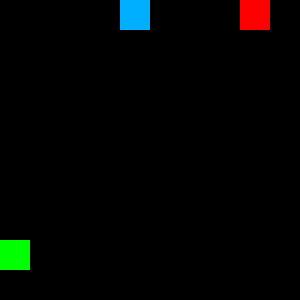

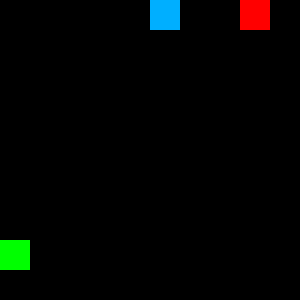

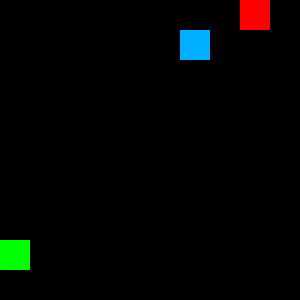

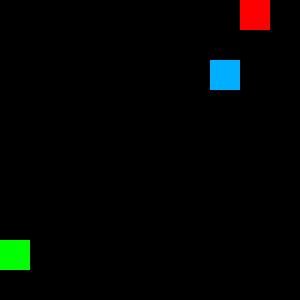

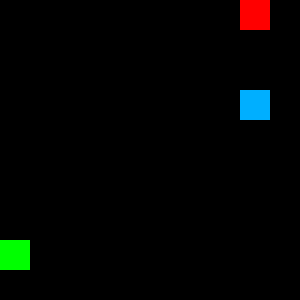

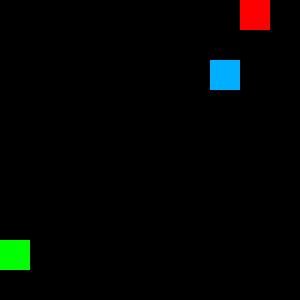

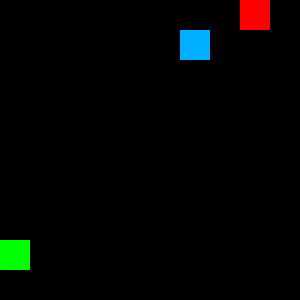

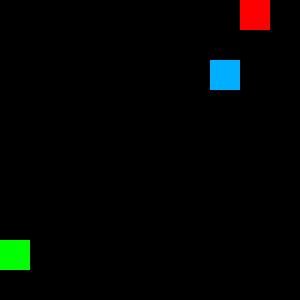

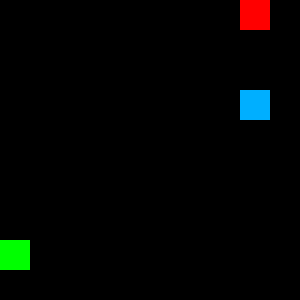

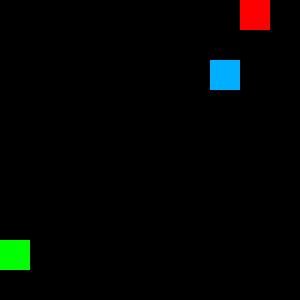

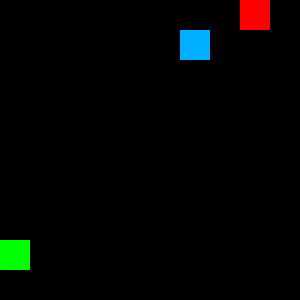

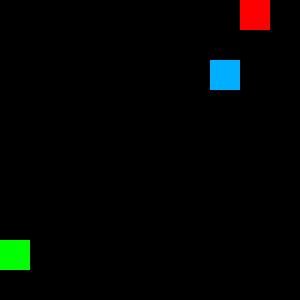

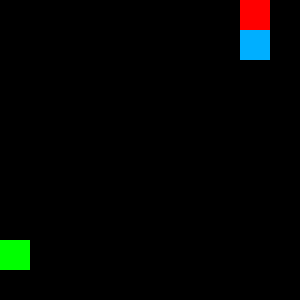

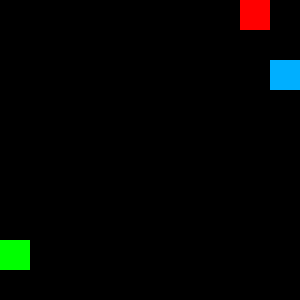

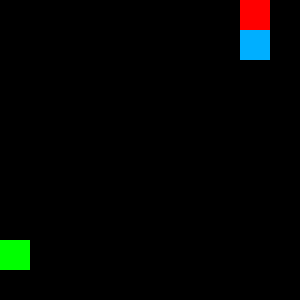

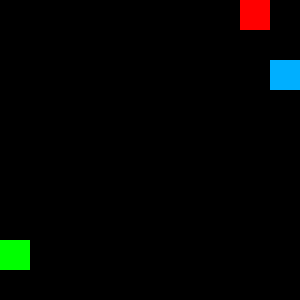

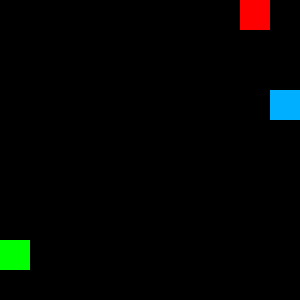

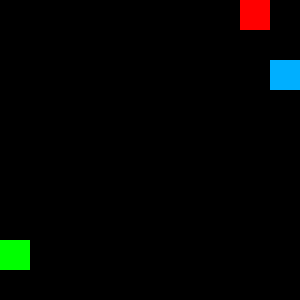

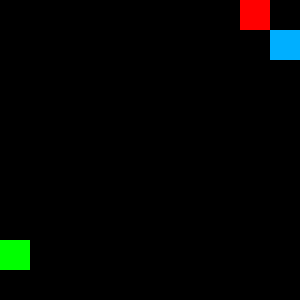

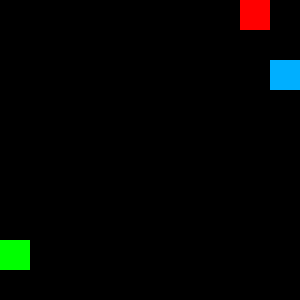

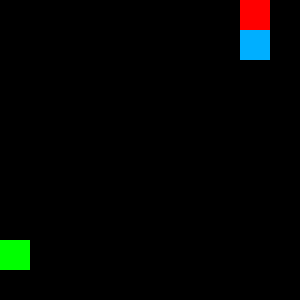

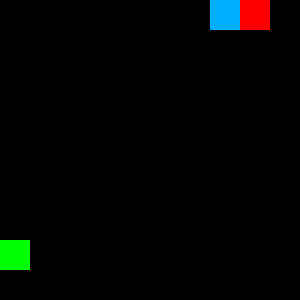

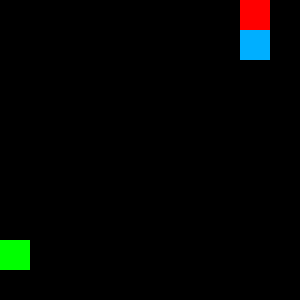

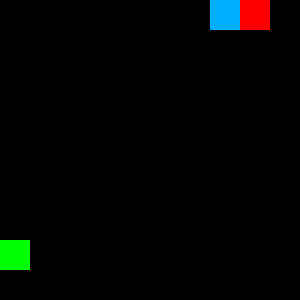

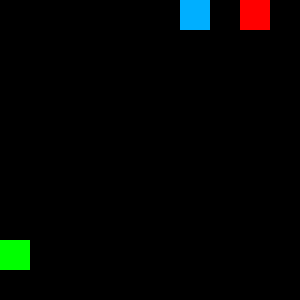

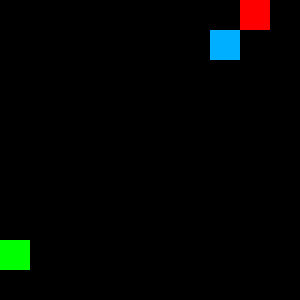

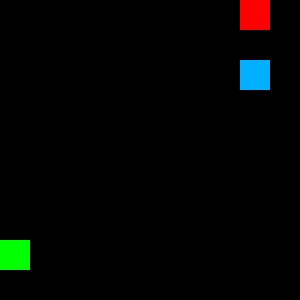

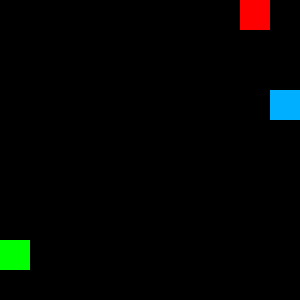

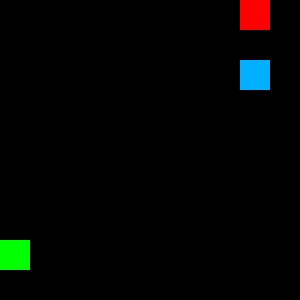

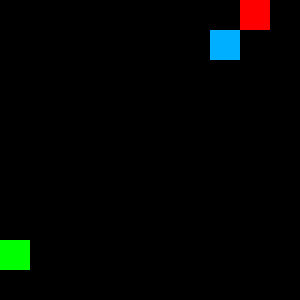

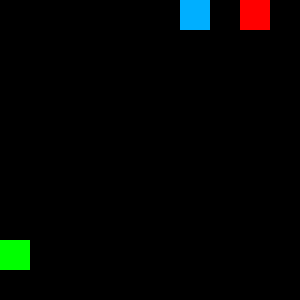

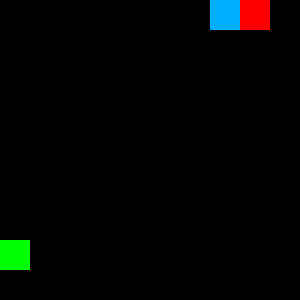

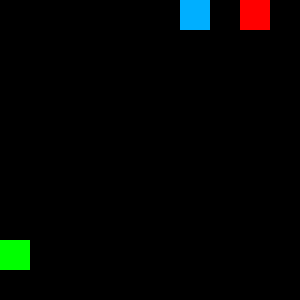

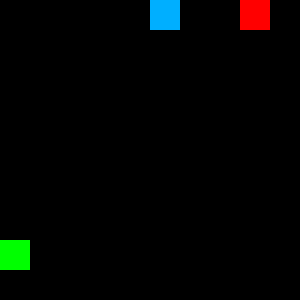

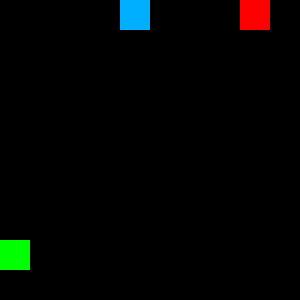

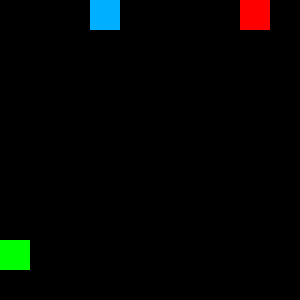

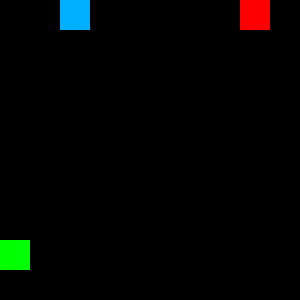

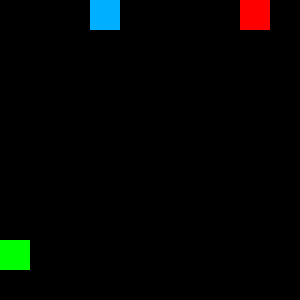

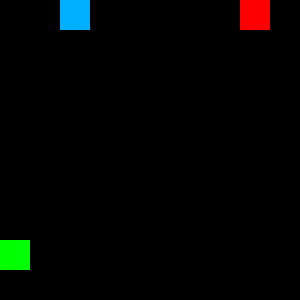

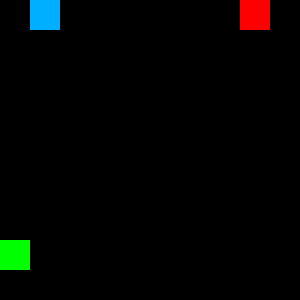

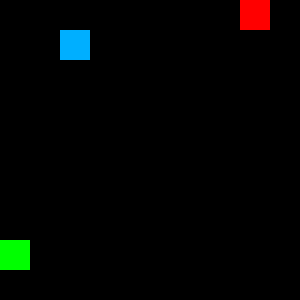

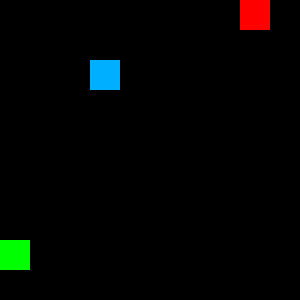

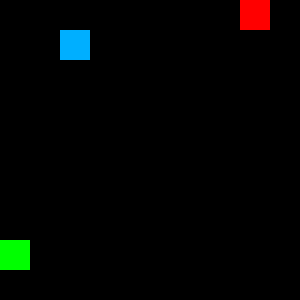

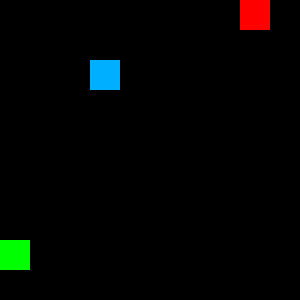

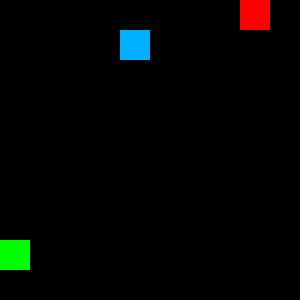

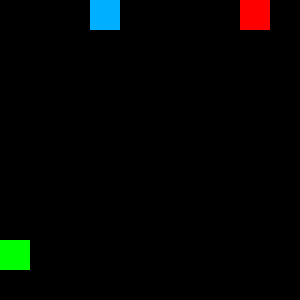

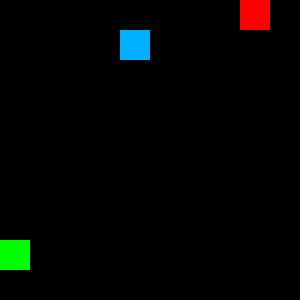

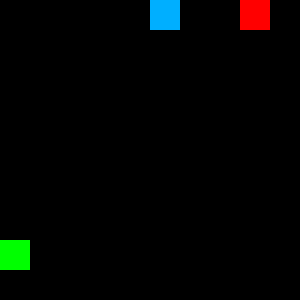

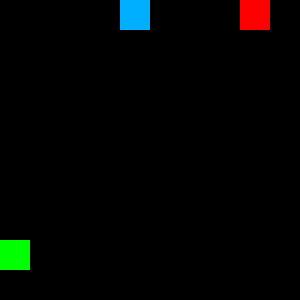

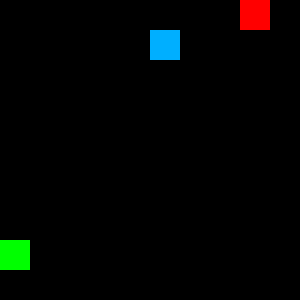

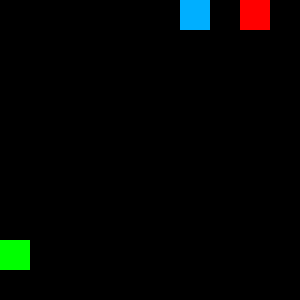

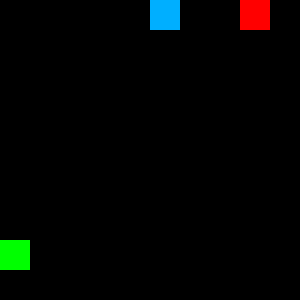

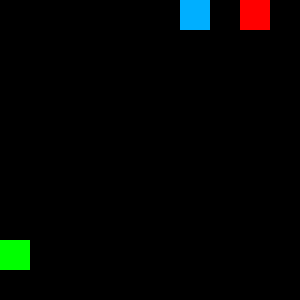

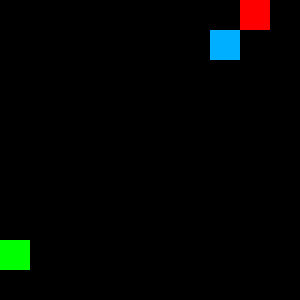

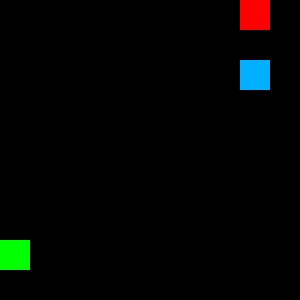

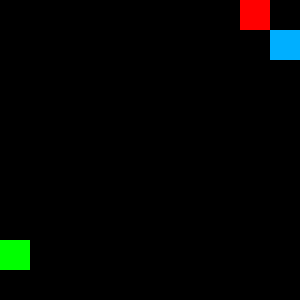

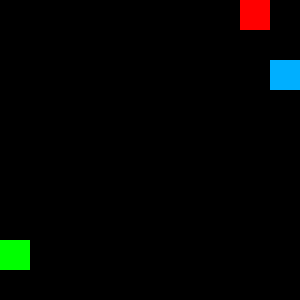

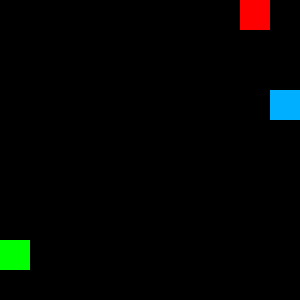

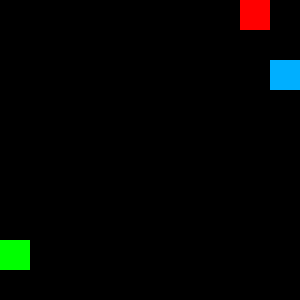

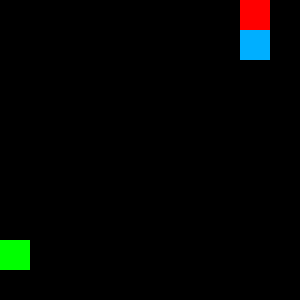

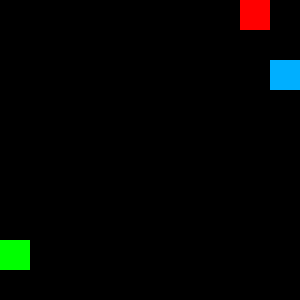

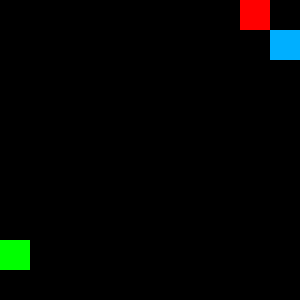

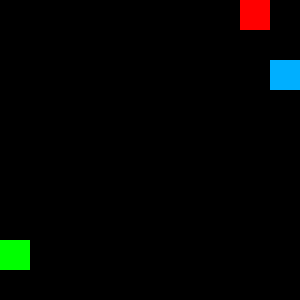

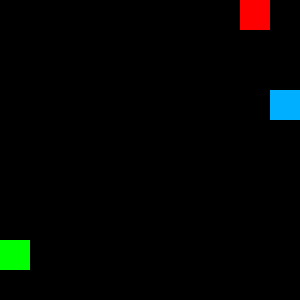

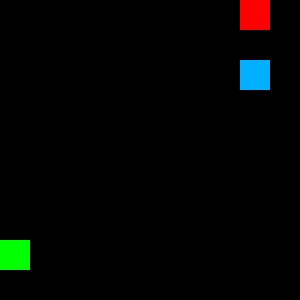

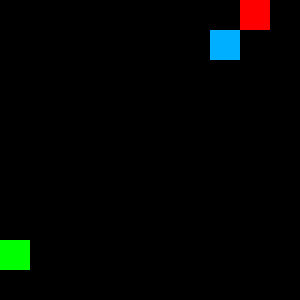

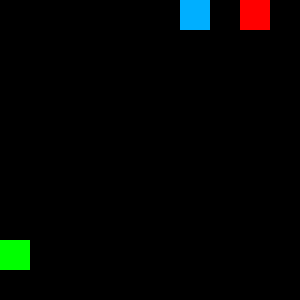

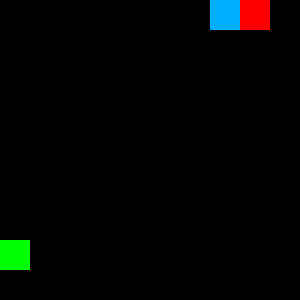

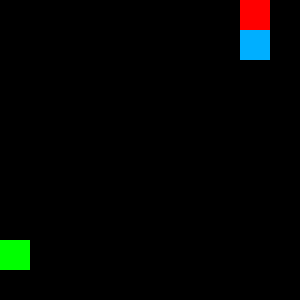

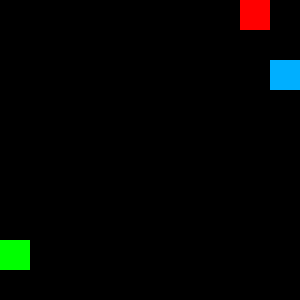

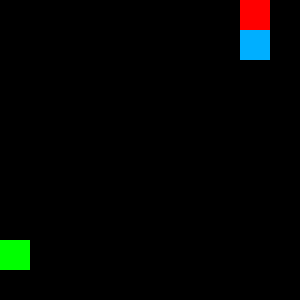

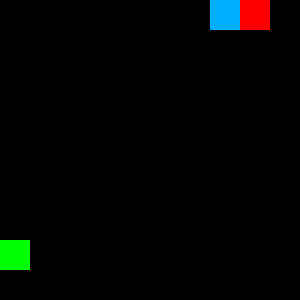

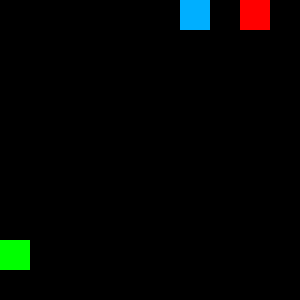

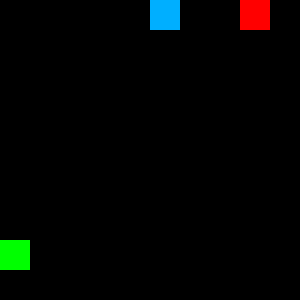

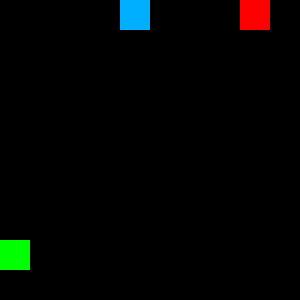

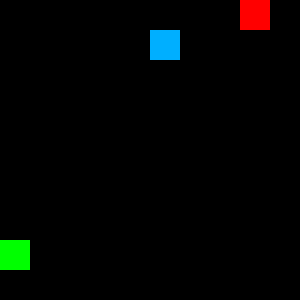

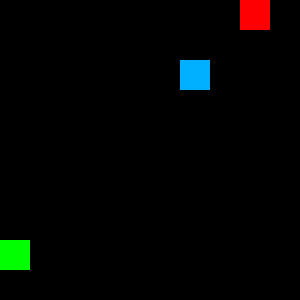

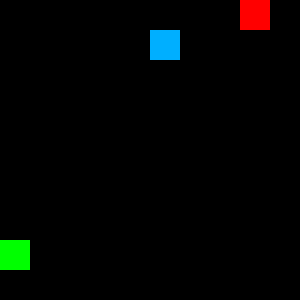

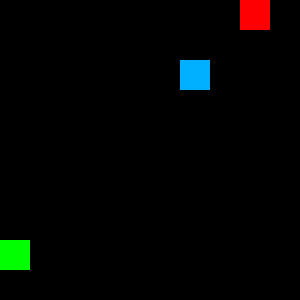

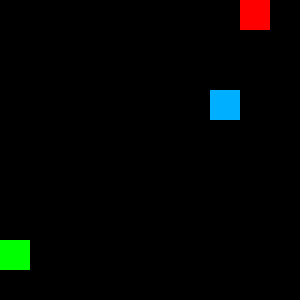

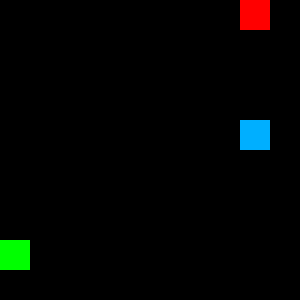

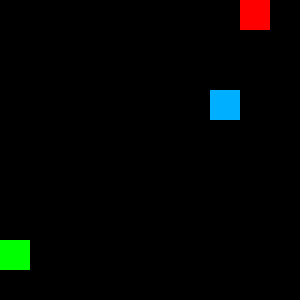

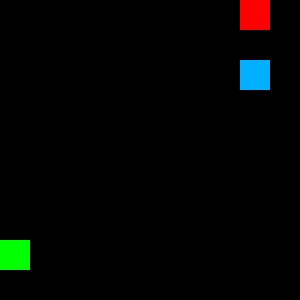

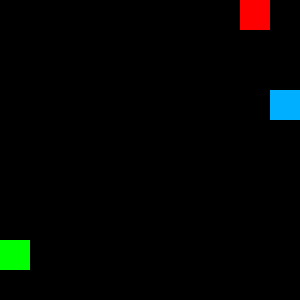

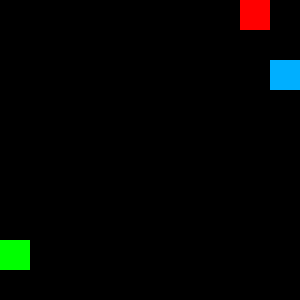

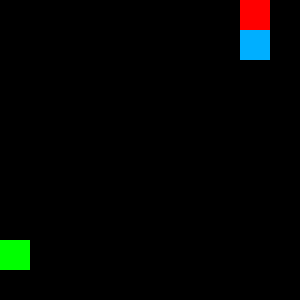

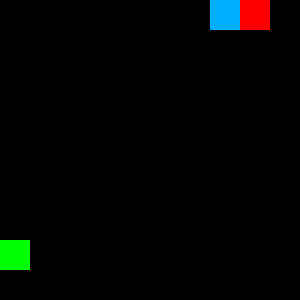

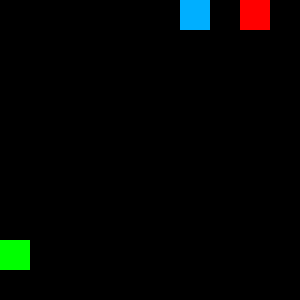

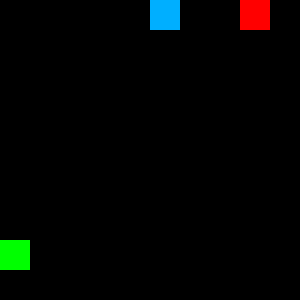

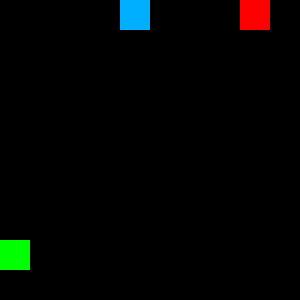

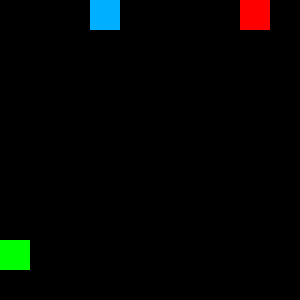

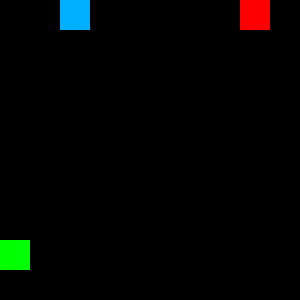

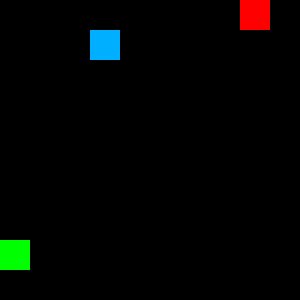

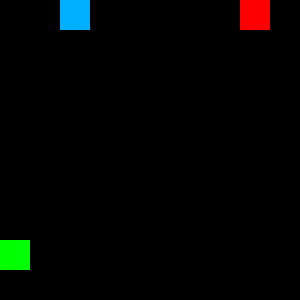

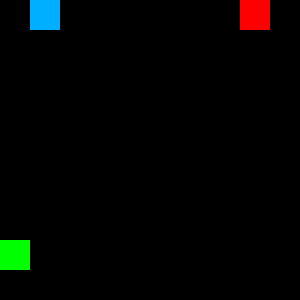

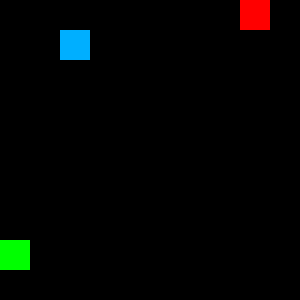

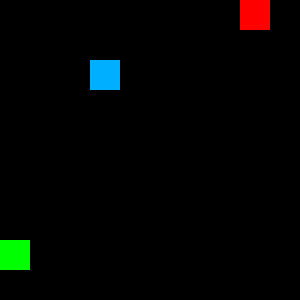

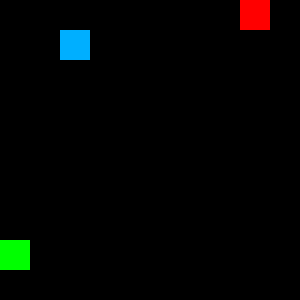

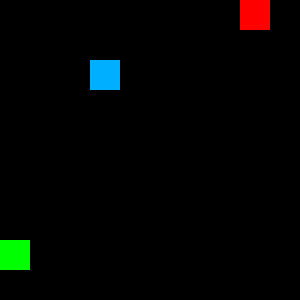

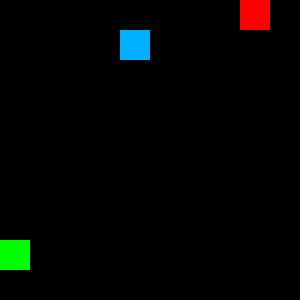

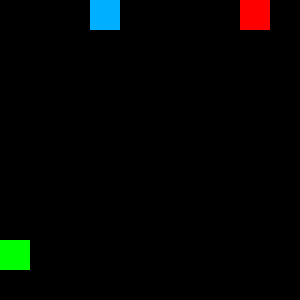

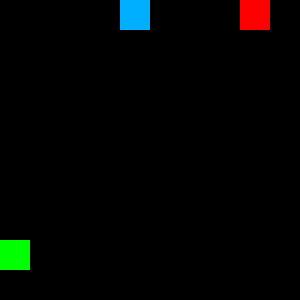

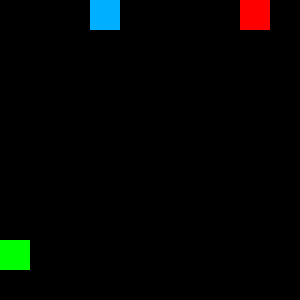

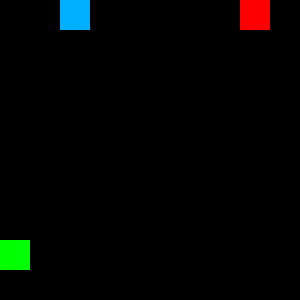

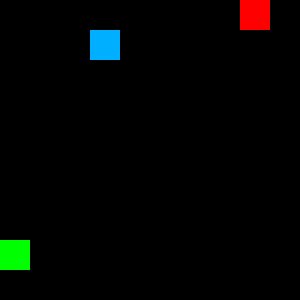

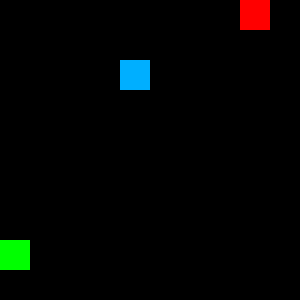

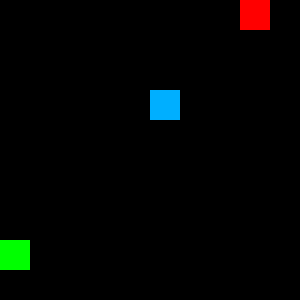

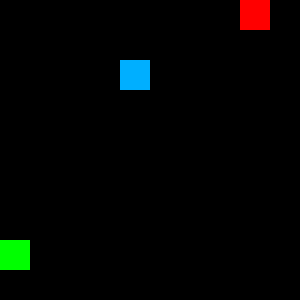

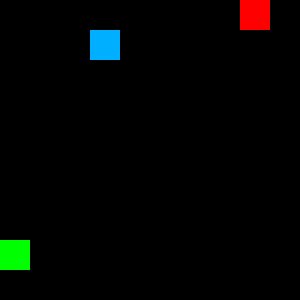

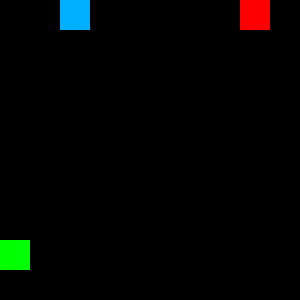

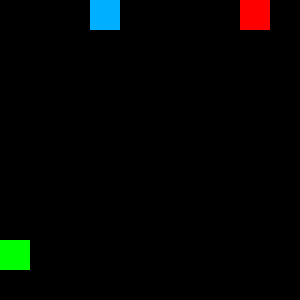

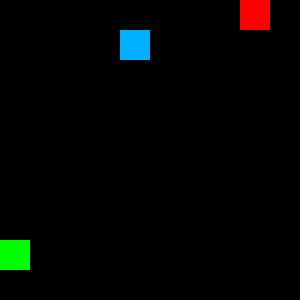

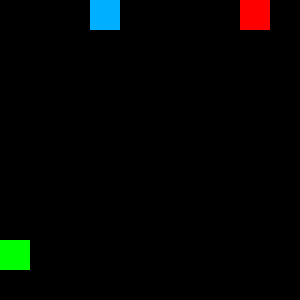

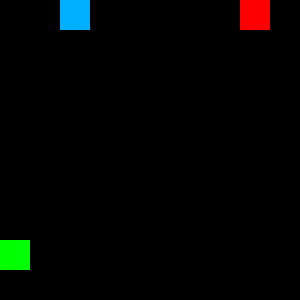

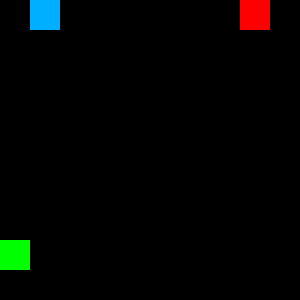

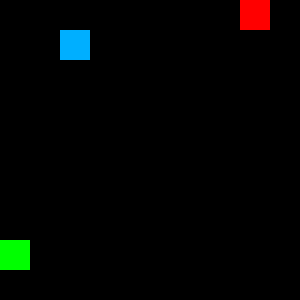

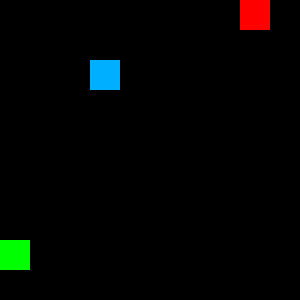

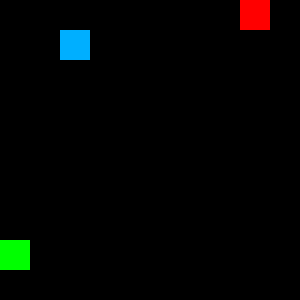

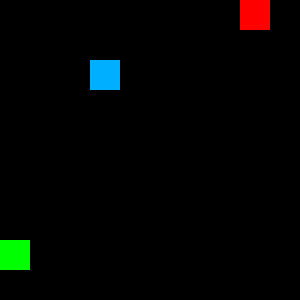

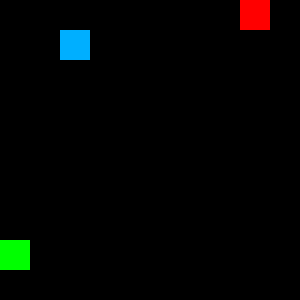

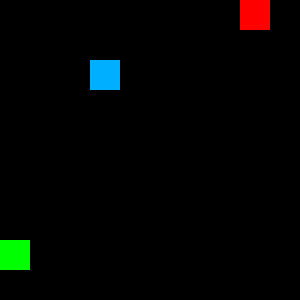

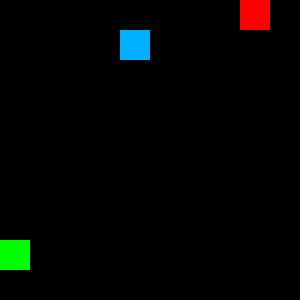

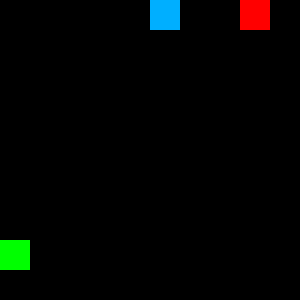

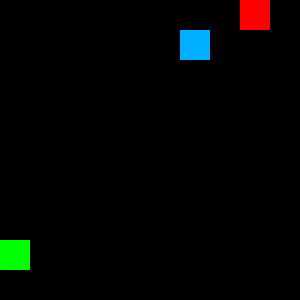

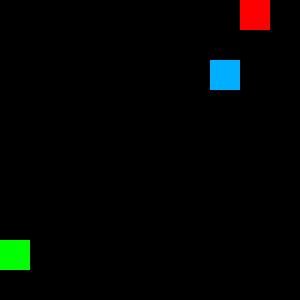

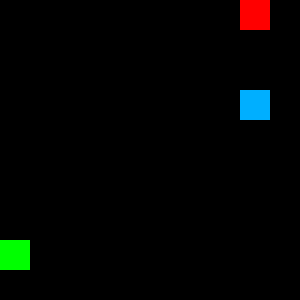

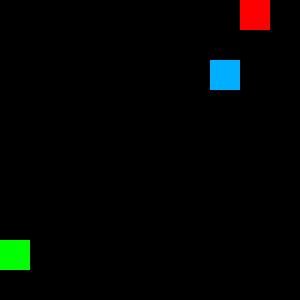

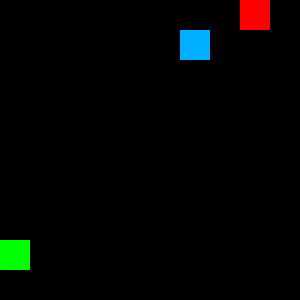

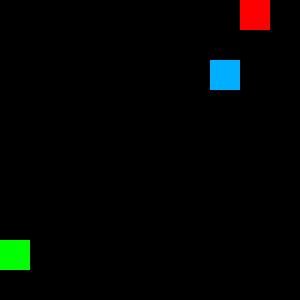

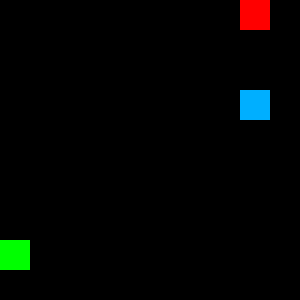

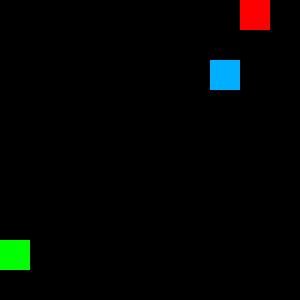

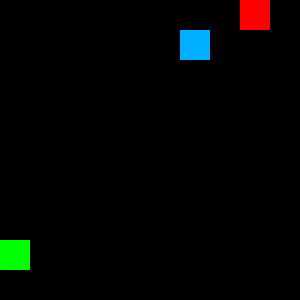

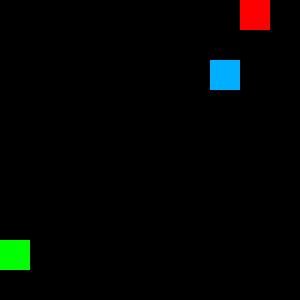

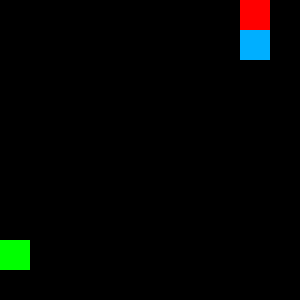

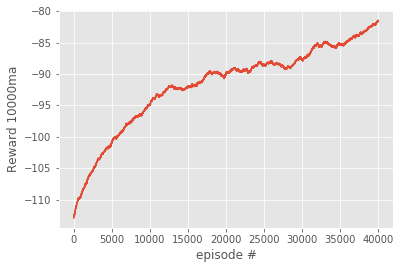

In [15]:
cv2.startWindowThread()

episode_rewards = []

for episode in range(HM_EPISODES):
    player = Blob()
    food = Blob()
    enemy = Blob()
    
    if episode % SHOW_EVERY == 0:
        print(f"on #{episode}, epsilon is {epsilon}")
        print(f"{SHOW_EVERY} ep mean: {np.mean(episode_rewards[-SHOW_EVERY:])}")
        show = True
    else:
        show = False

    episode_reward = 0
    
    for i in range(200):
        obs = (player-food, player-enemy)
        # print(obs)
        if np.random.random() > epsilon:
            # GET THE ACTION
            action = np.argmax(q_table[obs])
        else:
            action = np.random.randint(0, 4)
        # Take the action!
        player.action(action)

        if player.x == enemy.x and player.y == enemy.y:
            reward = -ENEMY_PENALTY

        elif player.x == food.x and player.y == food.y:
            reward = FOOD_REWARD

        else:
            reward = -MOVE_PENALTY

        ## NOW WE KNOW THE REWARD, LET'S CALC YO
        # first we need to obs immediately after the move.

        new_obs = (player-food, player-enemy)  # new observation
        max_future_q = np.max(q_table[new_obs])  # max Q value for this new obs
        current_q = q_table[obs][action]  # current Q for our chosen action

        if reward == FOOD_REWARD:
            new_q = FOOD_REWARD
        elif reward == -ENEMY_PENALTY:
            new_q = -ENEMY_PENALTY
        else:
            new_q = (1 - LEARNING_RATE) * current_q + LEARNING_RATE*(reward + DISCOUNT*max_future_q)

        q_table[obs][action] = new_q

        if show:
            env = np.zeros((SIZE, SIZE, 3), dtype=np.uint8)  # starts an rbg of our size
            env[food.y][food.x] = d[FOOD_N]  # sets the food location tile to green color
            env[player.y][player.x] = d[PLAYER_N]  # sets the player tile to blue
            env[enemy.y][enemy.x] = d[ENEMY_N]  # sets the enemy location to red
            img = Image.fromarray(env, 'RGB')  # reading to rgb. Apparently. Even tho color definitions are bgr. ???
            img = img.resize((300, 300))  # resizing so we can see our agent in all its glory.
            cv2_imshow(np.array(img))  # show it!
            if reward == FOOD_REWARD or reward == -ENEMY_PENALTY:  # crummy code to hang at the end if we reach abrupt end for good reasons or not.
                if cv2.waitKey(500) & 0xFF == ord('q'):
                    break
            else:
                if cv2.waitKey(1) & 0xFF == ord('q'):
                    break
            
        episode_reward += reward

        if reward == FOOD_REWARD or reward == -ENEMY_PENALTY: #if we either reached objective or hit our enemy
          break

    #print(episode_reward)
    episode_rewards.append(episode_reward)
    epsilon *= EPS_DECAY


# plotting rewards
moving_avg = np.convolve(episode_rewards, np.ones((SHOW_EVERY,))/SHOW_EVERY, mode='valid')

plt.plot([i for i in range(len(moving_avg))], moving_avg)
plt.ylabel(f"Reward {SHOW_EVERY}ma")
plt.xlabel("episode #")
plt.show()


with open(f"qtable-{int(time.time())}.pickle", "wb") as f:
    pickle.dump(q_table, f)